## phase_locking_to_hpc.ipynb

In [3]:
import sys
import os
import glob
from time import time
from collections import OrderedDict
from importlib import reload
from glob import glob

import numpy as np
import pandas as pd
import scipy.io as sio
import scipy.stats as stats

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 150
colors = ['1f77b4', 'd62728', '2ca02c', 'ff7f0e', '9467bd', 
          '8c564b', 'e377c2', '7f7f7f', 'bcbd22', '17becf']
mpl.rcParams['axes.prop_cycle'] = mpl.cycler('color', colors)
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.formatter.offset_threshold'] = 2
mpl.rcParams['xtick.labelsize'] = 'small'
mpl.rcParams['ytick.labelsize'] = 'small'
mpl.rcParams['axes.labelsize'] = 'small'
mpl.rcParams['axes.titlesize'] = 'small'
mpl.rcParams['legend.fontsize'] = 'small'
mpl.rcParams['figure.titlesize'] = 'small'
mpl.rcParams['axes.grid'] = True
mpl.rcParams['axes.axisbelow'] = True
mpl.rcParams['grid.linewidth'] = 0.1
mpl.rcParams['grid.alpha'] = 0.75
mpl.rcParams['legend.frameon'] = False
mpl.rcParams['lines.linewidth'] = 0.8 

import mne
import neurodsp
from ptsa.data.TimeSeriesX import TimeSeries 

sys.path.append('/home1/dscho/code/general')
sys.path.append('/home1/dscho/code/projects/manning_replication')
sys.path.append('/home1/dscho/code/projects/unit_activity_and_hpc_theta')
import data_io as dio
import array_operations as aop
import spectral_processing as spp
import manning_utils
import manning_analysis
import phase_locking
from eeg_plotting import plot_trace, plot_trace2

In [4]:
import itertools
import statsmodels.api as sm
import astropy.stats.circstats as circstats
from matplotlib.lines import Line2D
import matplotlib.patches as patches

In [25]:
# Params.
bands = OrderedDict([('sub_delta', [0.5, 2]),
                     ('delta', [1, 4]),
                     ('low_theta', [2, 8]),
                     ('high_theta', [4, 16]),
                     ('alpha_beta', [8, 32])])
band_names = list(bands.keys())
bands_fancy = OrderedDict([('sub_delta', 'Sub-delta (0.5-2 Hz)'),
                           ('delta', 'Delta (1-4 Hz)'),
                           ('low_theta', 'Low theta (2-8 Hz)'),
                           ('high_theta', 'High theta (4-16 Hz)'),
                           ('alpha_beta', 'Alpha-beta (8-32 Hz)')])
bands_fancy2 = OrderedDict([('sub_delta', 'Low delta'),
                            ('delta', 'High delta'),
                            ('low_theta', 'Low theta'),
                            ('high_theta', 'High theta'),
                            ('alpha_beta', 'Alpha-beta')])
bands_fancy2 = OrderedDict([('sub_delta', '0.5-2Hz'),
                            ('delta', '1-4Hz'),
                            ('low_theta', '2-8Hz'),
                            ('high_theta', '4-16Hz'),
                            ('alpha_beta', '8-32Hz')])
rois = ['hpc', 'amy', 'ec', 'phg', 'ctx']
sessions = ['U387_ses3', 'U369_env1', 'U372_ses2', 'U390_ses3', 
            'U369_env2', 'U373_ses1', 'U387_ses1', 'U380_ses2', 
            'U393_ses2', 'U395_ses2', 'U384_ses3', 'U385_ses4', 
            'U371_env2', 'U371_env3']
sessions = np.sort(sessions)

interp_spikes = False
notch_freqs = [60, 120]
phase_type = 'extrema2'
mask_type = None

In [6]:
# Load all cross-electrode files into a single dataframe.
upl_files = glob(os.path.join('/scratch/dscho/unit_activity_and_hpc_theta/data/crosselec_phase_locking', 
                              '*_crosselec_phaselock_byunit_df_notch60-120_nospikeinterp_phase-extrema2_nomask_timelag-2to2sec-step10ms_1000bootstraps2_hpc-subset_bands--sub_delta0.5-2--delta1-4--low_theta2-8--high_theta4-16--alpha_beta8-32.pkl'))
print('Found {} files'.format(len(upl_files)))

upl_df = dio.open_pickle(upl_files[0])
for f in upl_files[1:]:
    upl_df = upl_df.append(dio.open_pickle(f))
upl_df.reset_index(drop=True, inplace=True)
upl_df['locked_band'] = upl_df.locked_band.astype('category').cat.reorder_categories(band_names, ordered=True)
upl_df['unit_roi2'] = upl_df.unit_roi2.astype('category').cat.reorder_categories(rois, ordered=True)
upl_df['lfp_roi2'] = upl_df.lfp_roi2.astype('category').cat.reorder_categories(rois, ordered=True)

Found 14 files


In [1261]:
# Load files for ctx-ctx comparisons
files = glob(os.path.join('/scratch/dscho/unit_activity_and_hpc_theta/data/crosselec_phase_locking', 
                          '*_crosselec_phaselock_byunit_df_notch60-120_nospikeinterp_phase-extrema2_nomask_1000bootstraps2_ctx-subset_bands--sub_delta0.5-2--delta1-4--low_theta2-8--high_theta4-16--alpha_beta8-32.pkl'))
print('Found {} files'.format(len(files)))

ctx_df = dio.open_pickle(files[0])
for f in files[1:]:
    ctx_df = ctx_df.append(dio.open_pickle(f))
print(ctx_df.shape)

Found 14 files
(1144, 18)


In [113]:
upl_df['tl_mrls_locked_band'] = upl_df.apply(lambda x: tuple(np.flip(x['tl_mrls'][x['mrl_argmax'], :], axis=-1)), axis=1)
upl_df['tl_mrls_locked_band'] = upl_df.tl_mrls_locked_band.apply(lambda x: np.array(x))
upl_df['tl_timemax'] = upl_df.apply(lambda x: (x['tl_mrls'][x['mrl_argmax'], :].argmax() - 200) * -10, axis=1) # note we are flipping the time axis
upl_df.loc[upl_df.tl_timemax<-500, 'sig'] = False
upl_df.loc[upl_df.tl_timemax>500, 'sig'] = False
upl_df['tl_timemax_cat'] = ''
upl_df.loc[(upl_df.tl_timemax<-10), 'tl_timemax_cat'] = 'future LFP'
upl_df.loc[(upl_df.tl_timemax>=-10) & (upl_df.tl_timemax<=10), 'tl_timemax_cat'] = 'present LFP'
upl_df.loc[(upl_df.tl_timemax>10), 'tl_timemax_cat'] = 'past LFP'

In [126]:
# Get a list of units that are phase-locked to
# *both* local and hippocampal LFPs
s = upl_df.groupby(['subj_sess_unit']).sig.sum()
unq = np.unique(s, return_counts=True)
print(unq, np.sum(unq[1]), unq[1]/np.sum(unq[1]))
pl2_units = list(s[s==2].index)

(array([0., 1., 2.]), array([185, 280,  98])) 563 [0.3285968 0.4973357 0.1740675]


In [684]:
n = 4
c = 2
colors = [sns.color_palette('Blues', n)[c], 
          sns.color_palette('Reds', n)[c], 
          sns.color_palette('Greens', n)[c],
          sns.color_palette('Purples', n)[c],
          sns.color_palette('Oranges', n)[c],
          sns.color_palette('Greys', n)[c]]

## Phase-locking?

In [954]:
print('{} neurons outside the hippocampus'.format(len(units['all'])))

448 neurons outside the hippocampus


Text(0,0.5,'Phase-locking percent')

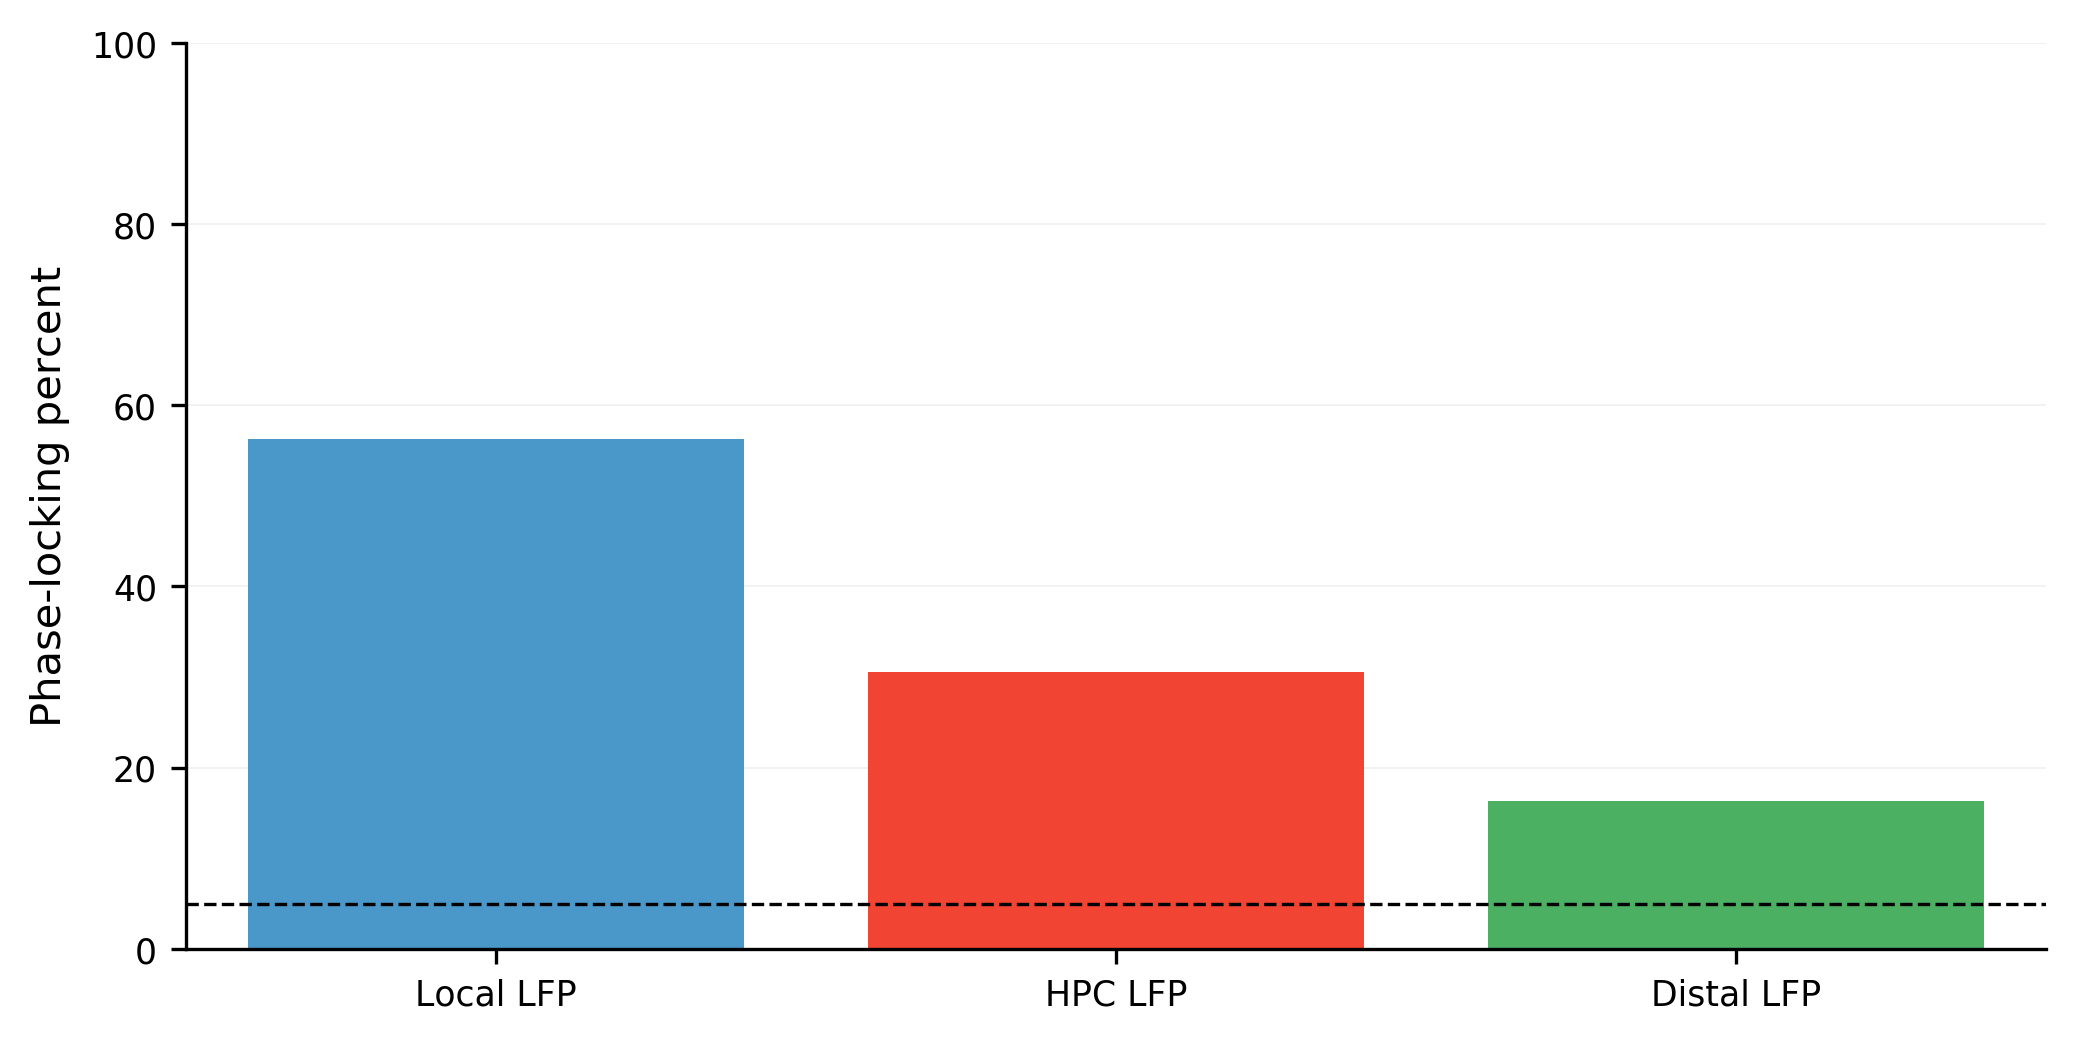

In [1273]:
# What percent of extra-hippocampal units are phase-locked to local and HPC LFPs?
#df = upl_df.query("(unit_roi2!='hpc')").groupby('lfp_is_hpc').agg({'subj_sess_unit': len, 'sig': np.mean}).reset_index()
df1 = ctx_df.groupby('lfp_is_hpc').agg({'subj_sess_unit': len, 'sig': np.mean}).reset_index()
df1['cat'] = 'Distal LFP'
df2 = upl_df.query("(unit_roi2!='hpc')").groupby('lfp_is_hpc').agg({'subj_sess_unit': len, 'sig': np.mean}).reset_index()
df2['cat'] = ['Local LFP', 'HPC LFP']
df = pd.concat((df1, df2))
df['cat'] = df.cat.astype('category').cat.reorder_categories(['Local LFP', 'HPC LFP', 'Distal LFP'], ordered=True)

fig, ax = plt.subplots(1, 1, figsize=(8, 4), dpi=300)
ax = np.ravel(ax)

sns.barplot(x='cat', y='sig', data=df, palette=colors, saturation=100, ax=ax[0])
ax[0].axhline(y=0.05, color='k', linestyle='--')
#ax[0].set_xticklabels(['Local LFP', 'HPC LFP'])
ax[0].set_ylim([0, 1])
ax[0].set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
ax[0].set_yticklabels([0, 20, 40, 60, 80, 100])
ax[0].set_xlabel('')
ax[0].set_ylabel('Phase-locking percent', fontsize=10, labelpad=5)

In [1335]:
# Binomial tests for difference in observed versus expected proportions

# Does local and HPC LFP phase-locking occur above chance levels (set by bootstrap at 5%)?
print('Local:', stats.binom_test(x=upl_df.query("(unit_roi2!='hpc') & (lfp_is_hpc==0)").sig.sum(),
                                 n=len(upl_df.query("(unit_roi2!='hpc') & (lfp_is_hpc==0)")), p=0.05),
      '\nHPC:', stats.binom_test(x=upl_df.query("(unit_roi2!='hpc') & (lfp_is_hpc==1)").sig.sum(),
                                 n=len(upl_df.query("(unit_roi2!='hpc') & (lfp_is_hpc==1)")), p=0.05),
      '\nDistal:', stats.binom_test(x=ctx_df.sig.sum(),
                                    n=len(ctx_df), p=0.05))

Local: 5.1196108921093564e-201 
HPC: 1.9522873053149356e-67 
Distal: 1.9942065251487424e-45


In [1334]:
# Chi square tests for independence of proportions

obs = [[np.sum(upl_df.query("(unit_roi2!='hpc') & (lfp_is_hpc==True)").sig==0), np.sum(upl_df.query("(unit_roi2!='hpc') & (lfp_is_hpc==False)").sig==0)],
       [np.sum(upl_df.query("(unit_roi2!='hpc') & (lfp_is_hpc==True)").sig==1), np.sum(upl_df.query("(unit_roi2!='hpc') & (lfp_is_hpc==False)").sig==1)]]
print('HPC and local proportions are different:', stats.chi2_contingency(obs)[:2])

obs = [[np.sum(upl_df.query("(unit_roi2!='hpc') & (lfp_is_hpc==True)").sig==0), np.sum(ctx_df.sig==0)],
       [np.sum(upl_df.query("(unit_roi2!='hpc') & (lfp_is_hpc==True)").sig==1), np.sum(ctx_df.sig==1)]]
print('HPC and distal proportions are different:', stats.chi2_contingency(obs)[:2])

obs = [[np.sum(upl_df.query("(unit_roi2!='hpc') & (lfp_is_hpc==False)").sig==0), np.sum(ctx_df.sig==0)],
       [np.sum(upl_df.query("(unit_roi2!='hpc') & (lfp_is_hpc==False)").sig==1), np.sum(ctx_df.sig==1)]]
print('Local and distal proportions are different:', stats.chi2_contingency(obs)[:2])

HPC and local proportions are different: (59.04187645457172, 1.5435186605816796e-14)
HPC and distal proportions are different: (39.365852508646284, 3.513885039536794e-10)
Local and distal proportions are different: (254.6803732547968, 2.478067411821728e-57)


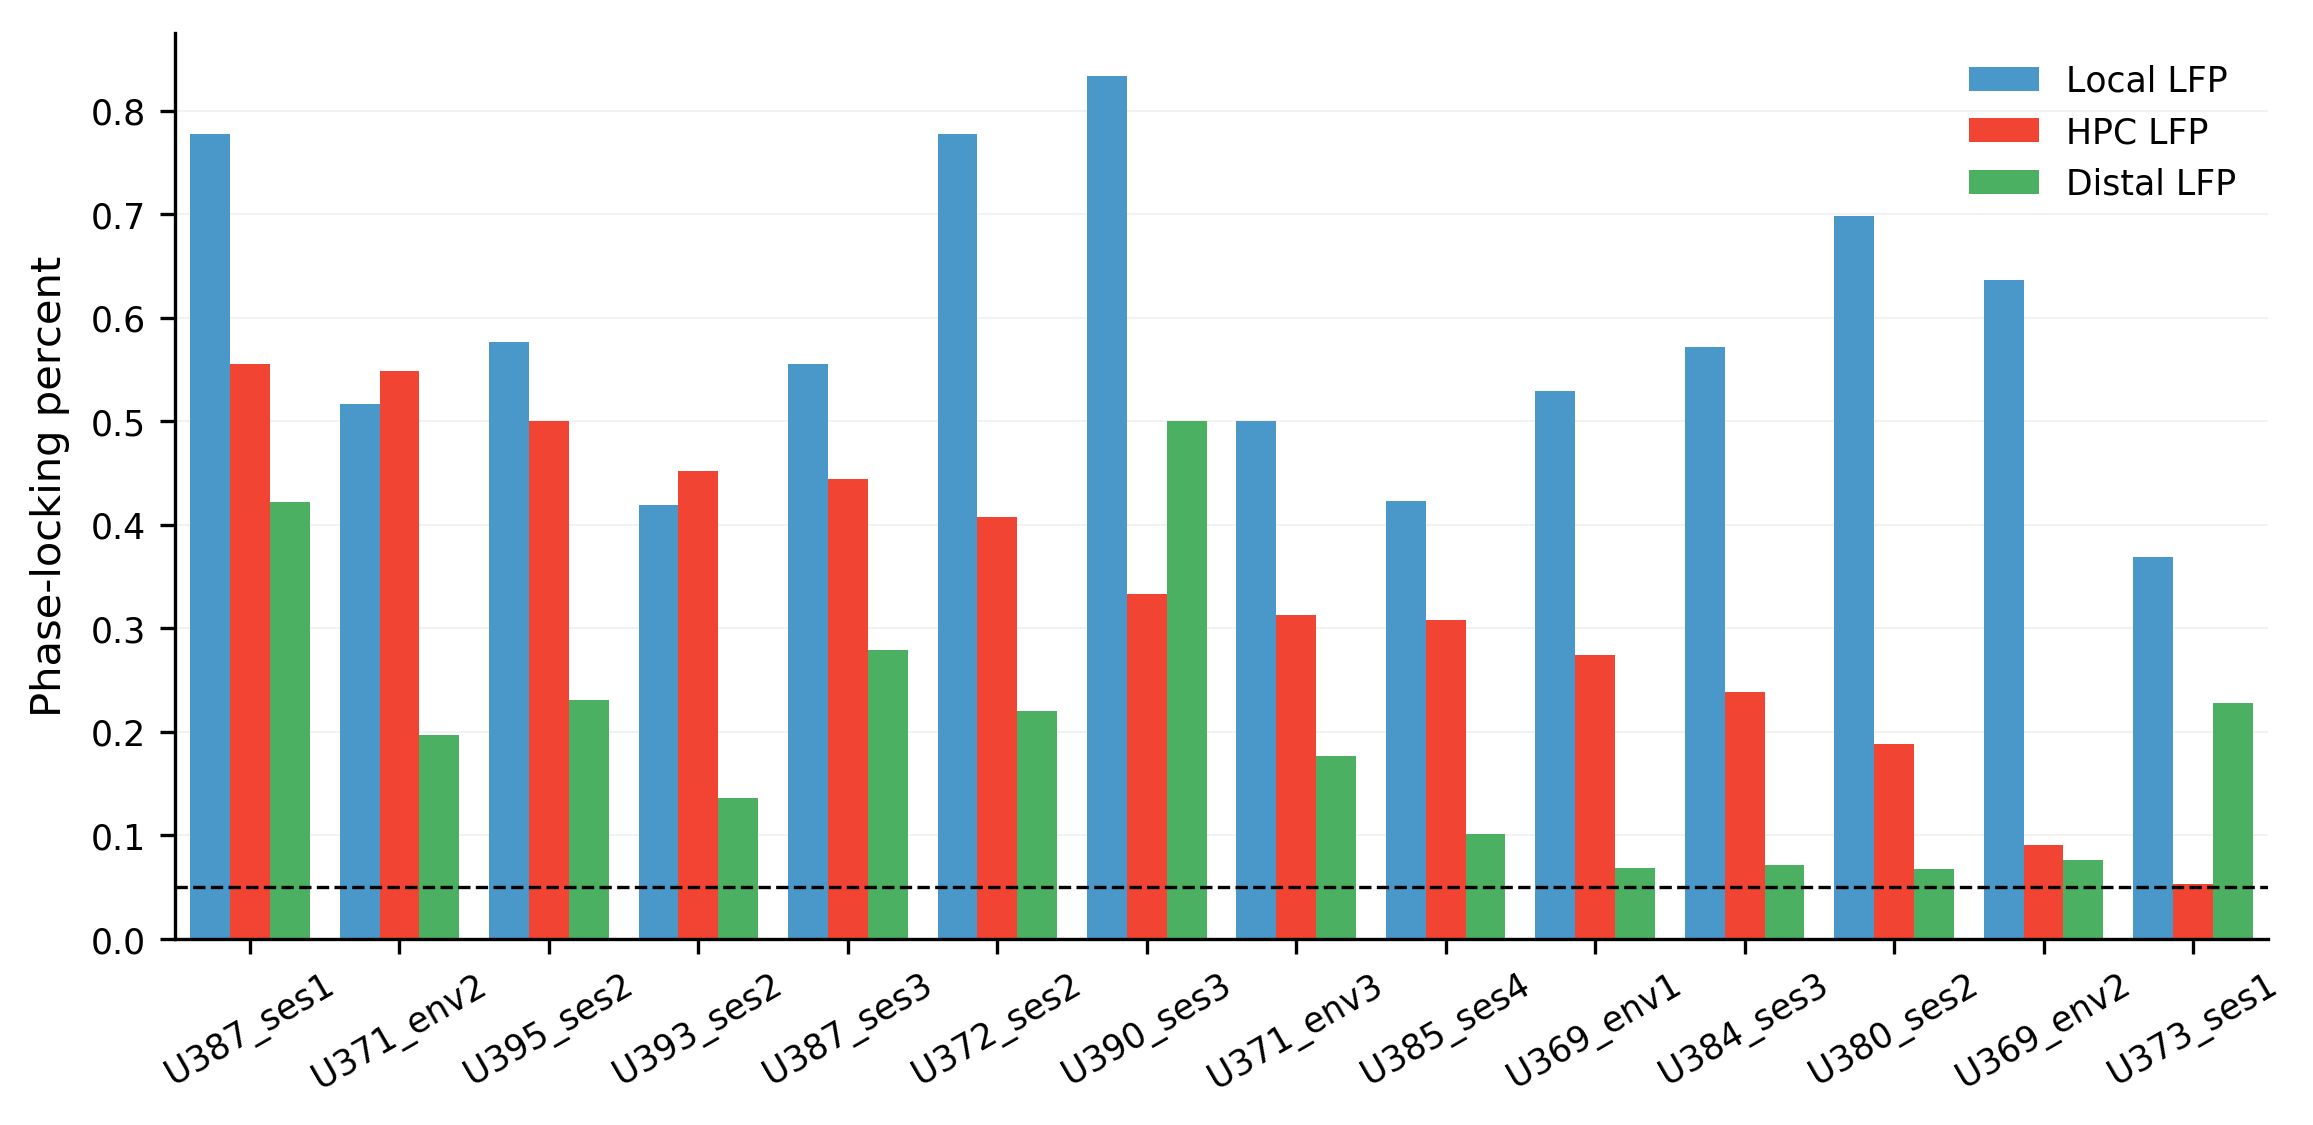

In [1364]:
# Are extra-hippocampal units more likely to be phase-locked
# to local than HPC LFPs in all subj sessions?
df1 = ctx_df.groupby('subj_sess').agg({'subj_sess_unit': len, 'sig': np.mean}).reset_index()
df1['cat'] = 'Distal LFP'
df2 = upl_df.query("(unit_roi2!='hpc')").groupby(['subj_sess', 'lfp_is_hpc']).agg({'subj_sess_unit': len, 'sig': np.mean}).reset_index()
df2['cat'] = df2.lfp_is_hpc.apply(lambda x: 'Local LFP' if x==0 else 'HPC LFP')
df2 = df2.drop(columns='lfp_is_hpc')
df = pd.concat((df1, df2))
df_ = df.groupby(['subj_sess', 'cat']).sig.mean().unstack()
df_['vs'] = df_['HPC LFP'] - df_['Distal LFP']
subs = list(df_.sort_values('HPC LFP', ascending=False).index)
df['n_sig'] = df.subj_sess_unit * df.sig
df['subj_sess'] = df.subj_sess.astype('category').cat.reorder_categories(subs, ordered=True)
df['cat'] = df.cat.astype('category').cat.reorder_categories(['Local LFP', 'HPC LFP', 'Distal LFP'], ordered=True)

fig, ax = plt.subplots(1, 1, figsize=(9, 4), dpi=300)
ax = np.ravel(ax)

sns.barplot(x='subj_sess', y='sig', data=df.reset_index(), hue='cat', palette=colors, saturation=100, ax=ax[0])
ax[0].axhline(y=0.05, color='k', linestyle='--')
ax[0].set_xticklabels(subs, rotation=30)
#ax[0].set_ylim([0, 1])
#ax[0].set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
#ax[0].set_yticklabels([0, 20, 40, 60, 80, 100])
ax[0].set_xlabel('')
ax[0].set_ylabel('Phase-locking percent', fontsize=10, labelpad=5)
legend = plt.legend()
legend.get_texts()[0].set_text('Local LFP')
legend.get_texts()[1].set_text('HPC LFP')

In [1350]:
# Wilcoxon signed-rank tests for differences in phase-locking proportions across subjects
df = df.pivot(index='subj_sess', columns='cat', values='sig')
print('Local vs. HPC', stats.wilcoxon(df['Local LFP'], df['HPC LFP']))
print('HPC vs. distal', stats.wilcoxon(df['HPC LFP'], df['Distal LFP']))
print('Local vs. distal', stats.wilcoxon(df['Local LFP'], df['Distal LFP']))

Local vs. HPC WilcoxonResult(statistic=3.0, pvalue=0.001882296697607232)
HPC vs. distal WilcoxonResult(statistic=15.0, pvalue=0.018566712279734197)
Local vs. distal WilcoxonResult(statistic=0.0, pvalue=0.0009815397525216685)


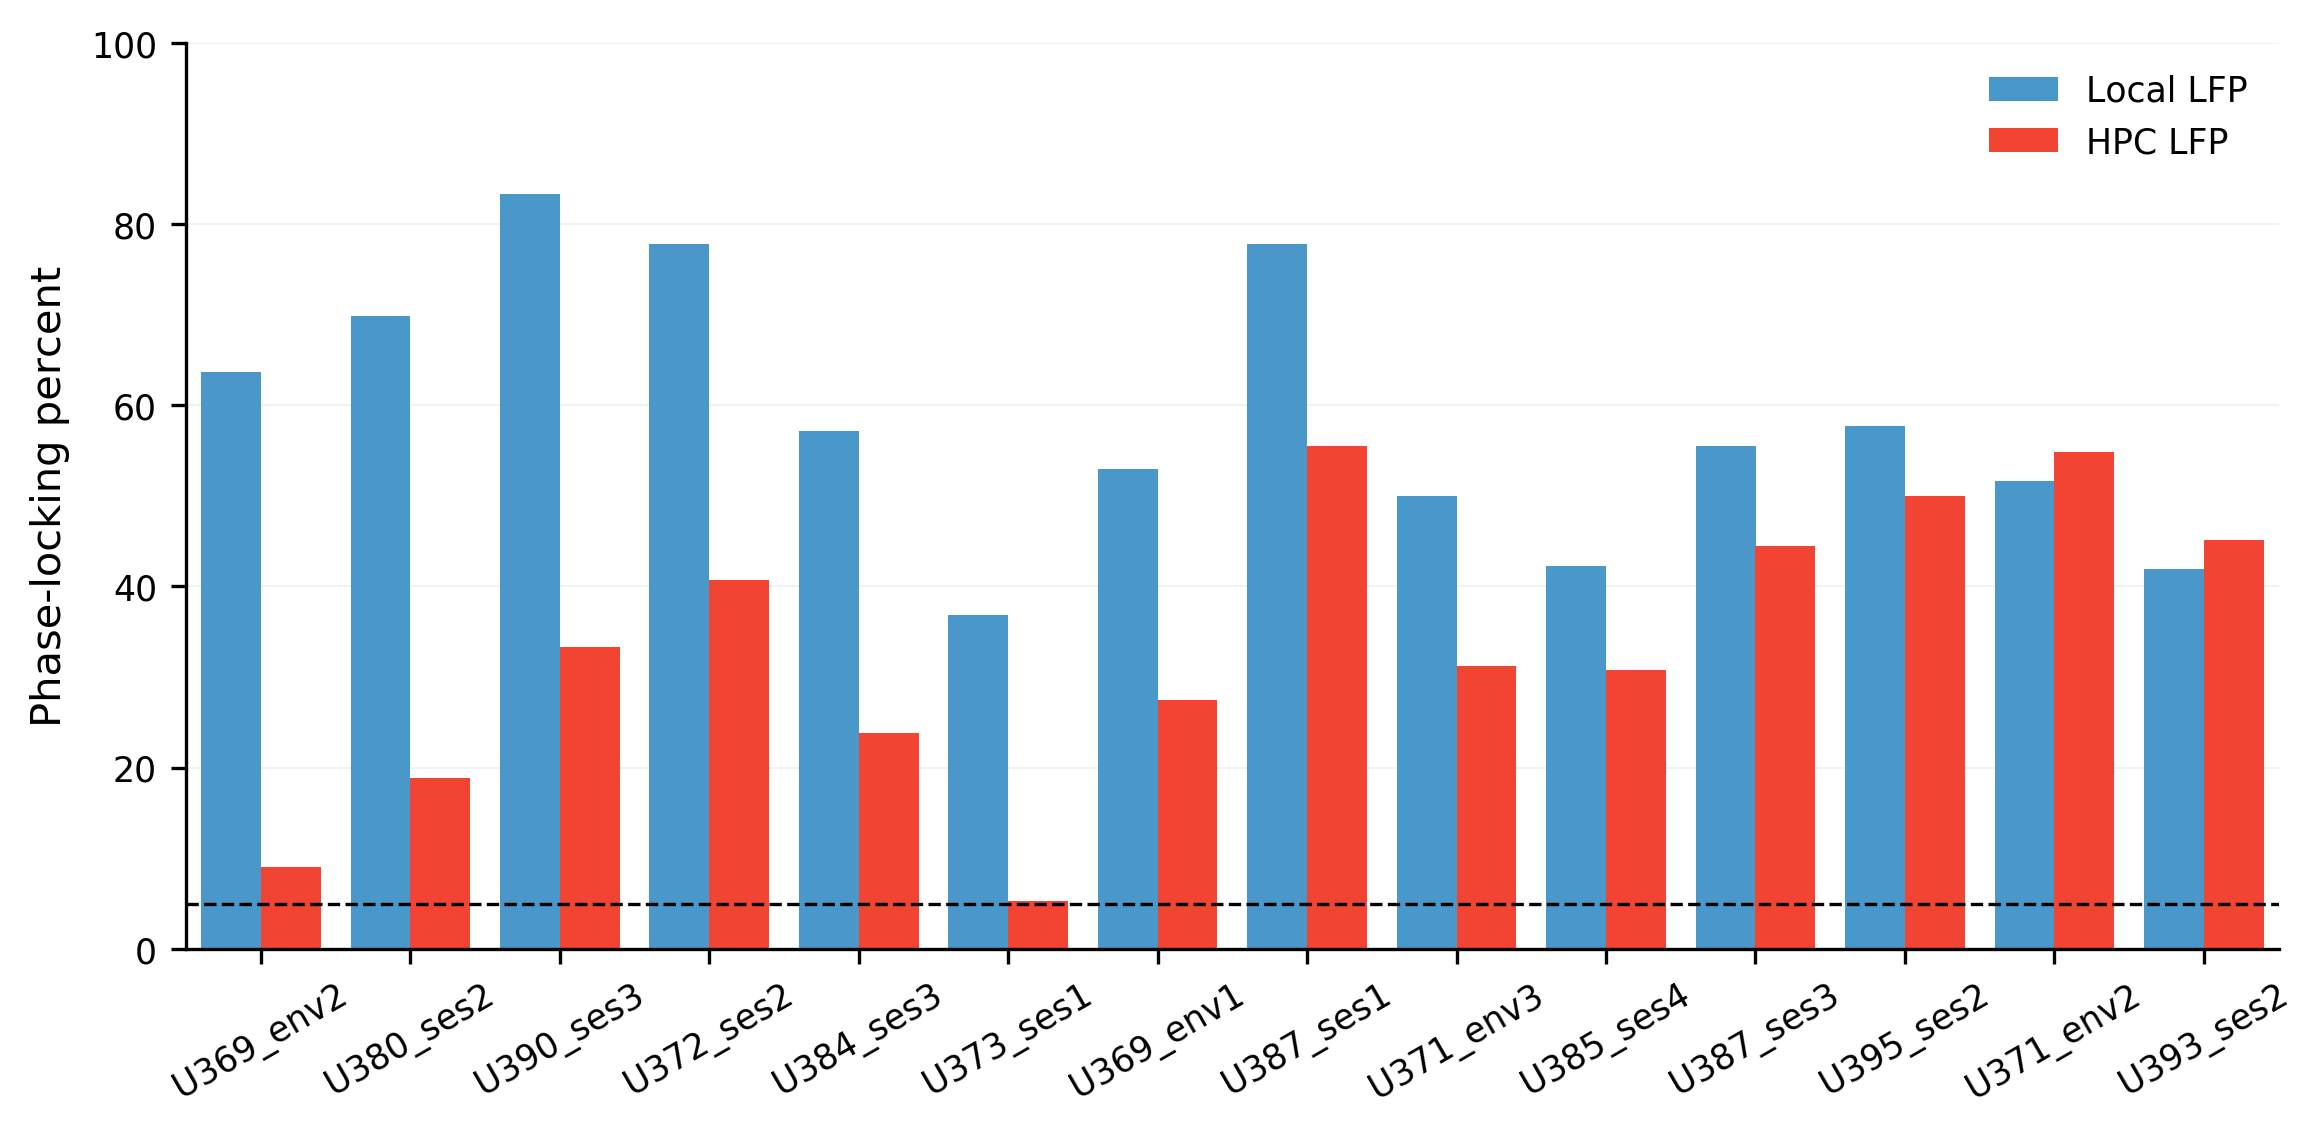

In [580]:
# Are extra-hippocampal units more likely to be phase-locked
# to local than HPC LFPs in all subj sessions?
df = (upl_df
 .query("(unit_roi2!='hpc')")
 .groupby(['subj_sess', 'lfp_is_hpc'])
 .agg({'subj_sess_unit': len, 'sig': np.mean})
 .reset_index()
 .sort_values('subj_sess'))
df_ = df.groupby(['subj_sess', 'lfp_is_hpc']).sig.mean().unstack()
df_['vs'] = df_[0] - df_[1]
subs = list(df_.sort_values('vs', ascending=False).index)
df['subj_sess'] = df.subj_sess.astype('category').cat.reorder_categories(subs, ordered=True)

fig, ax = plt.subplots(1, 1, figsize=(9, 4), dpi=300)
ax = np.ravel(ax)

sns.barplot(x='subj_sess', y='sig', data=df.reset_index(), hue='lfp_is_hpc', palette=colors, saturation=100, ax=ax[0])
ax[0].axhline(y=0.05, color='k', linestyle='--')
ax[0].set_xticklabels(subs, rotation=30)
ax[0].set_ylim([0, 1])
ax[0].set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
ax[0].set_yticklabels([0, 20, 40, 60, 80, 100])
ax[0].set_xlabel('')
ax[0].set_ylabel('Phase-locking percent', fontsize=10, labelpad=5)
legend = plt.legend()
legend.get_texts()[0].set_text('Local LFP')
legend.get_texts()[1].set_text('HPC LFP')

In [923]:
# Is the percent of HPC phase-locking among locally phase-locked neurons > HPC phase-locking in the population at large?
len(units['both']) / (len(units['local']) + len(units['both'])), (len(units['hpc']) + len(units['both'])) / len(units['all'])

(0.3888888888888889, 0.30580357142857145)

In [920]:
# Do we see more local x HPC sig neurons than we would expect by chance,
# (given the rates of local and HPC phase-locking, respectively)?
obs = len(units['both'])
exp = ((len(units['hpc']) + len(units['both'])) / len(units['all'])) * ((len(units['local']) + len(units['both'])) / len(units['all']))
n = len(units['all'])
print(obs/n, exp, n, stats.binom_test(obs, n, exp))

0.21875 0.17201450892857145 448 0.010231908815748252


## Phase-locking where?

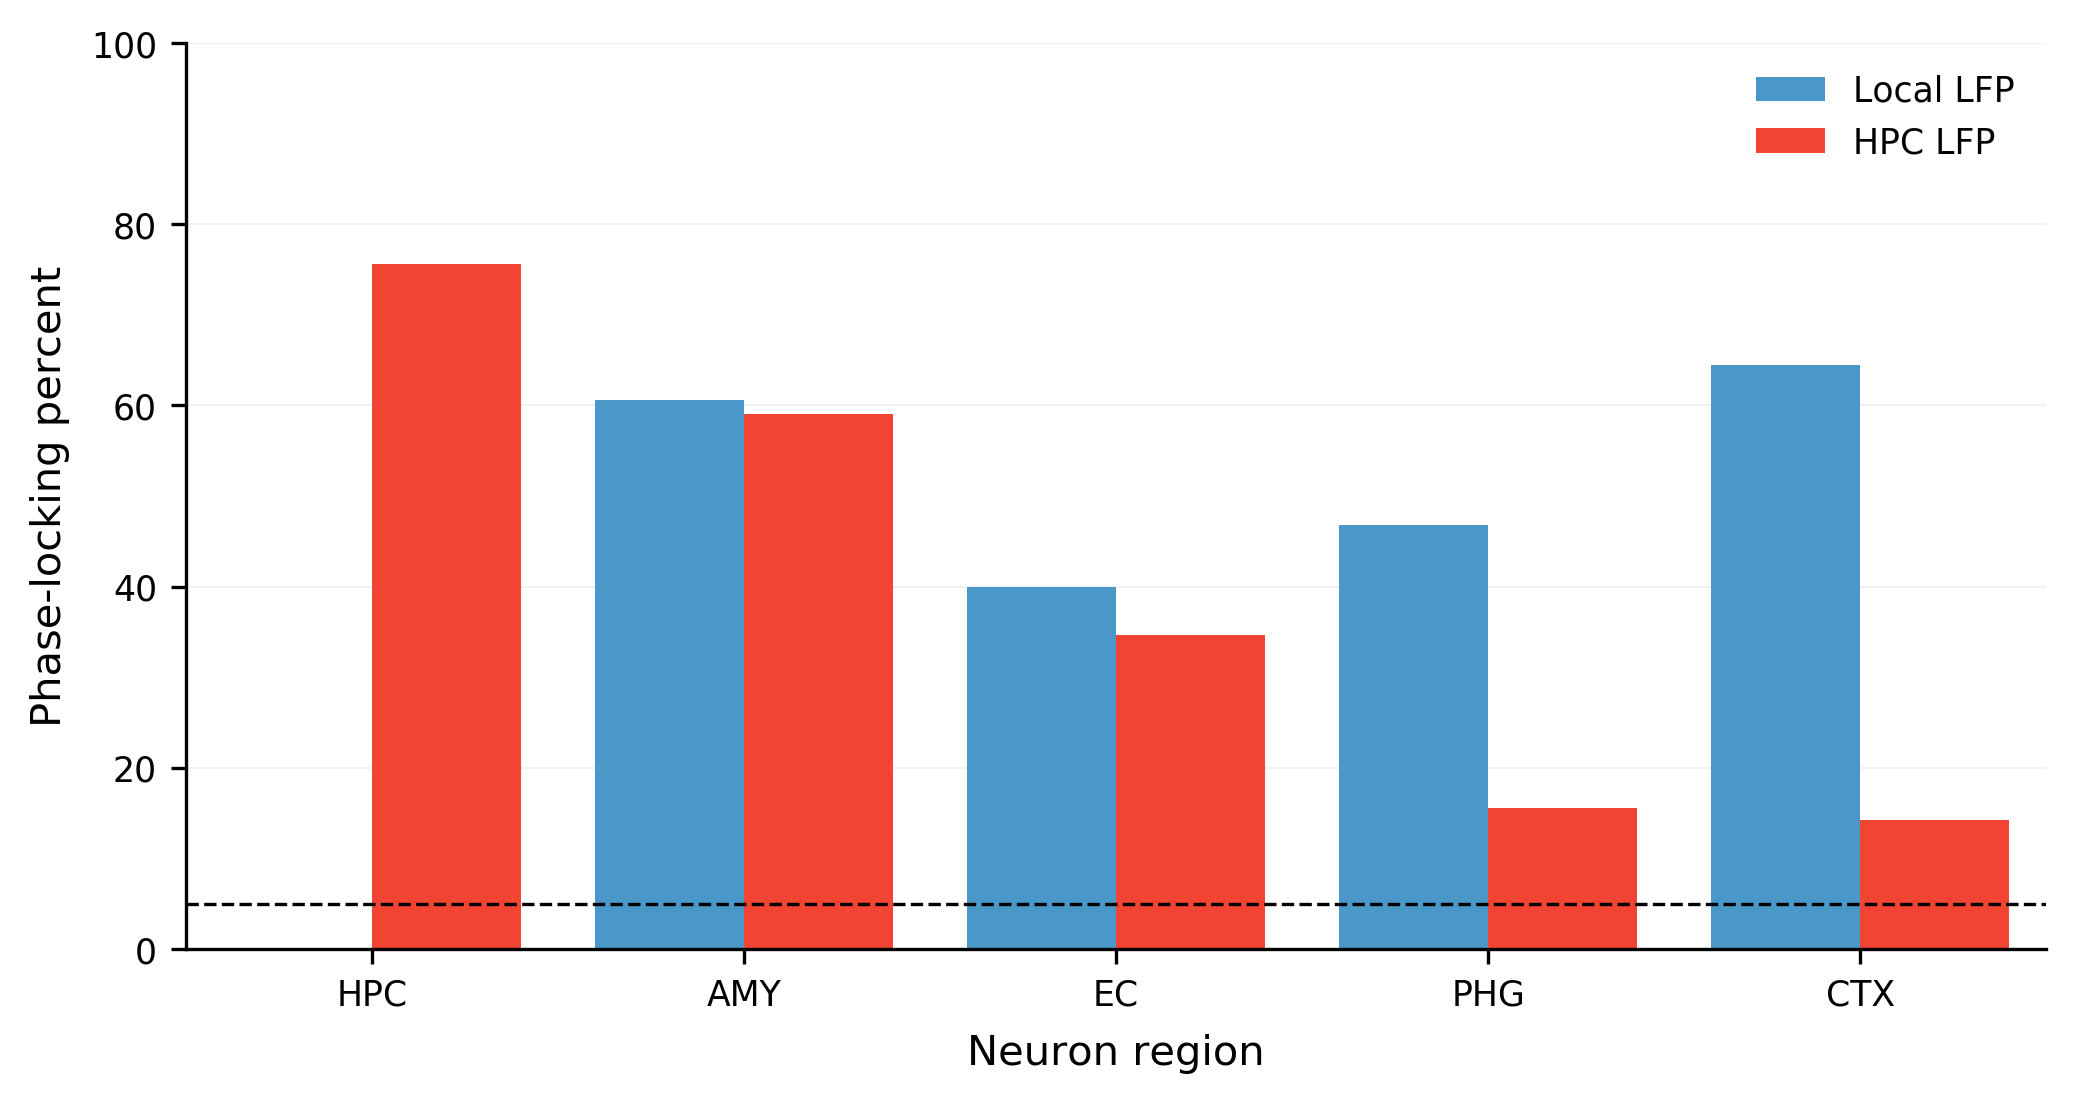

In [926]:
# What percent of units, by region, are phase-locked to local and HPC LFPs?
df = upl_df.groupby(['lfp_is_hpc', 'unit_roi2']).agg({'subj_sess_unit': len, 'sig': np.mean})

fig, ax = plt.subplots(1, 1, figsize=(8, 4), dpi=300)
ax = np.ravel(ax)

sns.barplot(x='unit_roi2', y='sig', data=df.reset_index(), hue='lfp_is_hpc', palette=colors, saturation=100, ax=ax[0])
ax[0].axhline(y=0.05, color='k', linestyle='--')
ax[0].set_xticklabels([roi.upper() for roi in rois])
ax[0].set_ylim([0, 1])
ax[0].set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
ax[0].set_yticklabels([0, 20, 40, 60, 80, 100])
ax[0].set_xlabel('Neuron region', fontsize=10, labelpad=5)
ax[0].set_ylabel('Phase-locking percent', fontsize=10, labelpad=5)
legend = plt.legend()
legend.get_texts()[0].set_text('Local LFP')
legend.get_texts()[1].set_text('HPC LFP')

In [125]:
# What percent of units, by region, are phase-locked to local and HPC LFPs?
(upl_df
 .query("(sig==True)")
 .groupby(['lfp_is_hpc', 'unit_roi2'])
 .agg({'subj_sess_unit': len, 
       'locked_mrl': [np.mean, np.median, np.std], 
       'unit_fr': [np.mean, np.median, np.std]}))

subj_sess_unit locked_mrl                       unit_fr  \
                                len       mean    median       std      mean   
lfp_is_hpc unit_roi2                                                           
0          amy                   77   0.079061  0.064898  0.046299  2.735994   
           ec                    30   0.038779  0.033925  0.019485  4.942493   
           phg                   36   0.046748  0.037334  0.032543  3.836820   
           ctx                  109   0.068546  0.045355  0.064053  7.408751   
1          hpc                   87   0.081389  0.056939  0.081403  4.267394   
           amy                   75   0.059302  0.053189  0.028979  2.664021   
           ec                    26   0.049580  0.043516  0.024986  5.030382   
           phg                   12   0.055600  0.051502  0.027486  2.249734   
           ctx                   24   0.045171  0.032938  0.031774  6.734886   

                                          
                        median       std  
lfp_is_hpc unit_roi2                      
0          amy        1.757593  3.324556  
           ec         4.192270  4.552978  
           phg        3.184517  3.189587  
           ctx        5.673650  6.701177  
1          hpc        2.029752  5.487013  
           amy        1.719898  3.313664  
           ec         3.572905  5.223382  
           phg        2.095632  1.629250  
           ctx        3.623755  6.731873

In [116]:
# Are local and HPC LFP phase-locking percents significant for neurons in each region?
print('Binomial Tests\n--------------')
for roi in rois:
    print(f'\n{roi.upper()}:')
    print('Local LFP: ', stats.binom_test(x=upl_df.query("(unit_roi2=='{}') & (lfp_is_hpc==0)".format(roi)).sig.sum(),
                                          n=len(upl_df.query("(unit_roi2=='{}') & (lfp_is_hpc==0)".format(roi))), p=0.05))
    print('HPC LFP: ', stats.binom_test(x=upl_df.query("(unit_roi2=='{}') & (lfp_is_hpc==1)".format(roi)).sig.sum(),
                                        n=len(upl_df.query("(unit_roi2=='{}') & (lfp_is_hpc==1)".format(roi))), p=0.05))

Binomial Tests
--------------

HPC:
Local LFP:  1.0
HPC LFP:  7.114727813563839e-88

AMY:
Local LFP:  3.595157252341919e-66
HPC LFP:  2.8706249644576816e-63

EC:
Local LFP:  7.837253753135718e-20
HPC LFP:  1.3486551357269395e-15

PHG:
Local LFP:  2.2006687259248984e-26
HPC LFP:  0.000429848029908145

CTX:
Local LFP:  2.5966931855613775e-97
HPC LFP:  4.283973624881168e-06


## Phase-locking to which bands?

In [1377]:
df = upl_df.query("(sig==True) & (unit_roi2!='hpc')").groupby(['lfp_is_hpc', 'locked_band']).size().reset_index().rename(columns={0: 'n_units'})
df['pct'] = df.n_units / len(units['all'])
df.groupby('lfp_is_hpc').pct.sum()

lfp_is_hpc
0    0.562500
1    0.305804
Name: pct, dtype: float64

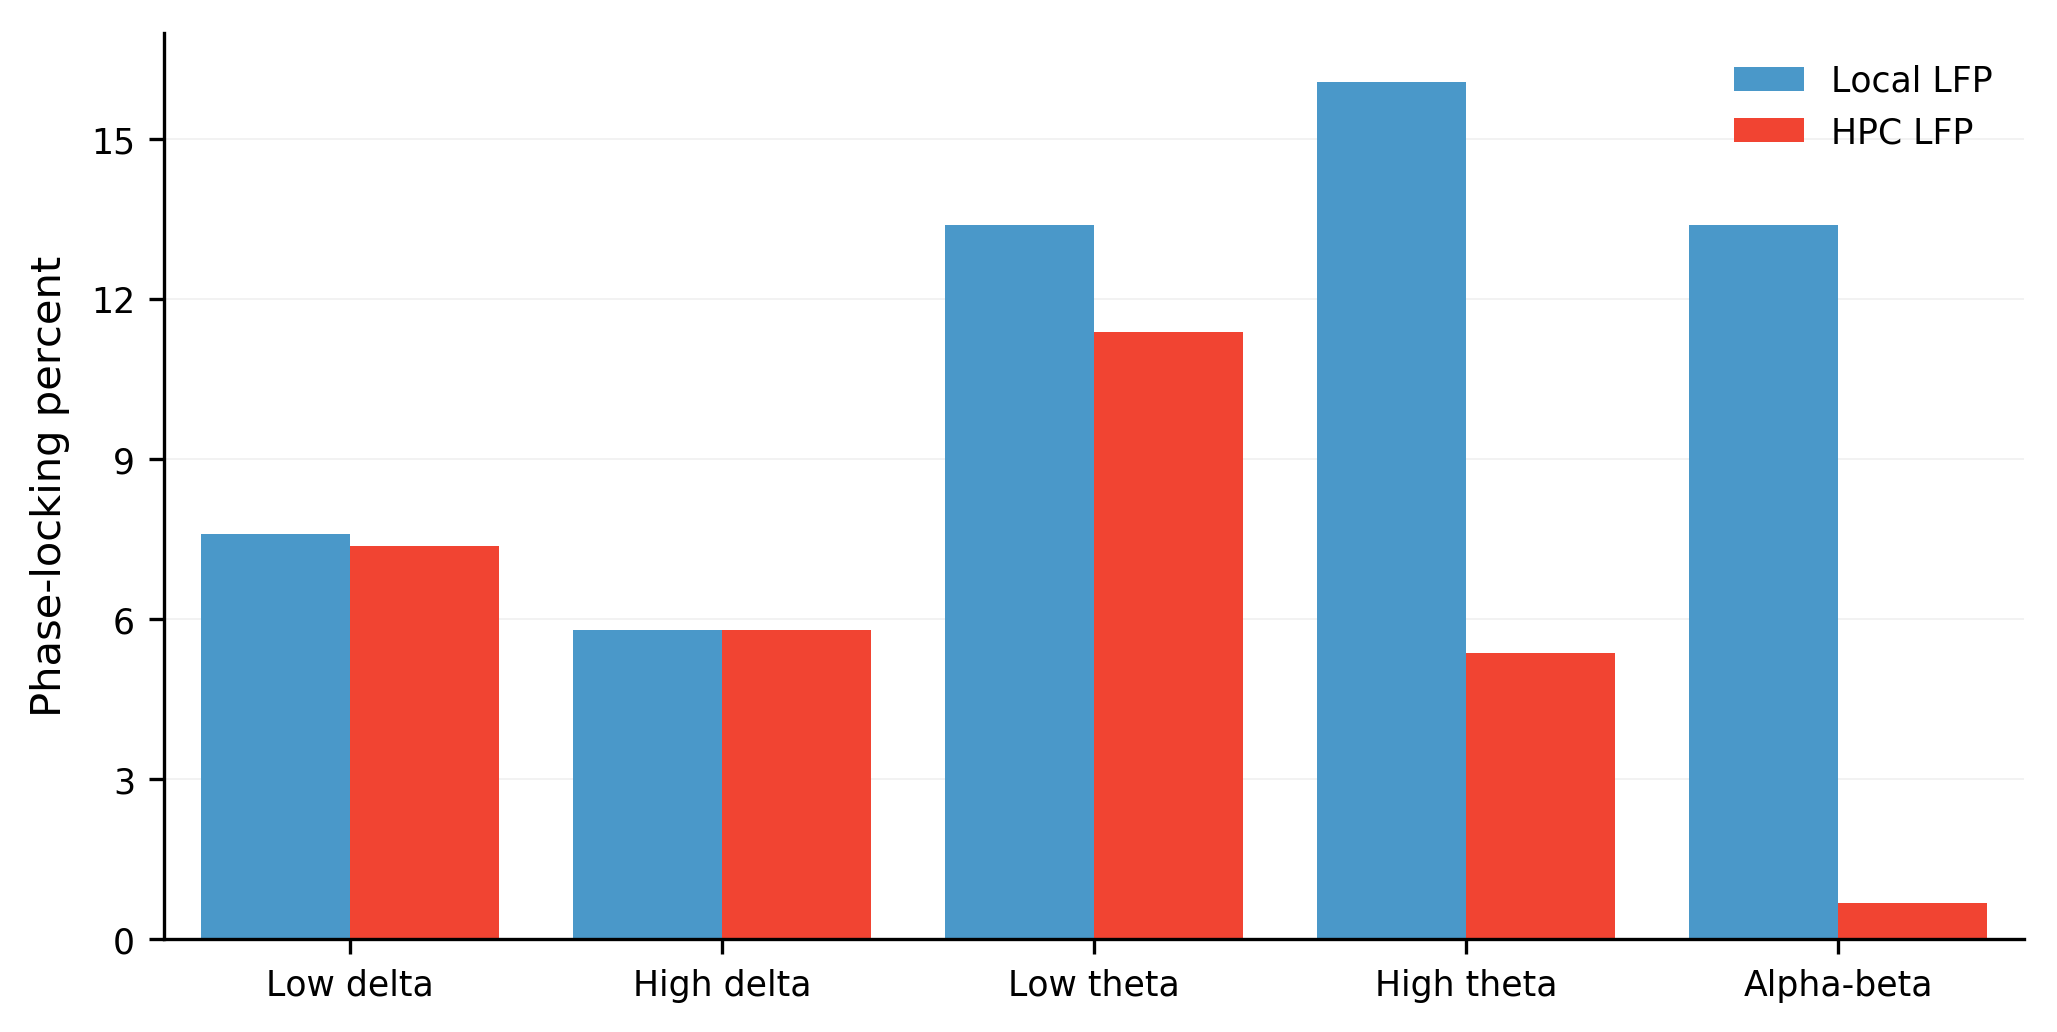

In [1380]:
df = upl_df.query("(sig==True) & (unit_roi2!='hpc')").groupby(['lfp_is_hpc', 'locked_band']).size().reset_index().rename(columns={0: 'n_units'})
# df['pct'] = 0
# df.loc[df.lfp_is_hpc==0, 'pct'] = df.loc[df.lfp_is_hpc==0, 'n_units'] / df[df.lfp_is_hpc==0].n_units.sum()
# df.loc[df.lfp_is_hpc==1, 'pct'] = df.loc[df.lfp_is_hpc==1, 'n_units'] / df[df.lfp_is_hpc==1].n_units.sum()
df['pct'] = df.n_units / len(units['all'])

fig, ax = plt.subplots(1, 1, figsize=(8, 4), dpi=300)
ax = np.ravel(ax)

sns.barplot(x='locked_band', y='pct', data=df, hue='lfp_is_hpc', palette=colors, saturation=100, ax=ax[0])
ax[0].set_xticklabels(bands_fancy2.values())
ax[0].set_xlabel('')
ax[0].set_ylim([0, 0.17])
ax[0].set_yticks([0, 0.03, 0.06, 0.09, 0.12, 0.15])
ax[0].set_yticklabels([0, 3, 6, 9, 12, 15])
ax[0].set_ylabel('Phase-locking percent', fontsize=10, labelpad=5)
legend = plt.legend()
legend.get_texts()[0].set_text('Local LFP')
legend.get_texts()[1].set_text('HPC LFP')

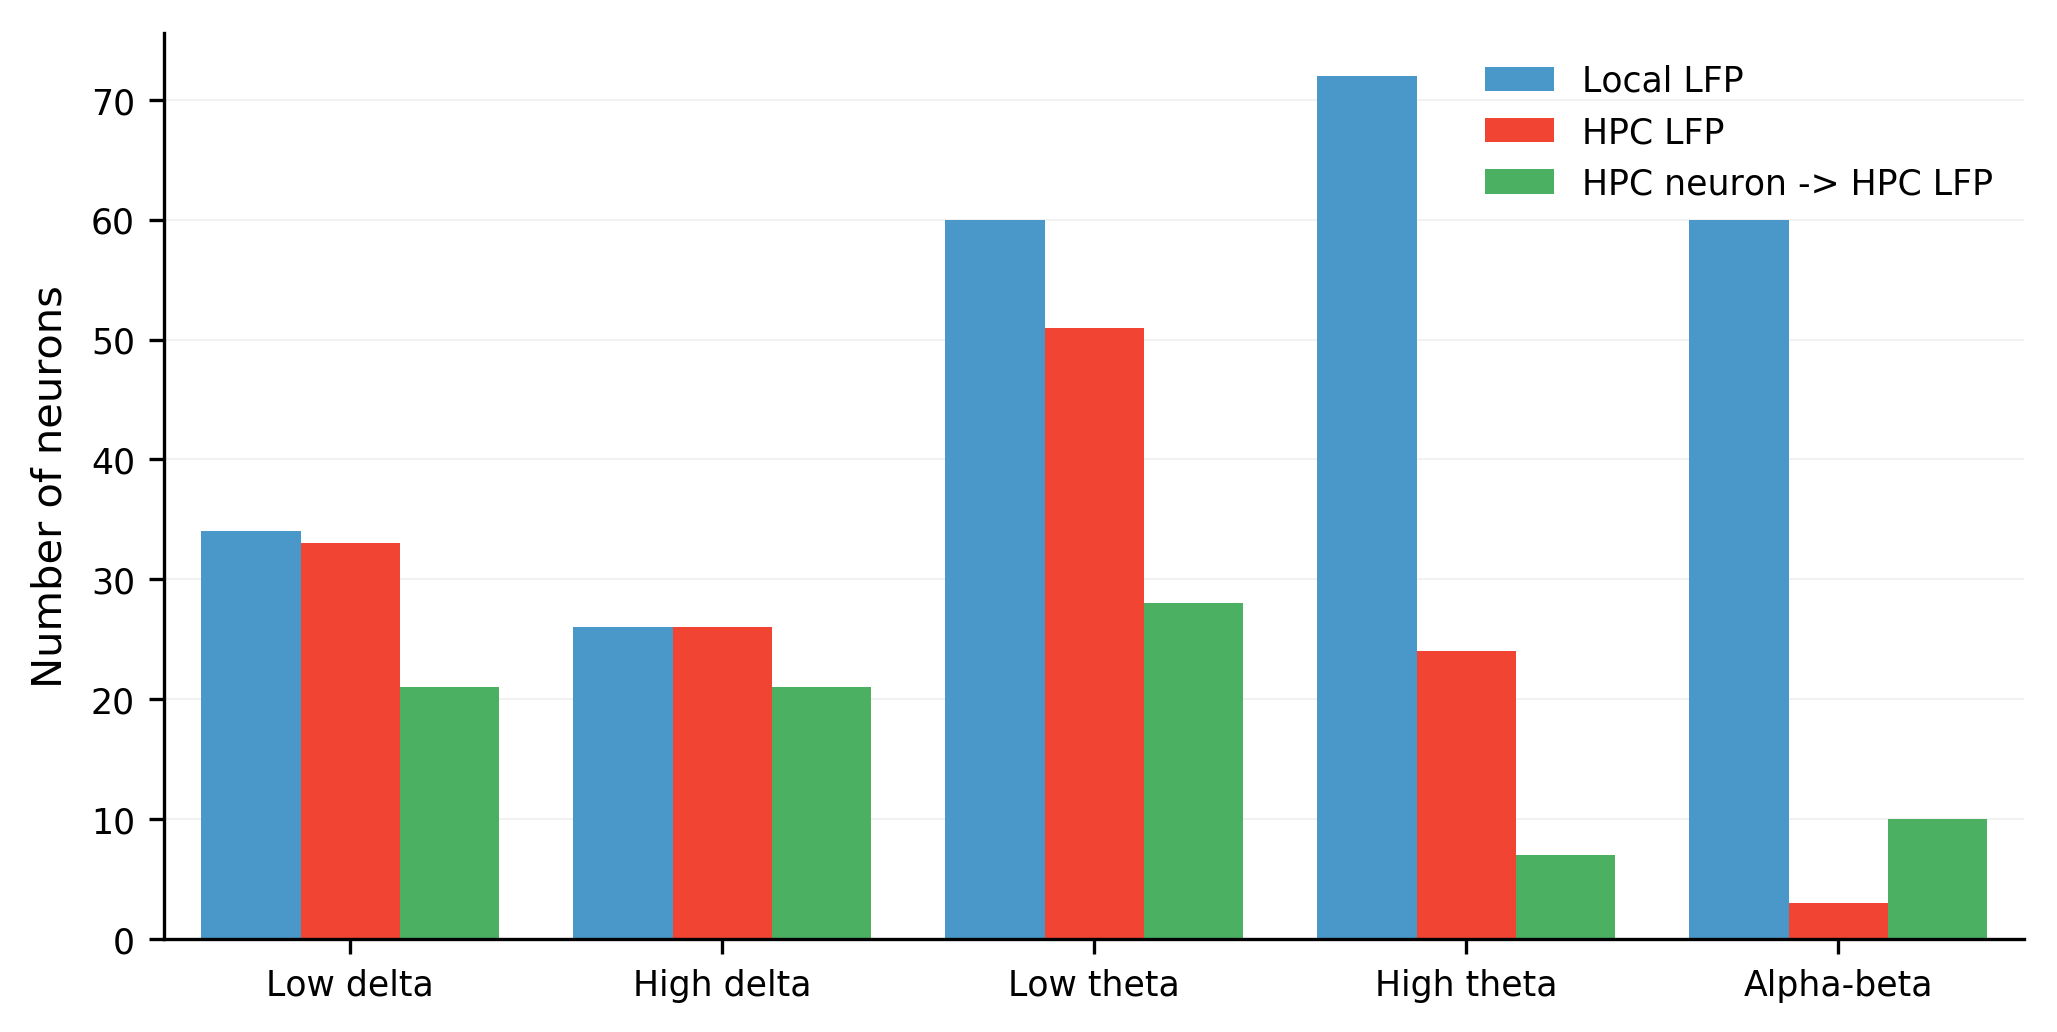

In [949]:
df = upl_df.query("(sig==True)").copy()
df['cat'] = df.lfp_is_hpc
df.loc[df.unit_roi2=='hpc', 'cat'] = 2
df = df.groupby(['cat', 'locked_band']).size().reset_index().rename(columns={0: 'n_units'})
df['pct'] = 0
for i in range(3):
    df.loc[df.cat==i, 'pct'] = df.loc[df.cat==i, 'n_units'] / df[df.cat==i].n_units.sum()

fig, ax = plt.subplots(1, 1, figsize=(8, 4), dpi=300)
ax = np.ravel(ax)

sns.barplot(x='locked_band', y='n_units', data=df, hue='cat', palette=colors, saturation=100, ax=ax[0])
ax[0].set_xticklabels(bands_fancy2.values())
ax[0].set_xlabel('')
ax[0].set_ylabel('Number of neurons', fontsize=10, labelpad=5)
legend = plt.legend()
legend.get_texts()[0].set_text('Local LFP')
legend.get_texts()[1].set_text('HPC LFP')
legend.get_texts()[2].set_text('HPC neuron -> HPC LFP')

In [219]:
# Extra-hippocampal units are phase-locked to which bands, by region?
upl_df.query("(sig==True)").groupby(['lfp_is_hpc', 'unit_roi2', 'locked_band']).size().unstack().fillna(0).astype(int)

locked_band           sub_delta  delta  low_theta  high_theta  alpha_beta
lfp_is_hpc unit_roi2                                                     
0          amy               16     10         22          12          17
           ec                 6      3          7           9           5
           phg                8      4          9          10           5
           ctx                4      9         22          41          33
1          hpc               21     21         28           7          10
           amy               21     13         30           8           3
           ec                 1      5         10          10           0
           phg                5      3          2           2           0
           ctx                6      5          9           4           0

## Local x HPC phase-locking interactions

In [940]:
# What percent of neurons are phase-locked to the local LFP only,
# HPC LFP only, or both local and HPC LFPs?
df = (upl_df
      .query("(unit_roi2!='hpc')")
      .groupby(['subj_sess_unit', 'lfp_is_hpc'])
      .agg({'sig': lambda x: x * 1,
            'locked_mrl': lambda x: x * 1})
      .unstack())
df.columns = df.columns.map(lambda x: ''.join([*map(str, x)]))
df = df.reset_index().rename(columns={'sig0': 'local_sig', 
                                      'sig1': 'hpc_sig', 
                                      'locked_mrl0': 'local_mrl', 
                                      'locked_mrl1': 'hpc_mrl'})
df['sig_type'] = ''
df.loc[(df.local_sig==1) & (df.hpc_sig==1), 'sig_type'] = 'both'
df.loc[(df.local_sig==0) & (df.hpc_sig==0), 'sig_type'] = 'neither'
df.loc[(df.local_sig==1) & (df.hpc_sig==0), 'sig_type'] = 'local'
df.loc[(df.local_sig==0) & (df.hpc_sig==1), 'sig_type'] = 'hpc'

units = OrderedDict()
for sig_type in ['neither', 'local', 'hpc', 'both']:
    units[sig_type] = df.loc[df.sig_type==sig_type].subj_sess_unit.tolist()
units['all'] = df.subj_sess_unit.tolist()

counts = df.groupby('sig_type').size().reset_index().rename(columns={0: 'n'})
counts['pct'] = counts.n / counts.n.sum()
counts = counts.loc[counts.sig_type!='neither']
counts['sig_type'] = counts.sig_type.astype('category').cat.reorder_categories(['local', 'hpc', 'both'], ordered=True)

df = df.query("sig_type!='neither'")
df['sig_type'] = df.sig_type.astype('category').cat.reorder_categories(['local', 'hpc', 'both'], ordered=True)

SpearmanrResult(correlation=0.31847082734049503, pvalue=2.782228954801604e-08)

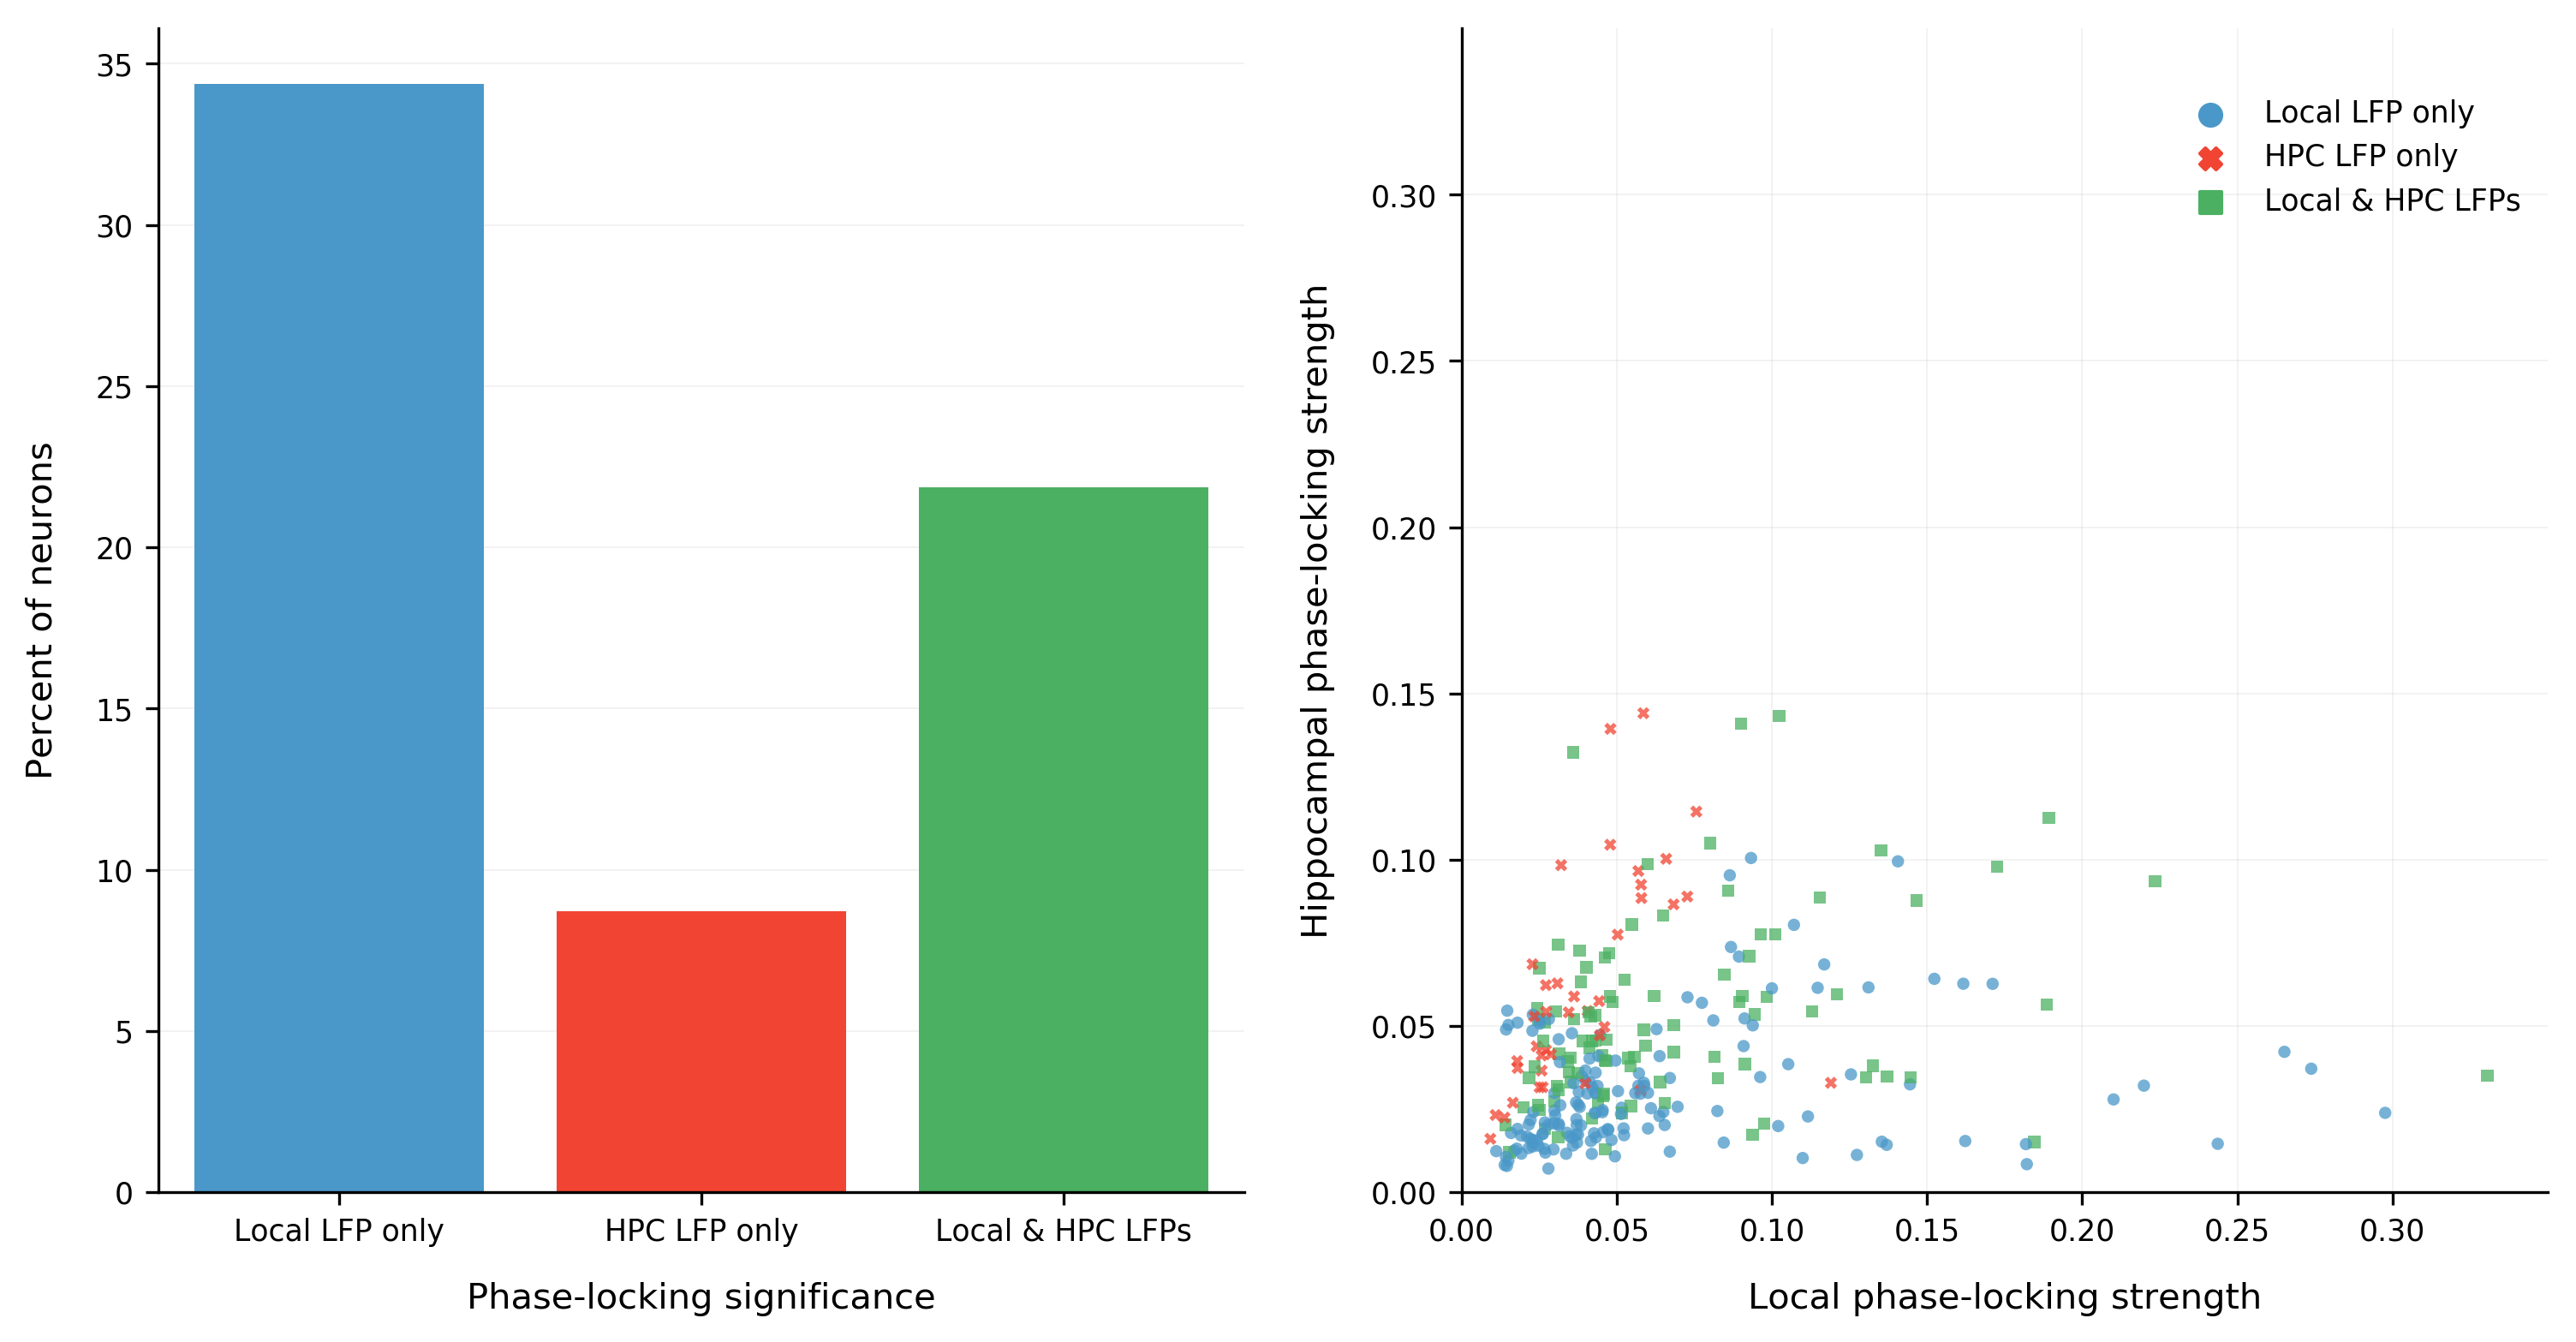

In [941]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6), dpi=300)
ax = np.ravel(ax)

sns.barplot(x='sig_type', y='pct', data=counts.loc[counts.sig_type!='neither'], 
            palette=colors, saturation=100, ax=ax[0])
ax[0].set_xticklabels(['Local LFP only', 'HPC LFP only', 'Local & HPC LFPs'])
ax[0].set_xlabel('Phase-locking significance', fontsize=10, labelpad=10)
ax[0].set_yticks(np.arange(0, 0.36, 0.05))
ax[0].set_yticklabels(np.arange(0, 36, 5))
ax[0].set_ylabel('Percent of neurons', fontsize=10, labelpad=10)

sns.scatterplot(x=df.query("sig_type!='neither'").local_mrl, 
                y=df.query("sig_type!='neither'").hpc_mrl, 
                hue=df.query("sig_type!='neither'").sig_type, 
                style=df.query("sig_type!='neither'").sig_type,
                linewidth=0, alpha=0.75, s=12, palette=colors[:3], ax=ax[1])
ax[1].set_xlim([0, 0.35])
ax[1].set_xticks(np.arange(0, .35, .05))
ax[1].set_ylim([0, 0.35])
ax[1].set_yticks(np.arange(0, .35, .05))

ax[1].set_xlabel('Local phase-locking strength', fontsize=10, labelpad=10)
ax[1].set_ylabel('Hippocampal phase-locking strength', fontsize=10, labelpad=10)

legend = plt.legend()
legend.get_texts()[0].set_text('')
legend.get_texts()[1].set_text('Local LFP only')
legend.get_texts()[2].set_text('HPC LFP only')
legend.get_texts()[3].set_text('Local & HPC LFPs')

stats.spearmanr(df.local_mrl, df.hpc_mrl)

In [942]:
# What is the mean MRL and mean FR of extra-hippocampal units 
# that are phase-locked to local and HPC LFPs?
(upl_df
 .query("(unit_roi2!='hpc')")
 .groupby(['sig', 'lfp_is_hpc'])
 .agg({'subj_sess_unit': len, 
       'locked_mrl': [np.mean, np.median, np.std], 
       'unit_fr': [np.mean, np.median, np.std]}))

subj_sess_unit locked_mrl                       unit_fr  \
                            len       mean    median       std      mean   
sig   lfp_is_hpc                                                           
False 0                     196   0.042643  0.033830  0.027488  2.752563   
      1                     311   0.036998  0.031994  0.021286  4.260137   
True  0                     252   0.065101  0.045523  0.052934  5.177086   
      1                     137   0.054657  0.047192  0.028919  3.789968   

                                      
                    median       std  
sig   lfp_is_hpc                      
False 0           1.374860  5.317206  
      1           2.220055  5.934441  
True  0           3.313008  5.544125  
      1           2.279619  4.647778

In [914]:
# What is the probability that a neuron that is phase-locked to each
# local frequency band will be phase-locked to the hippocampal LFP?
units_ = OrderedDict()
units_['local_insig'] = upl_df.query("(lfp_is_hpc==False) & (sig==False)").subj_sess_unit.tolist()

results = upl_df.query("(lfp_is_hpc==False) & (sig==True)").groupby('locked_band').subj_sess_unit.apply(lambda x: list(x))
for band_name in band_names:
    units_[band_name] = results[band_name]
    
pcts = []
for key in units_.keys():
    pcts.append([key, 
                 upl_df.query("(lfp_is_hpc==True) & (subj_sess_unit=={})".format(units_[key])).sig.count(),
                 upl_df.query("(lfp_is_hpc==True) & (subj_sess_unit=={})".format(units_[key])).sig.sum(),
                 upl_df.query("(lfp_is_hpc==True) & (subj_sess_unit=={})".format(units_[key])).sig.mean()])
pcts = pd.DataFrame(pcts, columns=['cat', 'n', 'n_sig', 'pct'])
pcts

,cat,n,n_sig,pct
0,local_insig,196,39,0.198980
1,sub_delta,34,21,0.617647
2,delta,26,10,0.384615
3,low_theta,60,28,0.466667
4,high_theta,72,25,0.347222
5,alpha_beta,60,14,0.233333


In [939]:
# Are the observed rates of HPC phase-locking given local 
# phase-locking to each band sig. different from the population rate of HPC phase-locking?
for index, x in pcts.iterrows():
    print(x['cat'], stats.binom_test(x['n_sig'], x['n'], pcts.n_sig.sum()/pcts.n.sum()))

local_insig 0.0010683643868190968
sub_delta 0.0002336073227822395
delta 0.3976716877663612
low_theta 0.010883644247515284
high_theta 0.4446146564436545
alpha_beta 0.2629851772507494


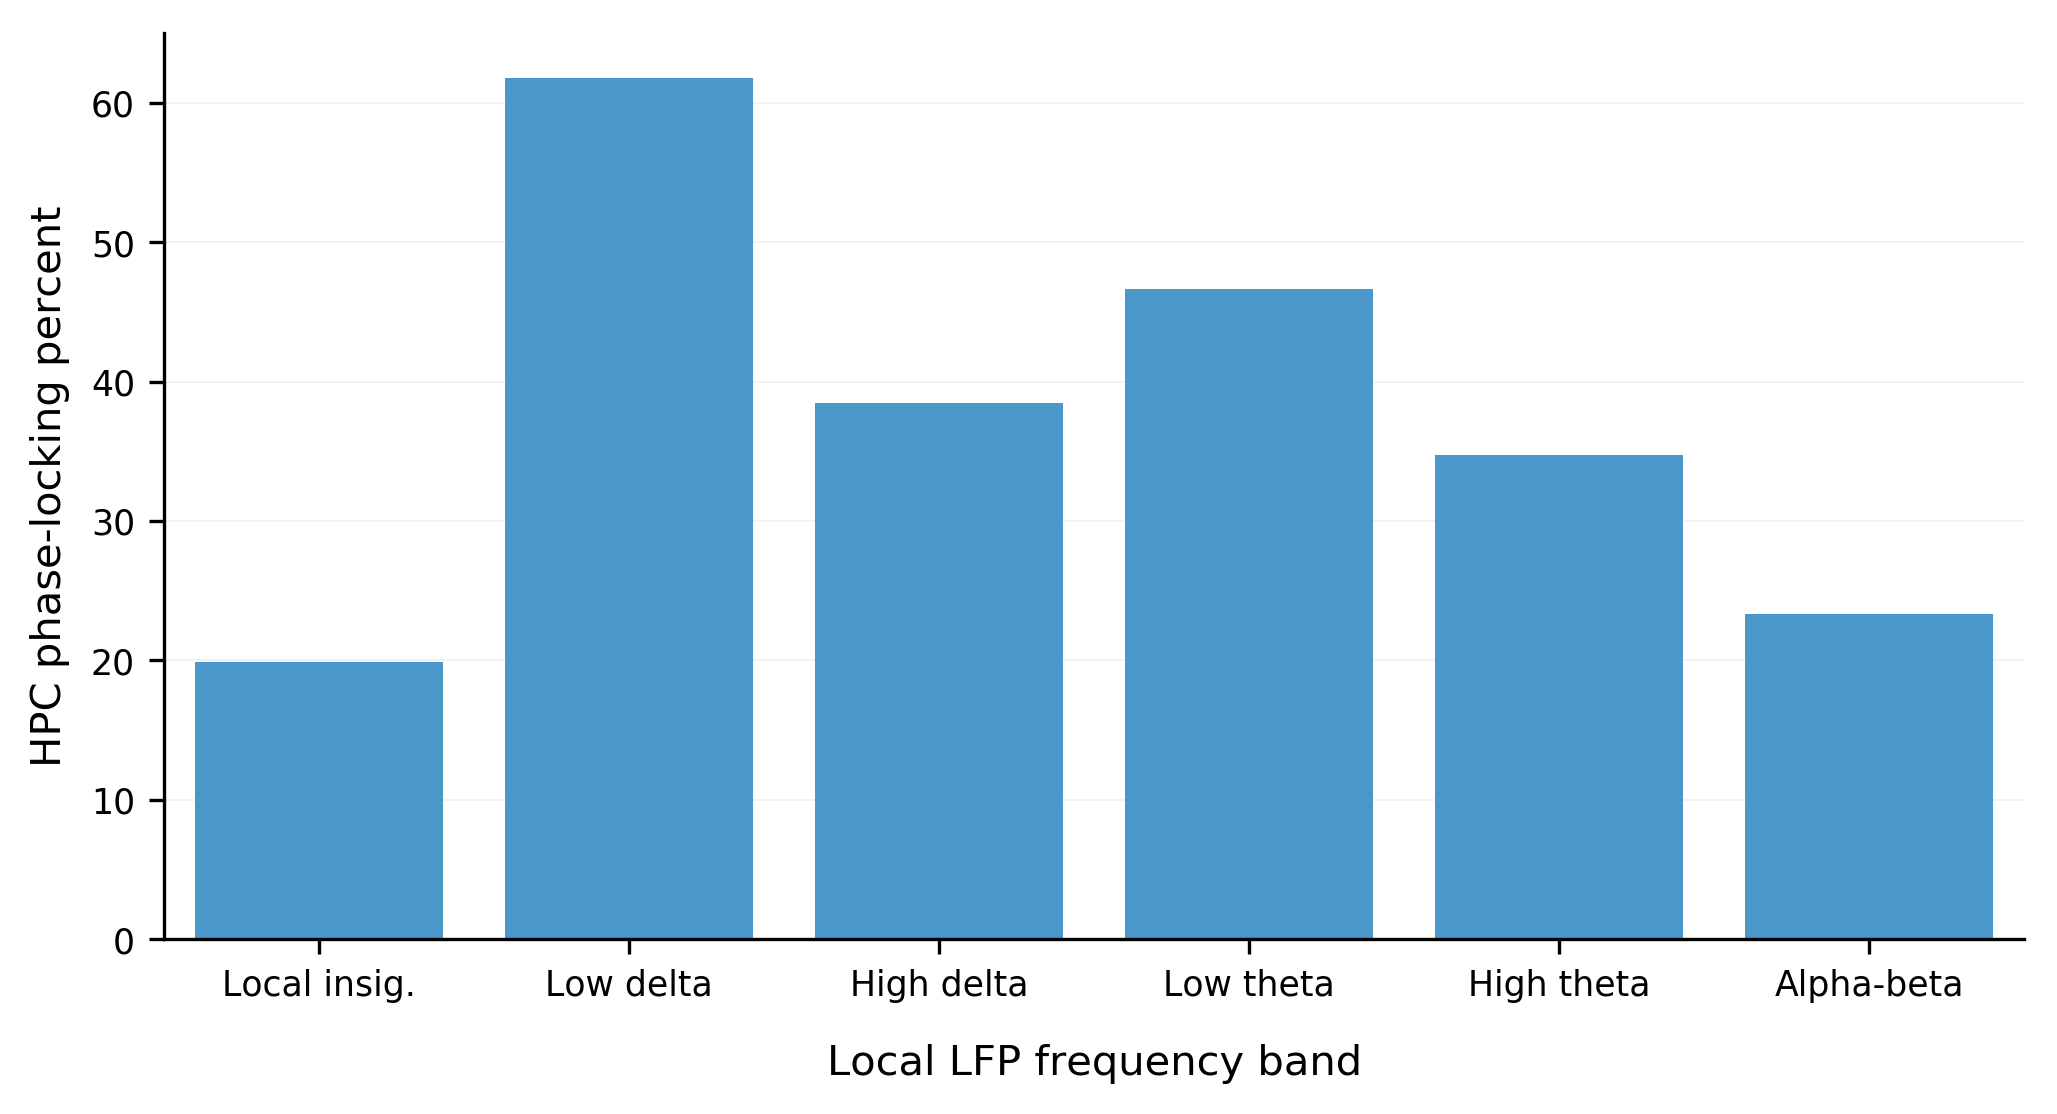

In [915]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4), dpi=300)
ax = np.ravel(ax)

sns.barplot(x='cat', y='pct', data=pcts, color=colors[0], saturation=100, ax=ax[0])
ax[0].set_xticklabels(['Local insig.'] + list(bands_fancy2.values()))
ax[0].set_xlabel('Local LFP frequency band', fontsize=10, labelpad=10)
ax[0].set_ylim([0, 0.65])
ax[0].set_yticks(np.arange(0, 0.65, 0.1))
ax[0].set_yticklabels(np.arange(0, 65, 10))
ax[0].set_ylabel('HPC phase-locking percent', fontsize=10, labelpad=5)
plt.show()

In [943]:
# What is the probability that a neuron that is phase-locked to each
# local frequency band will be phase-locked to the hippocampal LFP?
units_ = OrderedDict()
units_['hpc_insig'] = upl_df.query("(lfp_is_hpc==True) & (unit_roi2!='hpc') & (sig==False)").subj_sess_unit.tolist()

results = upl_df.query("(lfp_is_hpc==True) & (unit_roi2!='hpc') & (sig==True)").groupby('locked_band').subj_sess_unit.apply(lambda x: list(x))
for band_name in band_names:
    units_[band_name] = results[band_name]
    
pcts = []
for key in units_.keys():
    pcts.append([key, 
                 upl_df.query("(lfp_is_hpc==False) & (subj_sess_unit=={})".format(units_[key])).sig.count(),
                 upl_df.query("(lfp_is_hpc==False) & (subj_sess_unit=={})".format(units_[key])).sig.sum(),
                 upl_df.query("(lfp_is_hpc==False) & (subj_sess_unit=={})".format(units_[key])).sig.mean()])
pcts = pd.DataFrame(pcts, columns=['cat', 'n', 'n_sig', 'pct'])
pcts

,cat,n,n_sig,pct
0,hpc_insig,311,154,0.495177
1,sub_delta,33,25,0.757576
2,delta,26,17,0.653846
3,low_theta,51,35,0.686275
4,high_theta,24,18,0.750000
5,alpha_beta,3,3,1.000000


In [944]:
# Are the observed rates of HPC phase-locking given local 
# phase-locking to each band sig. different from the population rate of HPC phase-locking?
for index, x in pcts.iterrows():
    print(x['cat'], stats.binom_test(x['n_sig'], x['n'], pcts.n_sig.sum()/pcts.n.sum()))

hpc_insig 0.018976791159532727
sub_delta 0.03358650566578378
delta 0.43077447384619016
low_theta 0.08976988222549268
high_theta 0.06729424222346073
alpha_beta 0.26171875


In [224]:
upl_df.query("(lfp_is_hpc==False) & (sig==True)").groupby('locked_band').agg({'subj_sess_unit': len, 'unit_fr': np.mean})

,subj_sess_unit,unit_fr
locked_band,,
sub_delta,34,2.504897
delta,26,4.831760
low_theta,60,4.733514
high_theta,72,6.208018
alpha_beta,60,6.047422


In [226]:
upl_df.query("(lfp_is_hpc==True) & (unit_roi2!='hpc') & (sig==True)").groupby('locked_band').agg({'subj_sess_unit': len, 'unit_fr': np.mean})

,subj_sess_unit,unit_fr
locked_band,,
sub_delta,33,3.407424
delta,26,3.100257
low_theta,51,4.366428
high_theta,24,3.772900
alpha_beta,3,4.312158


## Phase-locking frequency: local vs. HPC

In [503]:
# Among units phase-locked to both local and HPC LFPs,
# is the hippocampal band lower, the same, or higher
# than the local band, and is there a group-level difference
# in local vs HPC phase-lock frequency (Wilcoxon signed-rank)?
df = (upl_df
      .query("(subj_sess_unit=={})".format(pl2_units))
      .groupby(['subj_sess_unit', 'lfp_is_hpc'])
      .mrl_argmax.apply(int)
      .unstack()
      .rename(columns={0: 'local', 1: 'hpc'}))
df['vs'] = np.sign(df['hpc'] - df['local'])
ind, dat = np.unique(df.vs, return_counts=True)
counts = pd.DataFrame(index=ind, data=dat).reset_index().rename(columns={'index': 'cat', 0: 'count'})
m = df.groupby(['local', 'hpc']).size().unstack().fillna(0)

print(counts)
stats.wilcoxon(df.hpc, df.local)

lfp_is_hpc,local,hpc,vs
subj_sess_unit,,,
U369_env1_0,3,3,0
U369_env1_1,2,2,0
U369_env1_14,3,3,0
U369_env1_20,2,1,-1
U369_env1_23,2,1,-1


hpc,0,1,2,3,4
local,,,,,
0,7.0,7.0,4.0,3.0,0.0
1,6.0,1.0,1.0,0.0,2.0
2,5.0,6.0,13.0,4.0,0.0
3,3.0,2.0,11.0,8.0,1.0
4,4.0,1.0,6.0,3.0,0.0


(array([-1,  0,  1]), array([47, 29, 22]))
   cat  count
0   -1     47
1    0     29
2    1     22


WilcoxonResult(statistic=757.0, pvalue=0.005760192650218276)

Signed-rank test for HPC vs. local frequency band: WilcoxonResult(statistic=757.0, pvalue=0.005760192650218276)
Binomial test for HPC=Local obs. vs. chance: pvalue=0.11504222678939782


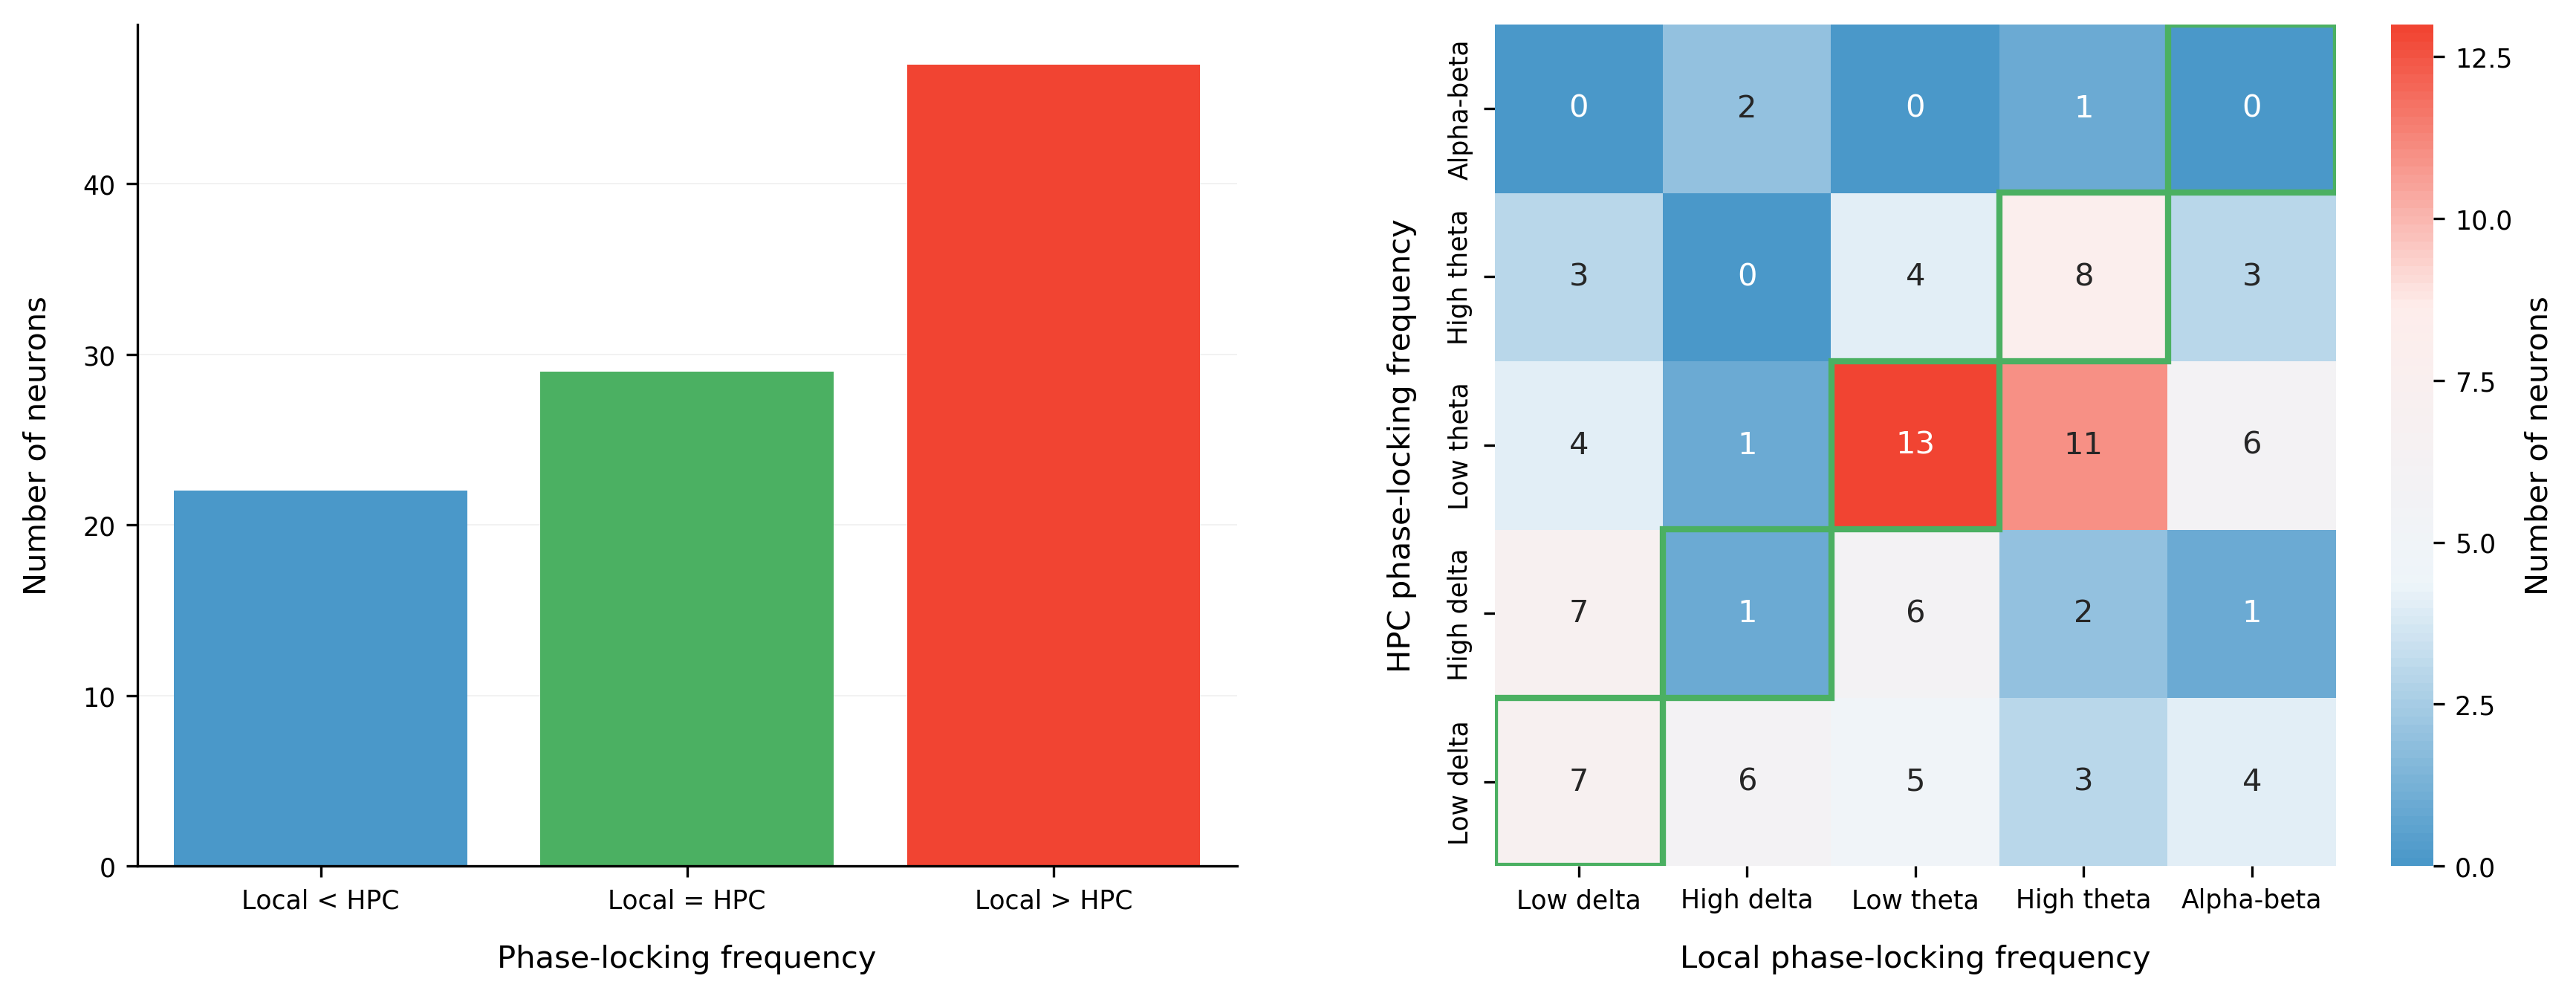

In [879]:
# Among units phase-locked to both local and HPC LFPs,
# is the hippocampal band lower, the same, or higher
# than the local band, and is there a group-level difference
# in local vs HPC phase-lock frequency (Wilcoxon signed-rank)?
df = (upl_df
      .query("(subj_sess_unit=={})".format(pl2_units))
      .groupby(['subj_sess_unit', 'lfp_is_hpc'])
      .mrl_argmax.apply(int)
      .unstack()
      .rename(columns={0: 'local', 1: 'hpc'}))
df['vs'] = np.sign(df['hpc'] - df['local'])
ind, dat = np.unique(df.vs, return_counts=True)
counts = pd.DataFrame(index=ind, data=dat).reset_index().rename(columns={'index': 'cat', 0: 'count'})
m = df.groupby(['local', 'hpc']).size().unstack().fillna(0)
print('Signed-rank test for HPC vs. local frequency band:', stats.wilcoxon(df.hpc, df.local))

# Do hippocampal and local phase-locking frequencies coincide above chance?
exp_rate = np.sum(((df.groupby(['local']).size()) / len(df)) * 
                   (df.groupby(['hpc']).size() / len(df)))
print('Binomial test for HPC=Local obs. vs. chance: pvalue=', 
      stats.binom_test(np.sum(df.hpc==df.local), n=len(df), p=exp_rate), sep='')

# Plot.
fig, ax = plt.subplots(1, 2, figsize=(14, 5), dpi=300)
ax = np.ravel(ax)

sns.barplot(x='cat', y='count', data=counts, order=[1, 0, -1], 
            palette=(colors[0], colors[2], colors[1]), saturation=100, ax=ax[0])
ax[0].set_xticklabels(['Local < HPC', 'Local = HPC', 'Local > HPC'])
ax[0].set_xlabel('Phase-locking frequency', fontsize=10, labelpad=10)
ax[0].set_ylabel('Number of neurons', fontsize=10, labelpad=10)

sns.heatmap(m.T, annot=True, ax=ax[1], cmap=cmap, square=True)

# ax[1].plot([0, 3.97], np.ones(2) * 4.98, '-', color=colors[0], linewidth=2) # horizontal
# ax[1].plot(np.ones(2) * 0.02, [1.03, 5], '-', color=colors[0], linewidth=2) # vertical
# ax[1].plot([1.03, 5], np.ones(2) * 0.02, '-', color=colors[1], linewidth=2) # horizontal
# ax[1].plot(np.ones(2) * 4.98, [0, 3.97], '-', color=colors[1], linewidth=2) # vertical
for i in range(5):
#     ax[1].plot([i, i+0.97], np.ones(2) * (i+1.03), '-', color=colors[0], linewidth=2) # horizontal
#     ax[1].plot(np.ones(2) * (i+0.97), [i+1.03, i+2.03], '-', color=colors[0], linewidth=2) # vertical
#     ax[1].plot([i+1.03, i+2], np.ones(2) * (i+0.97), '-', color=colors[1], linewidth=2) # horizontal
#     ax[1].plot(np.ones(2) * (i+1.03), [i-0.03, i+0.97], '-', color=colors[1], linewidth=2) # vertical
    ax[1].add_patch(patches.Rectangle((i, i), 1, 1, linewidth=2, edgecolor=colors[2], facecolor='none'))

ax[1].set_xticklabels(bands_fancy2.values(), ha='center')
ax[1].set_yticklabels(bands_fancy2.values(), va='center')
ax[1].set_xlabel('Local phase-locking frequency', fontsize=10, labelpad=10)
ax[1].set_ylabel('HPC phase-locking frequency', fontsize=10, labelpad=10)
ax[1].invert_yaxis()
cbar = ax[1].collections[0].colorbar
cbar.set_label('Number of neurons', fontsize=10)

## Phase-locking strength by firing rate, power relations

In [1227]:
upl_df_ = upl_df.copy()

In [980]:
files = glob(os.path.join('/scratch/dscho/unit_activity_and_hpc_theta/data/crosselec_phase_locking', 
                          '*_crosselec_phaselock_byunit_df_fr_power_diffs_notch60-120_nospikeinterp_phase-extrema2_nomask_1000bootstraps2_hpc-subset_bands--sub_delta0.5-2--delta1-4--low_theta2-8--high_theta4-16--alpha_beta8-32.pkl'))
print('Found {} files'.format(len(files)))

df = dio.open_pickle(files[0])
for f in files[1:]:
    df = df.append(dio.open_pickle(f))
cols = ['subj_sess_unit', 'lfp_is_hpc'] + [col for col in df.columns if col not in upl_df.columns]
upl_df = pd.merge(upl_df, df[cols], how='left', on=['subj_sess_unit', 'lfp_is_hpc'])

files = glob(os.path.join('/scratch/dscho/unit_activity_and_hpc_theta/data/crosselec_phase_locking', 
                          '*_crosselec_phaselock_byunit_df_fr_power_bins_notch60-120_nospikeinterp_phase-extrema2_nomask_4bins_hpc-subset_bands--sub_delta0.5-2--delta1-4--low_theta2-8--high_theta4-16--alpha_beta8-32.pkl'))
print('Found {} files'.format(len(files)))

df = dio.open_pickle(files[0])
for f in files[1:]:
    df = df.append(dio.open_pickle(f))
cols = ['subj_sess_unit', 'lfp_is_hpc'] + [col for col in df.columns if col not in upl_df.columns]
upl_df = pd.merge(upl_df, df[cols], how='left', on=['subj_sess_unit', 'lfp_is_hpc'])

upl_df['pl_diffs_fr_sig'] = upl_df.pl_diffs_fr_sig * 1
upl_df['pl_diffs_pow_locked_sig'] = upl_df.pl_diffs_pow_locked_sig * 1
upl_df['pl_diffs_pow_nonlocked_sig'] = upl_df.pl_diffs_pow_nonlocked_sig * 1

Found 14 files
Found 14 files


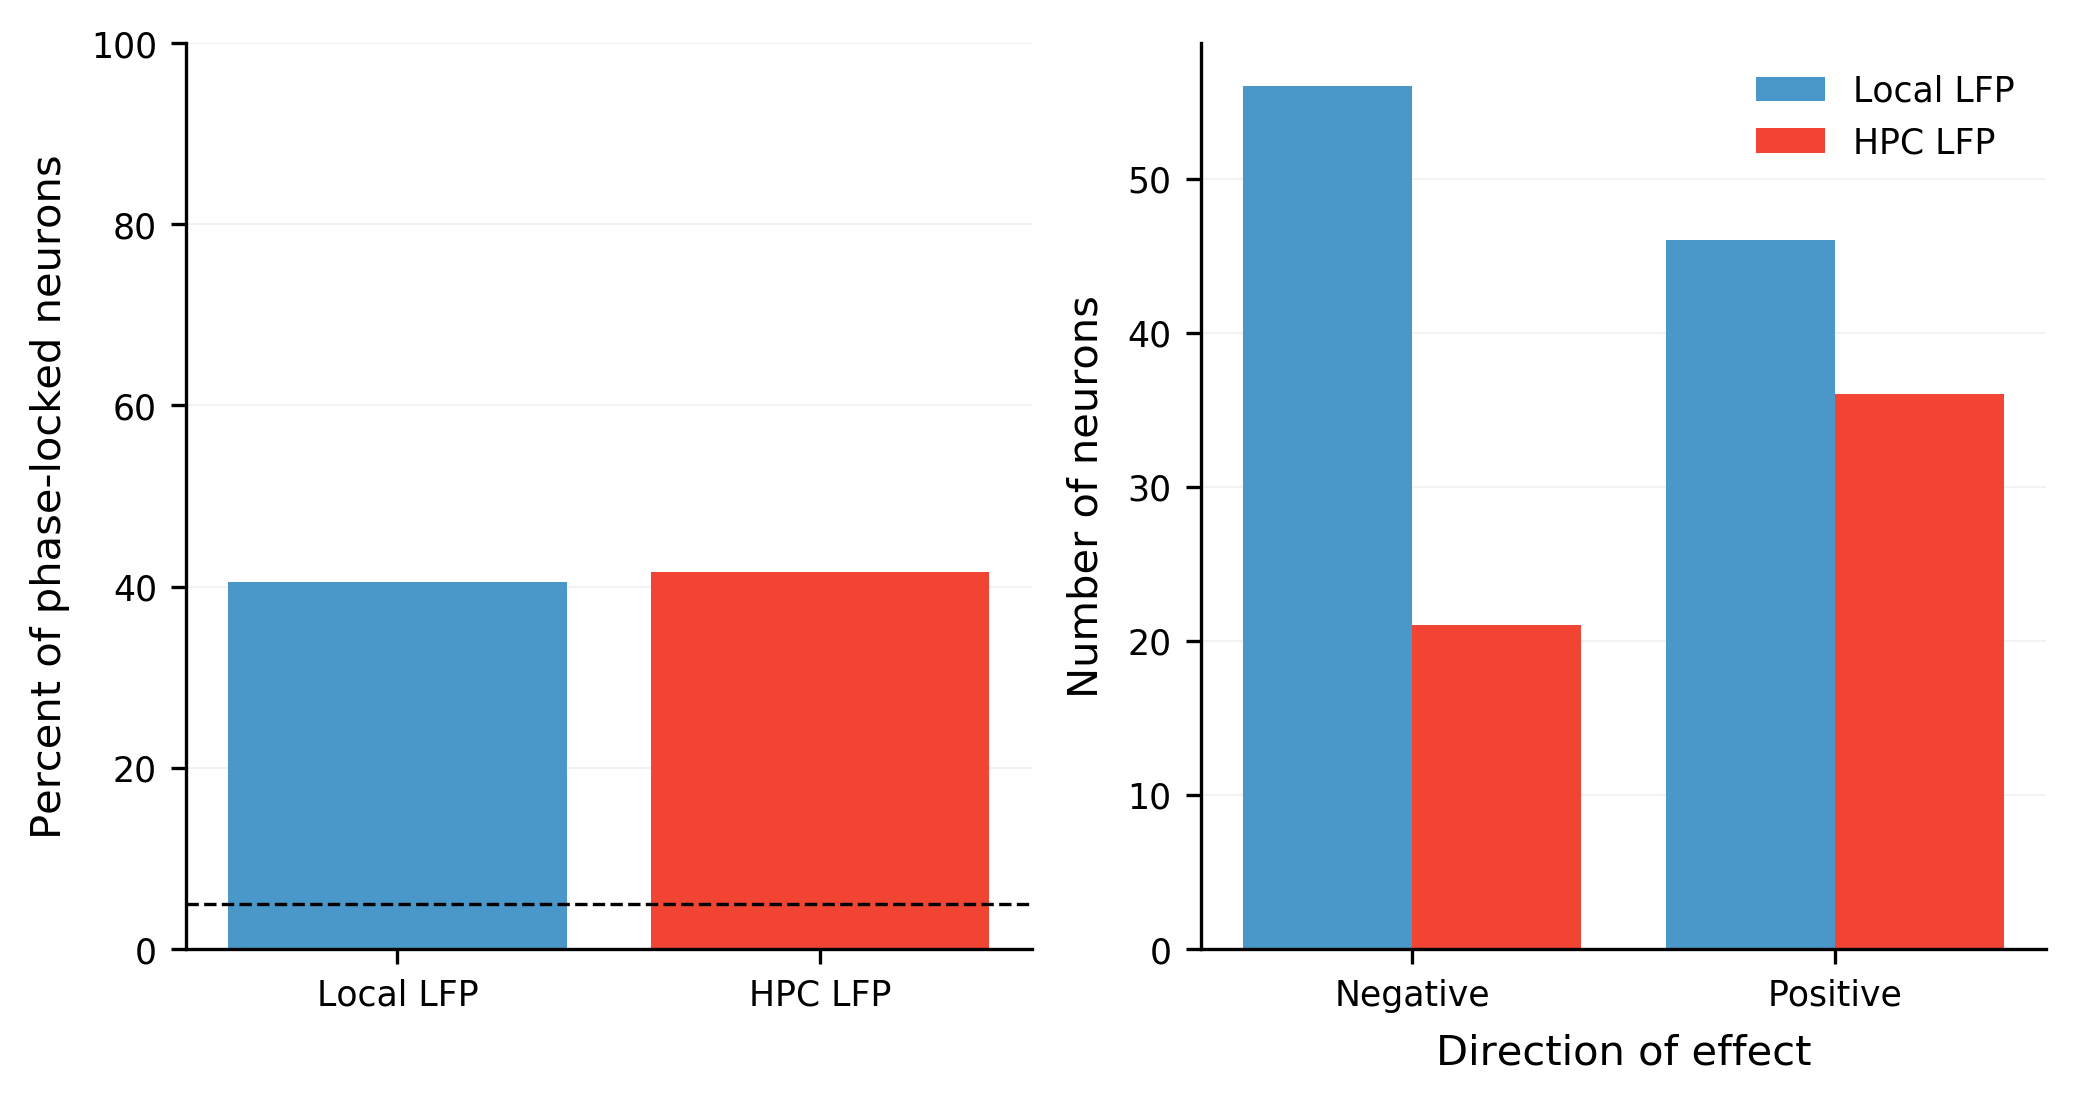

In [1129]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4), dpi=300)
ax = np.ravel(ax)

# Subplot 1
# -----------------------
df = (upl_df
      .query("(sig==True) & (unit_roi2!='hpc')")
      .groupby(['lfp_is_hpc'])
      .agg({'subj_sess_unit': len,
            'pl_diffs_fr_sig': lambda x: np.mean(x)})
      .reset_index())
sns.barplot(x='lfp_is_hpc', y='pl_diffs_fr_sig', data=df, palette=colors, saturation=100, ax=ax[0])
ax[0].axhline(y=0.05, color='k', linestyle='--')
ax[0].set_xticklabels(['Local LFP', 'HPC LFP'])
ax[0].set_ylim([0, 1])
ax[0].set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
ax[0].set_yticklabels([0, 20, 40, 60, 80, 100])
ax[0].set_xlabel('')
ax[0].set_ylabel('Percent of phase-locked neurons', fontsize=10, labelpad=5)
#ax[0].set_title('Phase-locking strength ~ firing rate', fontsize=12, y=1.05)

# Subplot 2
# -----------------------
df = (upl_df
      .query("(sig==True) & (unit_roi2!='hpc') & (pl_diffs_fr_sig==True)")
      .groupby(['lfp_is_hpc', 'pl_diffs_fr_sign'])
      .agg({'subj_sess_unit': len})
      .reset_index())
sns.barplot(x='pl_diffs_fr_sign', y='subj_sess_unit', hue='lfp_is_hpc', data=df, palette=colors, saturation=100, ax=ax[1])
ax[1].set_xticklabels(['Negative', 'Positive'])
ax[1].set_xlabel('Direction of effect', fontsize=10, labelpad=5)
ax[1].set_ylabel('Number of neurons', fontsize=10, labelpad=5)
legend = ax[1].legend()
legend.get_texts()[0].set_text('Local LFP')
legend.get_texts()[1].set_text('HPC LFP')

plt.show()

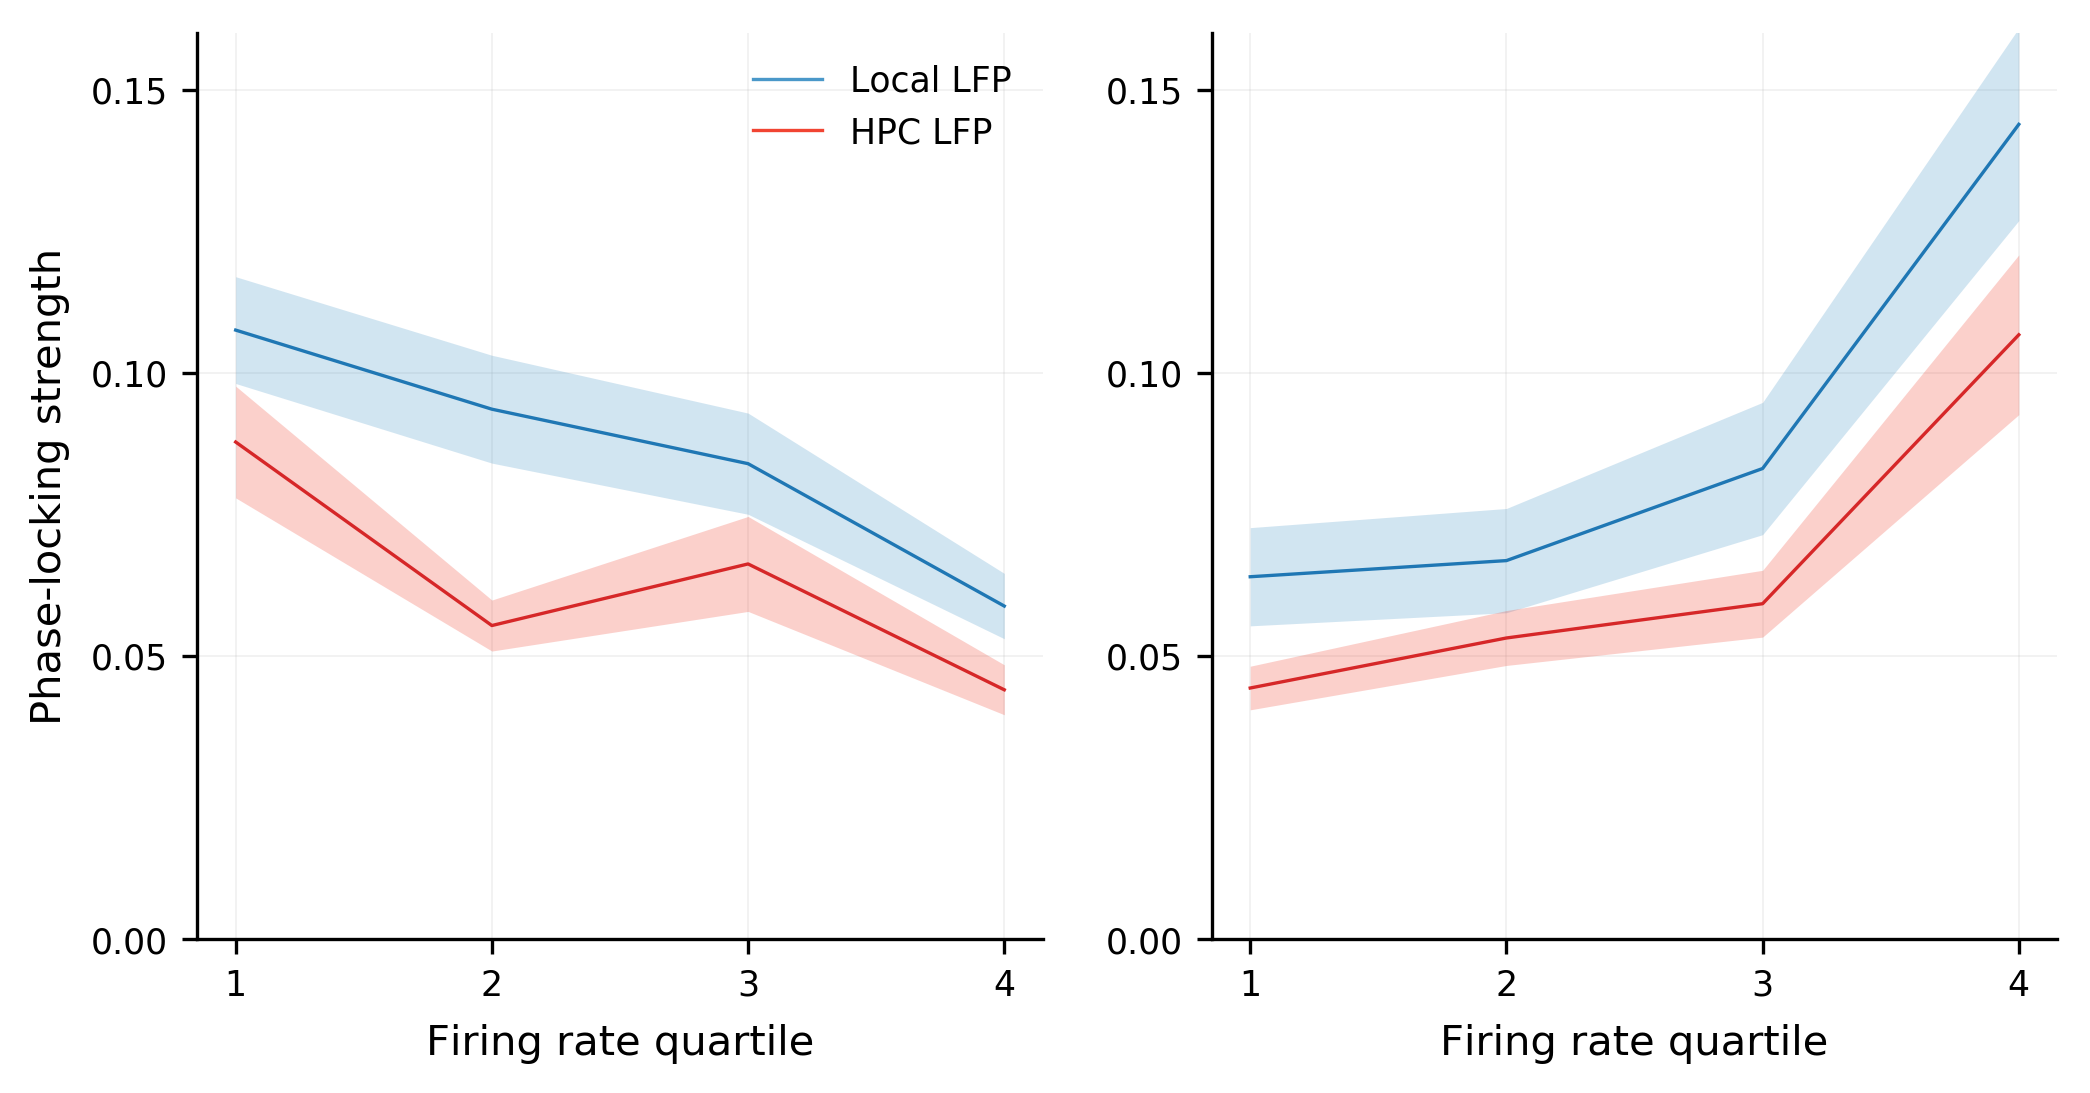

In [1128]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4), dpi=300)
ax = np.ravel(ax)

df = (upl_df
      .query("(sig==True) & (unit_roi2!='hpc') & (pl_diffs_fr_sig==True)")
      .groupby(['lfp_is_hpc', 'pl_diffs_fr_sign'])
      .pl_bins_fr.apply(lambda x: np.array(x))
      .reset_index())
df['pl_bins_fr'] = df.pl_bins_fr.apply(lambda x: np.array(list(x)))
df['pl_bins_fr_mean'] = df.pl_bins_fr.apply(lambda x: np.mean(x, axis=0))
df['pl_bins_fr_sem'] = df.pl_bins_fr.apply(lambda x: stats.sem(x, axis=0))
for i in range(4):
    df['mean_q{}'.format(i)] = df.pl_bins_fr_mean.apply(lambda x: x[i])
    df['sem_q{}'.format(i)] = df.pl_bins_fr_sem.apply(lambda x: x[i])
df = df.drop(columns=['pl_bins_fr', 'pl_bins_fr_mean', 'pl_bins_fr_sem'])
df = df.melt(id_vars=['lfp_is_hpc', 'pl_diffs_fr_sign'])
df['lfp_is_hpc'] = df.lfp_is_hpc.apply(lambda x: 1 * x)

# Subplot 1
# -----------------------
sns.lineplot(x='variable', y='value', hue='lfp_is_hpc',
             data=df.query("(pl_diffs_fr_sign==-1) & (variable==['mean_q0', 'mean_q1', 'mean_q2', 'mean_q3'])"),
             ax=ax[0])
means = np.array(df.query("(lfp_is_hpc==False) & (pl_diffs_fr_sign==-1) & (variable==['mean_q0', 'mean_q1', 'mean_q2', 'mean_q3'])").value.tolist())
sems = np.array(df.query("(lfp_is_hpc==False) & (pl_diffs_fr_sign==-1) & (variable==['sem_q0', 'sem_q1', 'sem_q2', 'sem_q3'])").value.tolist())
ax[0].fill_between(np.arange(4), means - sems,means + sems, color=colors[0], alpha=0.25, linewidth=0)
means = np.array(df.query("(lfp_is_hpc==True) & (pl_diffs_fr_sign==-1) & (variable==['mean_q0', 'mean_q1', 'mean_q2', 'mean_q3'])").value.tolist())
sems = np.array(df.query("(lfp_is_hpc==True) & (pl_diffs_fr_sign==-1) & (variable==['sem_q0', 'sem_q1', 'sem_q2', 'sem_q3'])").value.tolist())
ax[0].fill_between(np.arange(4), means - sems,means + sems, color=colors[1], alpha=0.25, linewidth=0)
ax[0].set_xticklabels(np.arange(1, 5))
ax[0].set_ylim([0, 0.16])
ax[0].set_yticks([0, 0.05, 0.10, 0.15])
ax[0].set_xlabel('Firing rate quartile', fontsize=10, labelpad=5)
ax[0].set_ylabel('Phase-locking strength', fontsize=10, labelpad=5)
custom_lines = [Line2D([0], [0], color=colors[0], label='Local LFP'),
                Line2D([0], [0], color=colors[1], label='HPC LFP')]
legend = ax[0].legend(handles=custom_lines, loc=0)

# Subplot 2
# -----------------------
sns.lineplot(x='variable', y='value', hue='lfp_is_hpc',
             data=df.query("(pl_diffs_fr_sign==1) & (variable==['mean_q0', 'mean_q1', 'mean_q2', 'mean_q3'])"),
             ax=ax[1], legend=False)
means = np.array(df.query("(lfp_is_hpc==False) & (pl_diffs_fr_sign==1) & (variable==['mean_q0', 'mean_q1', 'mean_q2', 'mean_q3'])").value.tolist())
sems = np.array(df.query("(lfp_is_hpc==False) & (pl_diffs_fr_sign==1) & (variable==['sem_q0', 'sem_q1', 'sem_q2', 'sem_q3'])").value.tolist())
ax[1].fill_between(np.arange(4), means - sems,means + sems, color=colors[0], alpha=0.25, linewidth=0)
means = np.array(df.query("(lfp_is_hpc==True) & (pl_diffs_fr_sign==1) & (variable==['mean_q0', 'mean_q1', 'mean_q2', 'mean_q3'])").value.tolist())
sems = np.array(df.query("(lfp_is_hpc==True) & (pl_diffs_fr_sign==1) & (variable==['sem_q0', 'sem_q1', 'sem_q2', 'sem_q3'])").value.tolist())
ax[1].fill_between(np.arange(4), means - sems,means + sems, color=colors[1], alpha=0.25, linewidth=0)
ax[1].set_xticklabels(np.arange(1, 5))
ax[1].set_ylim([0, 0.16])
ax[1].set_yticks([0, 0.05, 0.10, 0.15])
ax[1].set_xlabel('Firing rate quartile', fontsize=10, labelpad=5)
ax[1].set_ylabel('')

plt.show()

/home1/dscho/anaconda3/envs/memlab/lib/python3.6/site-packages/numpy/core/_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)


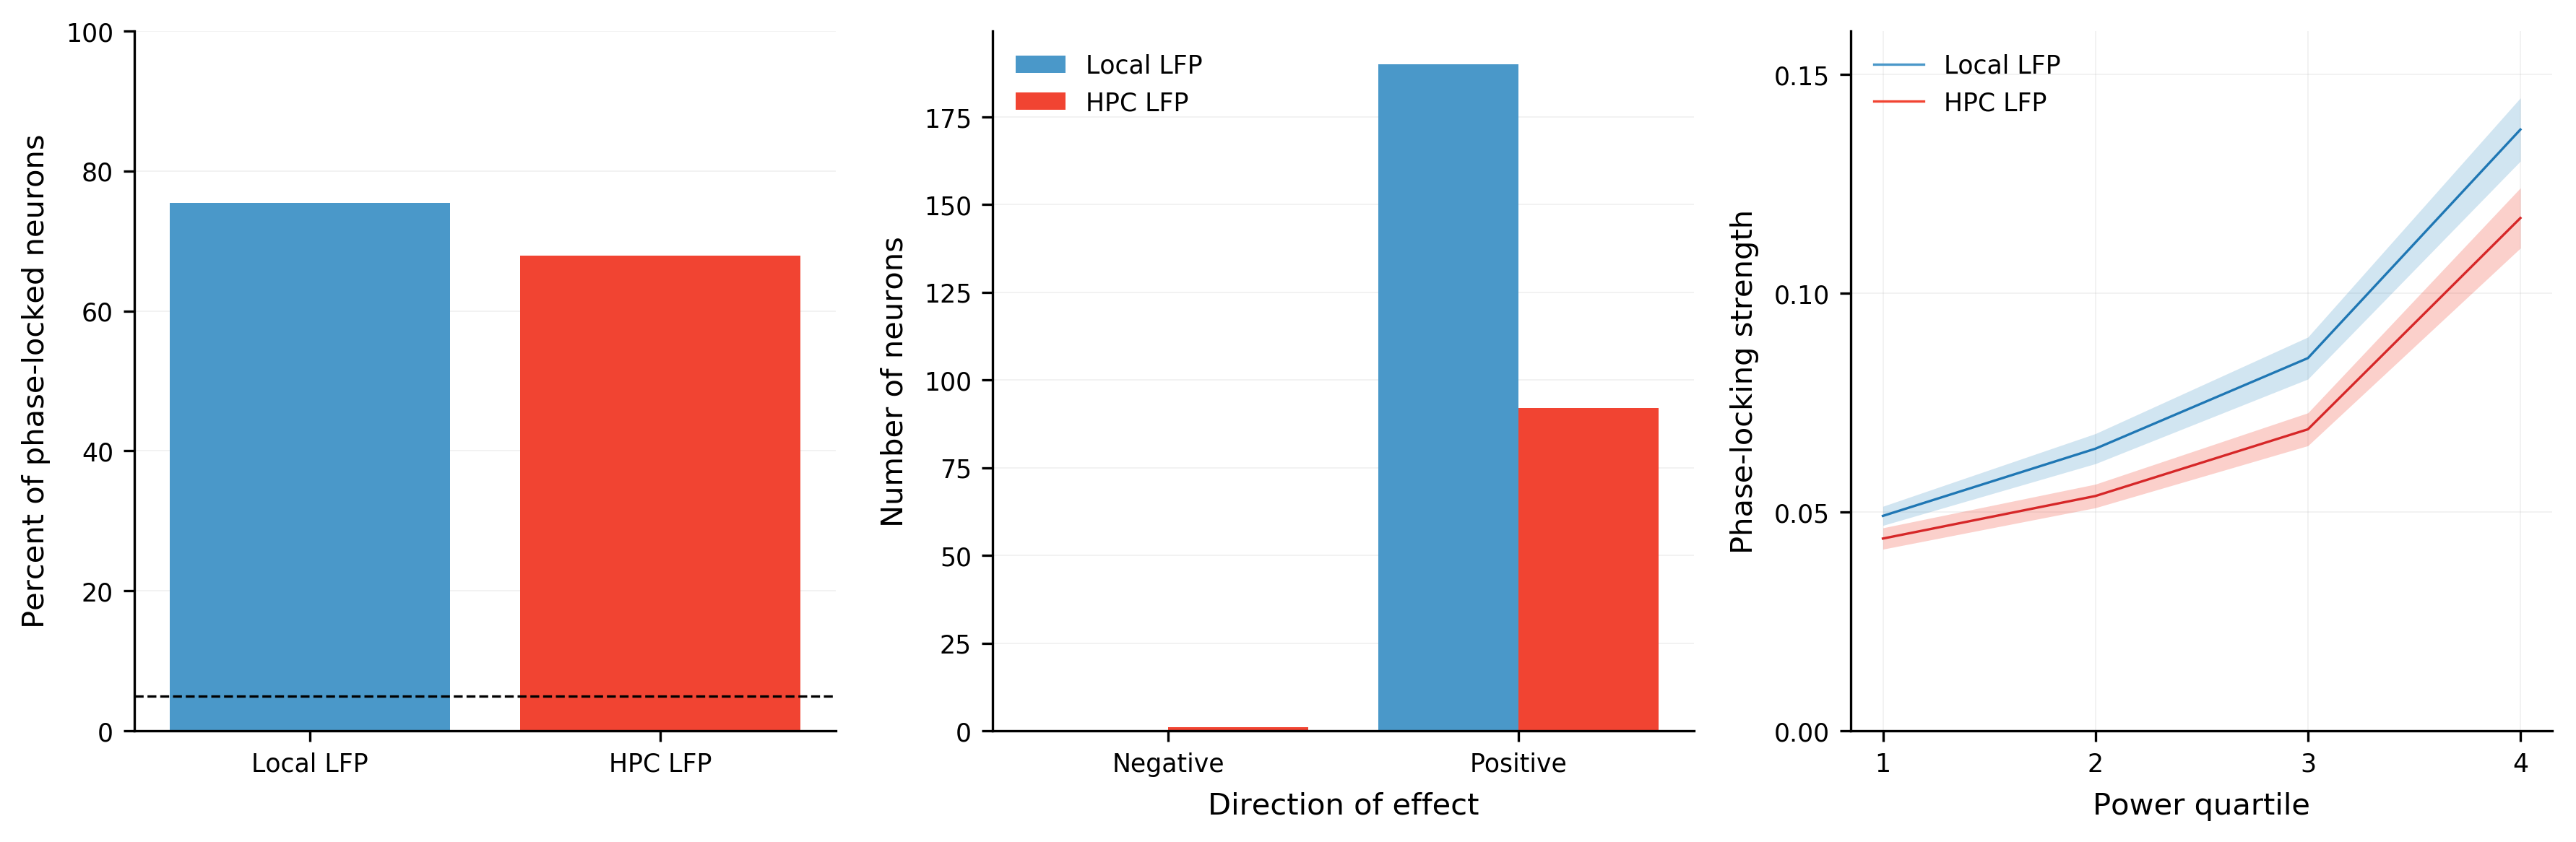

In [1137]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4), dpi=300)
ax = np.ravel(ax)

# Subplot 1
# -----------------------
df = (upl_df
      .query("(sig==True) & (unit_roi2!='hpc')")
      .groupby(['lfp_is_hpc'])
      .agg({'subj_sess_unit': len,
            'pl_diffs_pow_locked_sig': lambda x: np.mean(x)})
      .reset_index())
sns.barplot(x='lfp_is_hpc', y='pl_diffs_pow_locked_sig', data=df, palette=colors, saturation=100, ax=ax[0])
ax[0].axhline(y=0.05, color='k', linestyle='--')
ax[0].set_xticklabels(['Local LFP', 'HPC LFP'])
ax[0].set_ylim([0, 1])
ax[0].set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
ax[0].set_yticklabels([0, 20, 40, 60, 80, 100])
ax[0].set_xlabel('')
ax[0].set_ylabel('Percent of phase-locked neurons', fontsize=10, labelpad=5)
#ax[0].set_title('Phase-locking strength ~ firing rate', fontsize=12, y=1.05)

# Subplot 2
# -----------------------
df = (upl_df
      .query("(sig==True) & (unit_roi2!='hpc') & (pl_diffs_pow_locked_sig==True)")
      .groupby(['lfp_is_hpc', 'pl_diffs_pow_locked_sign'])
      .agg({'subj_sess_unit': len})
      .reset_index())
sns.barplot(x='pl_diffs_pow_locked_sign', y='subj_sess_unit', hue='lfp_is_hpc', data=df, palette=colors, saturation=100, ax=ax[1])
ax[1].set_xticklabels(['Negative', 'Positive'])
ax[1].set_xlabel('Direction of effect', fontsize=10, labelpad=5)
ax[1].set_ylabel('Number of neurons', fontsize=10, labelpad=5)
legend = ax[1].legend(loc=2)
legend.get_texts()[0].set_text('Local LFP')
legend.get_texts()[1].set_text('HPC LFP')

# Subplot 3
# -----------------------
df = (upl_df
      .query("(sig==True) & (unit_roi2!='hpc') & (pl_diffs_pow_locked_sig==True)")
      .groupby(['lfp_is_hpc', 'pl_diffs_pow_locked_sign'])
      .pl_bins_pow_locked.apply(lambda x: np.array(x))
      .reset_index())
df['pl_bins_pow_locked'] = df.pl_bins_pow_locked.apply(lambda x: np.array(list(x)))
df['pl_bins_pow_locked_mean'] = df.pl_bins_pow_locked.apply(lambda x: np.mean(x, axis=0))
df['pl_bins_pow_locked_sem'] = df.pl_bins_pow_locked.apply(lambda x: stats.sem(x, axis=0))
for i in range(4):
    df['mean_q{}'.format(i)] = df.pl_bins_pow_locked_mean.apply(lambda x: x[i])
    df['sem_q{}'.format(i)] = df.pl_bins_pow_locked_sem.apply(lambda x: x[i])
df = df.drop(columns=['pl_bins_pow_locked', 'pl_bins_pow_locked_mean', 'pl_bins_pow_locked_sem'])
df = df.melt(id_vars=['lfp_is_hpc', 'pl_diffs_pow_locked_sign'])

sns.lineplot(x='variable', y='value', hue='lfp_is_hpc',
             data=df.query("(pl_diffs_pow_locked_sign==1) & (variable==['mean_q0', 'mean_q1', 'mean_q2', 'mean_q3'])"),
             ax=ax[2], legend=False)
means = np.array(df.query("(lfp_is_hpc==False) & (pl_diffs_pow_locked_sign==1) & (variable==['mean_q0', 'mean_q1', 'mean_q2', 'mean_q3'])").value.tolist())
sems = np.array(df.query("(lfp_is_hpc==False) & (pl_diffs_pow_locked_sign==1) & (variable==['sem_q0', 'sem_q1', 'sem_q2', 'sem_q3'])").value.tolist())
ax[2].fill_between(np.arange(4), means - sems,means + sems, color=colors[0], alpha=0.25, linewidth=0)
means = np.array(df.query("(lfp_is_hpc==True) & (pl_diffs_pow_locked_sign==1) & (variable==['mean_q0', 'mean_q1', 'mean_q2', 'mean_q3'])").value.tolist())
sems = np.array(df.query("(lfp_is_hpc==True) & (pl_diffs_pow_locked_sign==1) & (variable==['sem_q0', 'sem_q1', 'sem_q2', 'sem_q3'])").value.tolist())
ax[2].fill_between(np.arange(4), means - sems,means + sems, color=colors[1], alpha=0.25, linewidth=0)
ax[2].set_xticklabels(np.arange(1, 5))
ax[2].set_ylim([0, 0.16])
ax[2].set_yticks([0, 0.05, 0.10, 0.15])
ax[2].set_xlabel('Power quartile', fontsize=10, labelpad=5)
ax[2].set_ylabel('Phase-locking strength', fontsize=10, labelpad=5)
custom_lines = [Line2D([0], [0], color=colors[0], label='Local LFP'),
                Line2D([0], [0], color=colors[1], label='HPC LFP')]
legend = ax[2].legend(handles=custom_lines, loc=2)
fig.tight_layout(pad=1.12)

plt.show()

In [1225]:
print('locked band ~ pl_fr_diff:',
      stats.spearmanr(upl_df.query("(sig==True) & (unit_roi2!='hpc')").mrl_argmax,
                      upl_df.query("(sig==True) & (unit_roi2!='hpc')").pl_diffs_fr))
print('locked band ~ pl_fr_diff (sig only):',
      stats.spearmanr(upl_df.query("(sig==True) & (unit_roi2!='hpc') & (pl_diffs_fr_sig==True)").mrl_argmax,
                      upl_df.query("(sig==True) & (unit_roi2!='hpc') & (pl_diffs_fr_sig==True)").pl_diffs_fr))
print('locked band ~ pl_fr_diff (local LFP):',
      stats.spearmanr(upl_df.query("(sig==True) & (unit_roi2!='hpc') & (lfp_is_hpc==False)").mrl_argmax,
                      upl_df.query("(sig==True) & (unit_roi2!='hpc') & (lfp_is_hpc==False)").pl_diffs_fr))
print('locked band ~ pl_fr_diff (HPC LFP):',
      stats.spearmanr(upl_df.query("(sig==True) & (unit_roi2!='hpc') & (lfp_is_hpc==True)").mrl_argmax,
                      upl_df.query("(sig==True) & (unit_roi2!='hpc') & (lfp_is_hpc==True)").pl_diffs_fr))
print('locked band ~ pl_fr_diff (local LFP; sig only):',
      stats.spearmanr(upl_df.query("(sig==True) & (unit_roi2!='hpc') & (lfp_is_hpc==False) & (pl_diffs_fr_sig==True)").mrl_argmax,
                      upl_df.query("(sig==True) & (unit_roi2!='hpc') & (lfp_is_hpc==False) & (pl_diffs_fr_sig==True)").pl_diffs_fr))
print('locked band ~ pl_fr_diff (HPC LFP; sig only):',
      stats.spearmanr(upl_df.query("(sig==True) & (unit_roi2!='hpc') & (lfp_is_hpc==True) & (pl_diffs_fr_sig==True)").mrl_argmax,
                      upl_df.query("(sig==True) & (unit_roi2!='hpc') & (lfp_is_hpc==True) & (pl_diffs_fr_sig==True)").pl_diffs_fr))
print('')

print('locked band ~ pl_pow_locked_diff:',
      stats.spearmanr(upl_df.query("(sig==True) & (unit_roi2!='hpc')").mrl_argmax,
                      upl_df.query("(sig==True) & (unit_roi2!='hpc')").pl_diffs_pow_locked))
print('locked band ~ pl_pow_locked_diff (sig only):',
      stats.spearmanr(upl_df.query("(sig==True) & (unit_roi2!='hpc') & (pl_diffs_pow_locked_sig==True)").mrl_argmax,
                      upl_df.query("(sig==True) & (unit_roi2!='hpc') & (pl_diffs_pow_locked_sig==True)").pl_diffs_pow_locked))
print('locked band ~ pl_pow_locked_diff (local LFP):',
      stats.spearmanr(upl_df.query("(sig==True) & (unit_roi2!='hpc') & (lfp_is_hpc==False)").mrl_argmax,
                      upl_df.query("(sig==True) & (unit_roi2!='hpc') & (lfp_is_hpc==False)").pl_diffs_pow_locked))
print('locked band ~ pl_pow_locked_diff (HPC LFP):',
      stats.spearmanr(upl_df.query("(sig==True) & (unit_roi2!='hpc') & (lfp_is_hpc==True)").mrl_argmax,
                      upl_df.query("(sig==True) & (unit_roi2!='hpc') & (lfp_is_hpc==True)").pl_diffs_pow_locked))
print('locked band ~ pl_pow_locked_diff (local LFP; sig only):',
      stats.spearmanr(upl_df.query("(sig==True) & (unit_roi2!='hpc') & (lfp_is_hpc==False) & (pl_diffs_pow_locked_sig==True)").mrl_argmax,
                      upl_df.query("(sig==True) & (unit_roi2!='hpc') & (lfp_is_hpc==False) & (pl_diffs_pow_locked_sig==True)").pl_diffs_pow_locked))
print('locked band ~ pl_pow_locked_diff (HPC LFP; sig only):',
      stats.spearmanr(upl_df.query("(sig==True) & (unit_roi2!='hpc') & (lfp_is_hpc==True) & (pl_diffs_pow_locked_sig==True)").mrl_argmax,
                      upl_df.query("(sig==True) & (unit_roi2!='hpc') & (lfp_is_hpc==True) & (pl_diffs_pow_locked_sig==True)").pl_diffs_pow_locked))
print('')

print('locked band ~ tl_timemax:',
      stats.spearmanr(upl_df.query("(sig==True) & (unit_roi2!='hpc')").mrl_argmax,
                      upl_df.query("(sig==True) & (unit_roi2!='hpc')").tl_timemax))
print('locked band ~ tl_timemax (local LFP):',
      stats.spearmanr(upl_df.query("(sig==True) & (unit_roi2!='hpc') & (lfp_is_hpc==False)").mrl_argmax,
                      upl_df.query("(sig==True) & (unit_roi2!='hpc') & (lfp_is_hpc==False)").tl_timemax))
print('locked band ~ tl_timemax (HPC LFP):',
      stats.spearmanr(upl_df.query("(sig==True) & (unit_roi2!='hpc') & (lfp_is_hpc==True)").mrl_argmax,
                      upl_df.query("(sig==True) & (unit_roi2!='hpc') & (lfp_is_hpc==True)").tl_timemax))

locked band ~ pl_fr_diff: SpearmanrResult(correlation=-0.24141114887254722, pvalue=1.4537786706981647e-06)
locked band ~ pl_fr_diff (sig only): SpearmanrResult(correlation=-0.3221419939281886, pvalue=3.458824507111195e-05)
locked band ~ pl_fr_diff (local LFP): SpearmanrResult(correlation=-0.25464353066129947, pvalue=4.3162332071853045e-05)
locked band ~ pl_fr_diff (HPC LFP): SpearmanrResult(correlation=-0.1405249536627306, pvalue=0.10144890061023941)
locked band ~ pl_fr_diff (local LFP; sig only): SpearmanrResult(correlation=-0.36069186685486776, pvalue=0.00019602166758979296)
locked band ~ pl_fr_diff (HPC LFP; sig only): SpearmanrResult(correlation=-0.12568791185969644, pvalue=0.35154256637848125)

locked band ~ pl_pow_locked_diff: SpearmanrResult(correlation=0.04451885082392117, pvalue=0.38121624117357766)
locked band ~ pl_pow_locked_diff (sig only): SpearmanrResult(correlation=-0.17879175201435918, pvalue=0.00253784892701298)
locked band ~ pl_pow_locked_diff (local LFP): SpearmanrRe

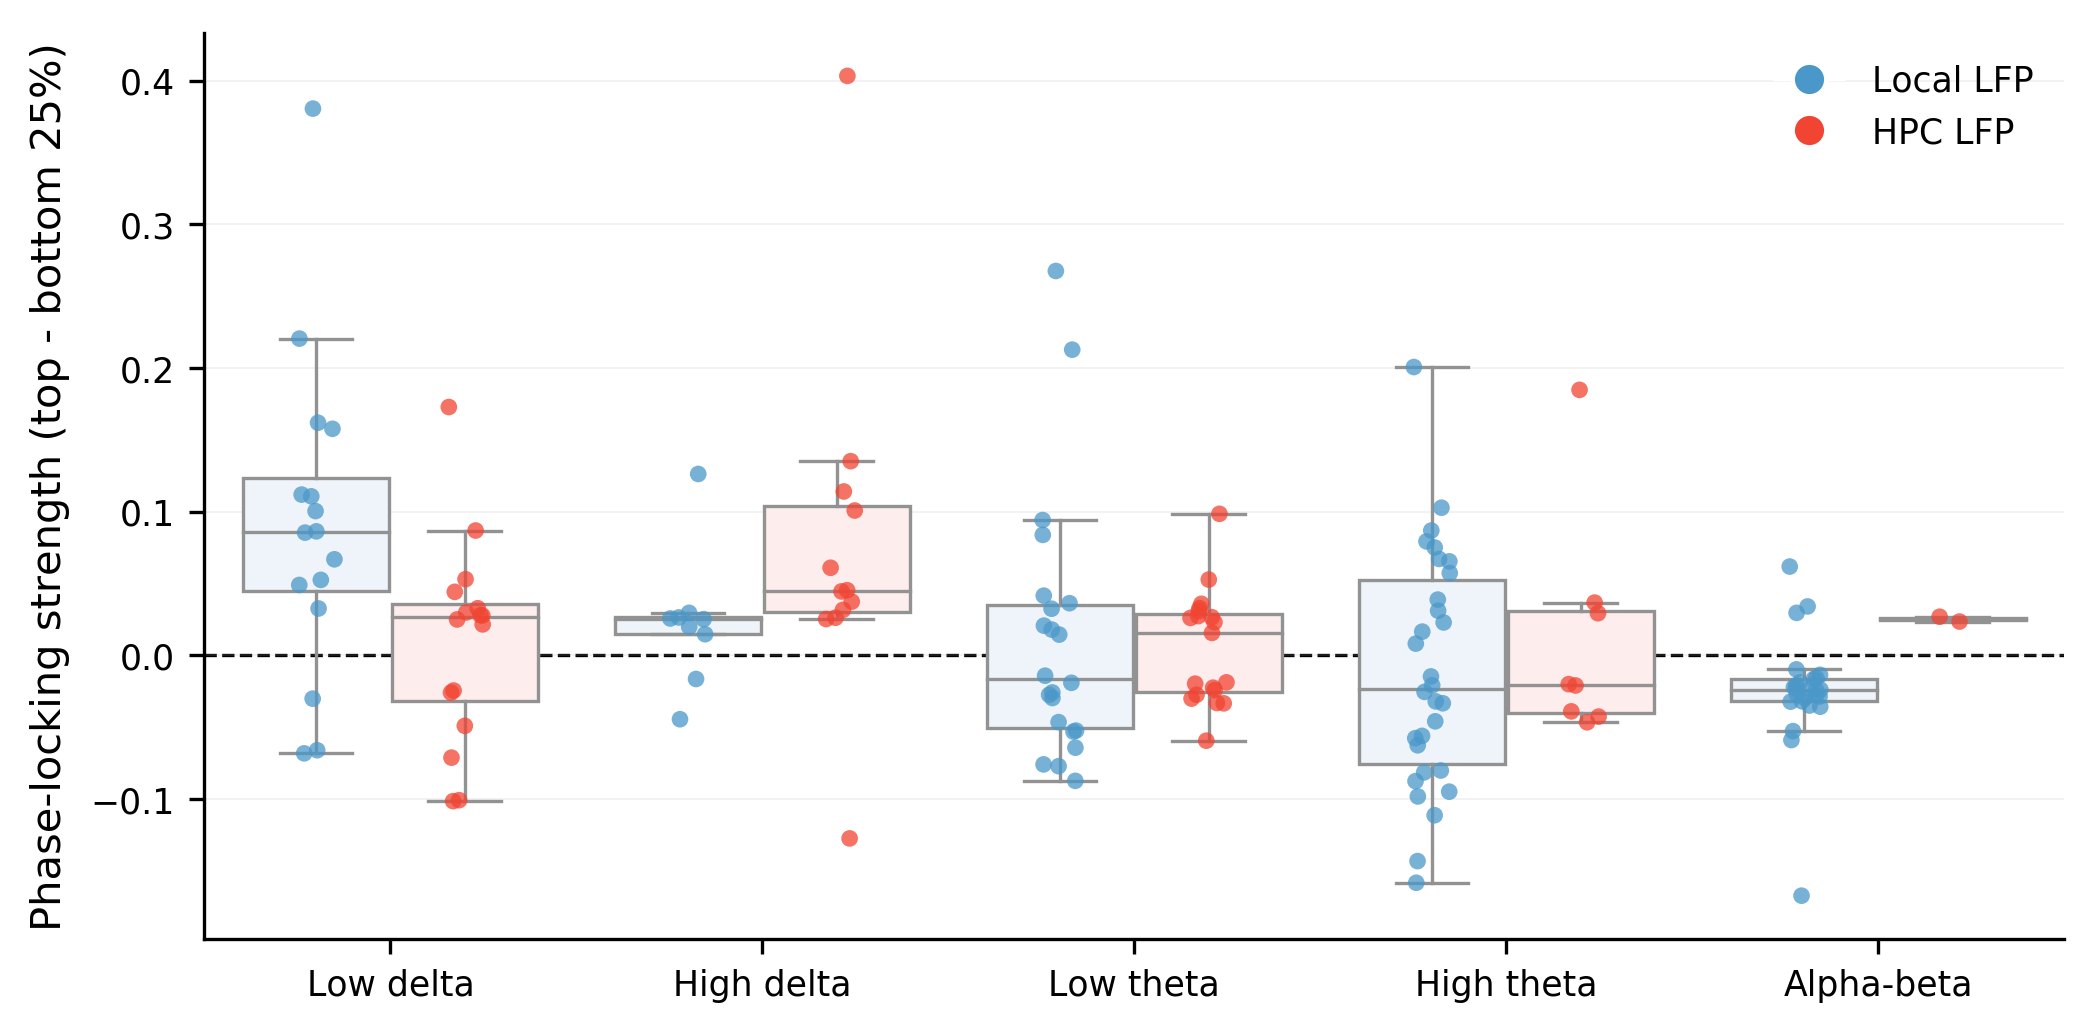

In [1215]:
df = (upl_df
      .query("(sig==True) & (unit_roi2!='hpc') & (pl_diffs_fr_sig==True)")
      .reset_index())
df['q4_fr_mrl'] = df.pl_bins_fr.apply(lambda x: x[-1])

fig, ax = plt.subplots(1, 1, figsize=(8, 4), dpi=300)
ax = np.ravel(ax)

sns.boxplot(x='locked_band', y='pl_diffs_fr', hue='lfp_is_hpc', data=df,
            palette=(cmap[35], cmap[65]), saturation=1, showfliers=False)
sns.stripplot(x='locked_band', y='pl_diffs_fr', hue='lfp_is_hpc', dodge=True, data=df,
              palette=colors, size=4, alpha=0.75)
ax[0].axhline(y=0, color='k', linestyle='--', zorder=0)

ax[0].set_xticklabels(bands_fancy2.values())
#ax[0].set_ylim([-500, 500])
#ax[0].set_yticks(np.arange(-500, 501, 100))
ax[0].set_xlabel('')
ax[0].set_ylabel('Phase-locking strength (top - bottom 25%)', fontsize=10, labelpad=5)

custom_lines = [Line2D([0], [0], marker='o', color='w', label='Local LFP', markerfacecolor=colors[0], markersize=8),
                Line2D([0], [0], marker='o', color='w', label='HPC LFP', markerfacecolor=colors[1], markersize=8)]
legend = ax[0].legend(handles=custom_lines, loc=1)

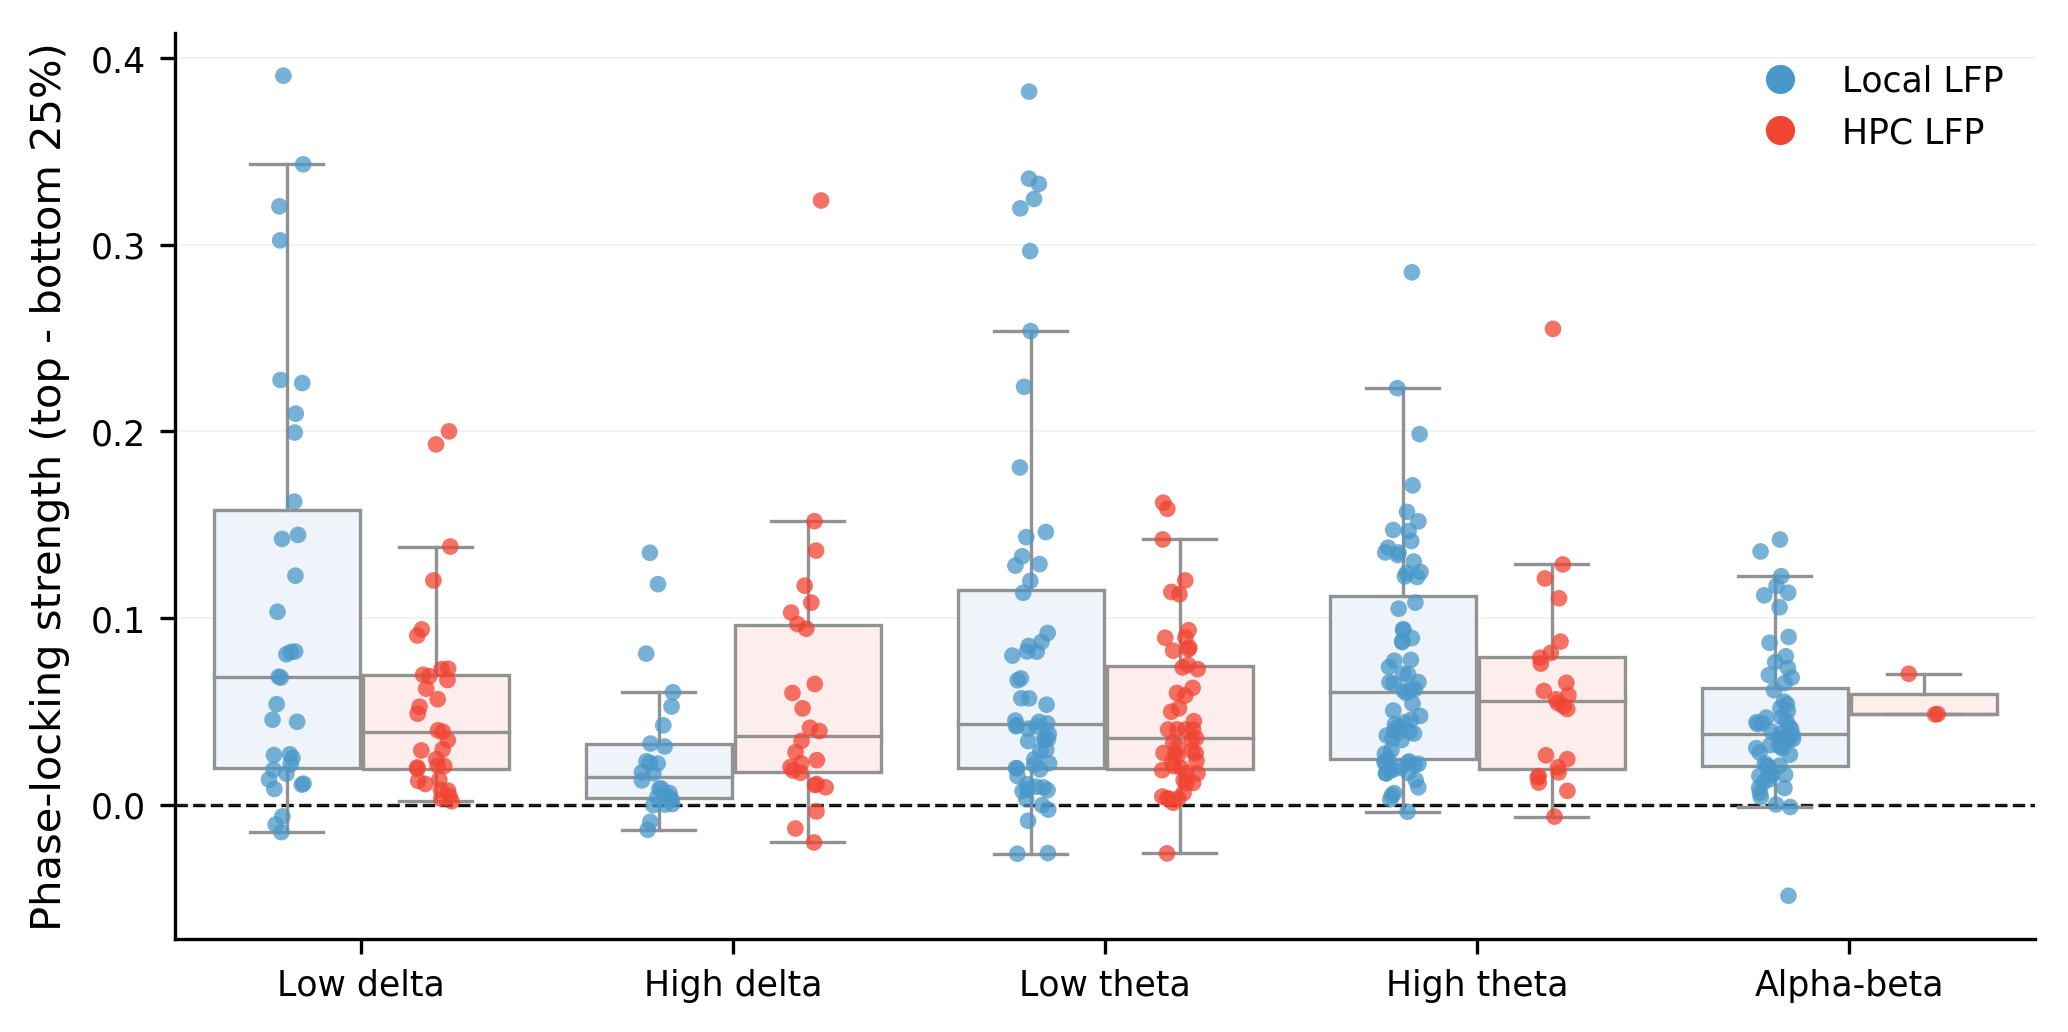

In [1226]:
df = (upl_df
      .query("(sig==True) & (unit_roi2!='hpc')")
      .reset_index())

fig, ax = plt.subplots(1, 1, figsize=(8, 4), dpi=300)
ax = np.ravel(ax)

sns.boxplot(x='locked_band', y='pl_diffs_pow_locked', hue='lfp_is_hpc', data=df,
            palette=(cmap[35], cmap[65]), saturation=1, showfliers=False)
sns.stripplot(x='locked_band', y='pl_diffs_pow_locked', hue='lfp_is_hpc', dodge=True, data=df,
              palette=colors, size=4, alpha=0.75)
ax[0].axhline(y=0, color='k', linestyle='--', zorder=0)

ax[0].set_xticklabels(bands_fancy2.values())
#ax[0].set_ylim([-500, 500])
#ax[0].set_yticks(np.arange(-500, 501, 100))
ax[0].set_xlabel('')
ax[0].set_ylabel('Phase-locking strength (top - bottom 25%)', fontsize=10, labelpad=5)

custom_lines = [Line2D([0], [0], marker='o', color='w', label='Local LFP', markerfacecolor=colors[0], markersize=8),
                Line2D([0], [0], marker='o', color='w', label='HPC LFP', markerfacecolor=colors[1], markersize=8)]
legend = ax[0].legend(handles=custom_lines, loc=1)

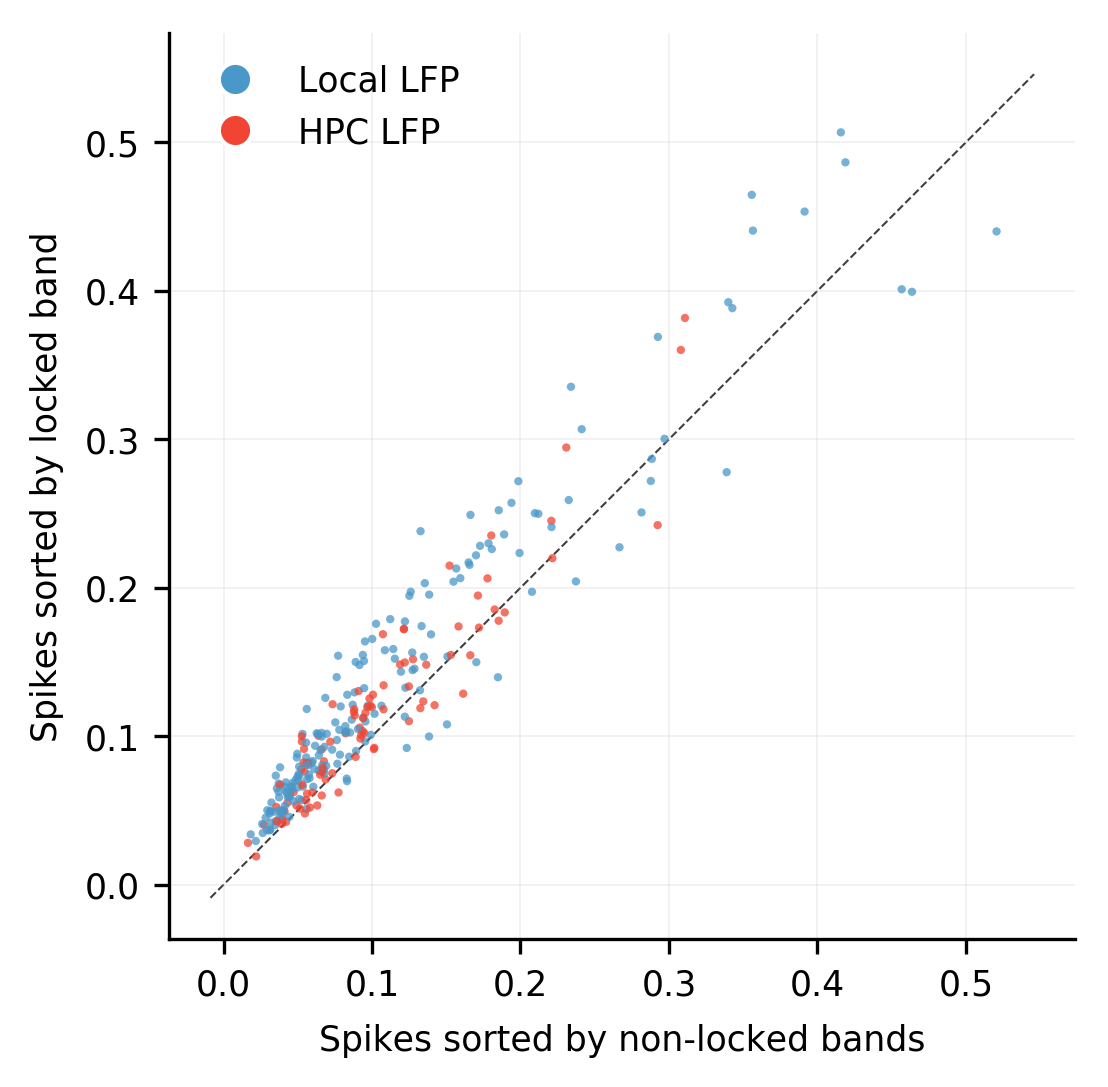

In [1171]:
df = (upl_df
      .query("(sig==True) & (unit_roi2!='hpc') & (pl_diffs_pow_locked_sig==True)")
      .reset_index())
df = df[['lfp_is_hpc', 'pl_bins_pow_locked', 'pl_bins_pow_nonlocked']]
df['q4_pow_locked'] = df.pl_bins_pow_locked.apply(lambda x: x[3])
df['q4_pow_nonlocked'] = df.pl_bins_pow_nonlocked.apply(lambda x: x[3])

fig, ax = plt.subplots(1, 1, figsize=(8, 4), dpi=300)
ax = np.ravel(ax)

sns.scatterplot(x='q4_pow_nonlocked', y='q4_pow_locked', hue='lfp_is_hpc', data=df,
                linewidth=0, s=4, alpha=0.75, ax=ax[0], legend=False, palette=colors[:2])
lims = [np.min([ax[0].get_xlim(), ax[0].get_ylim()]), np.max([ax[0].get_xlim(), ax[0].get_ylim()])]
ax[0].plot(lims, lims, 'k--', linewidth=0.5, alpha=0.75, zorder=0)
ax[0].set_aspect('equal')
ax[0].set_xlabel('Spikes sorted by non-locked bands', labelpad=5)
ax[0].set_ylabel('Spikes sorted by locked band', labelpad=5)

custom_lines = [Line2D([0], [0], marker='o', color='w', label='Local LFP', markerfacecolor=colors[0], markersize=8),
                Line2D([0], [0], marker='o', color='w', label='HPC LFP', markerfacecolor=colors[1], markersize=8)]
legend = ax[0].legend(handles=custom_lines, loc=2)

## Time shift analysis

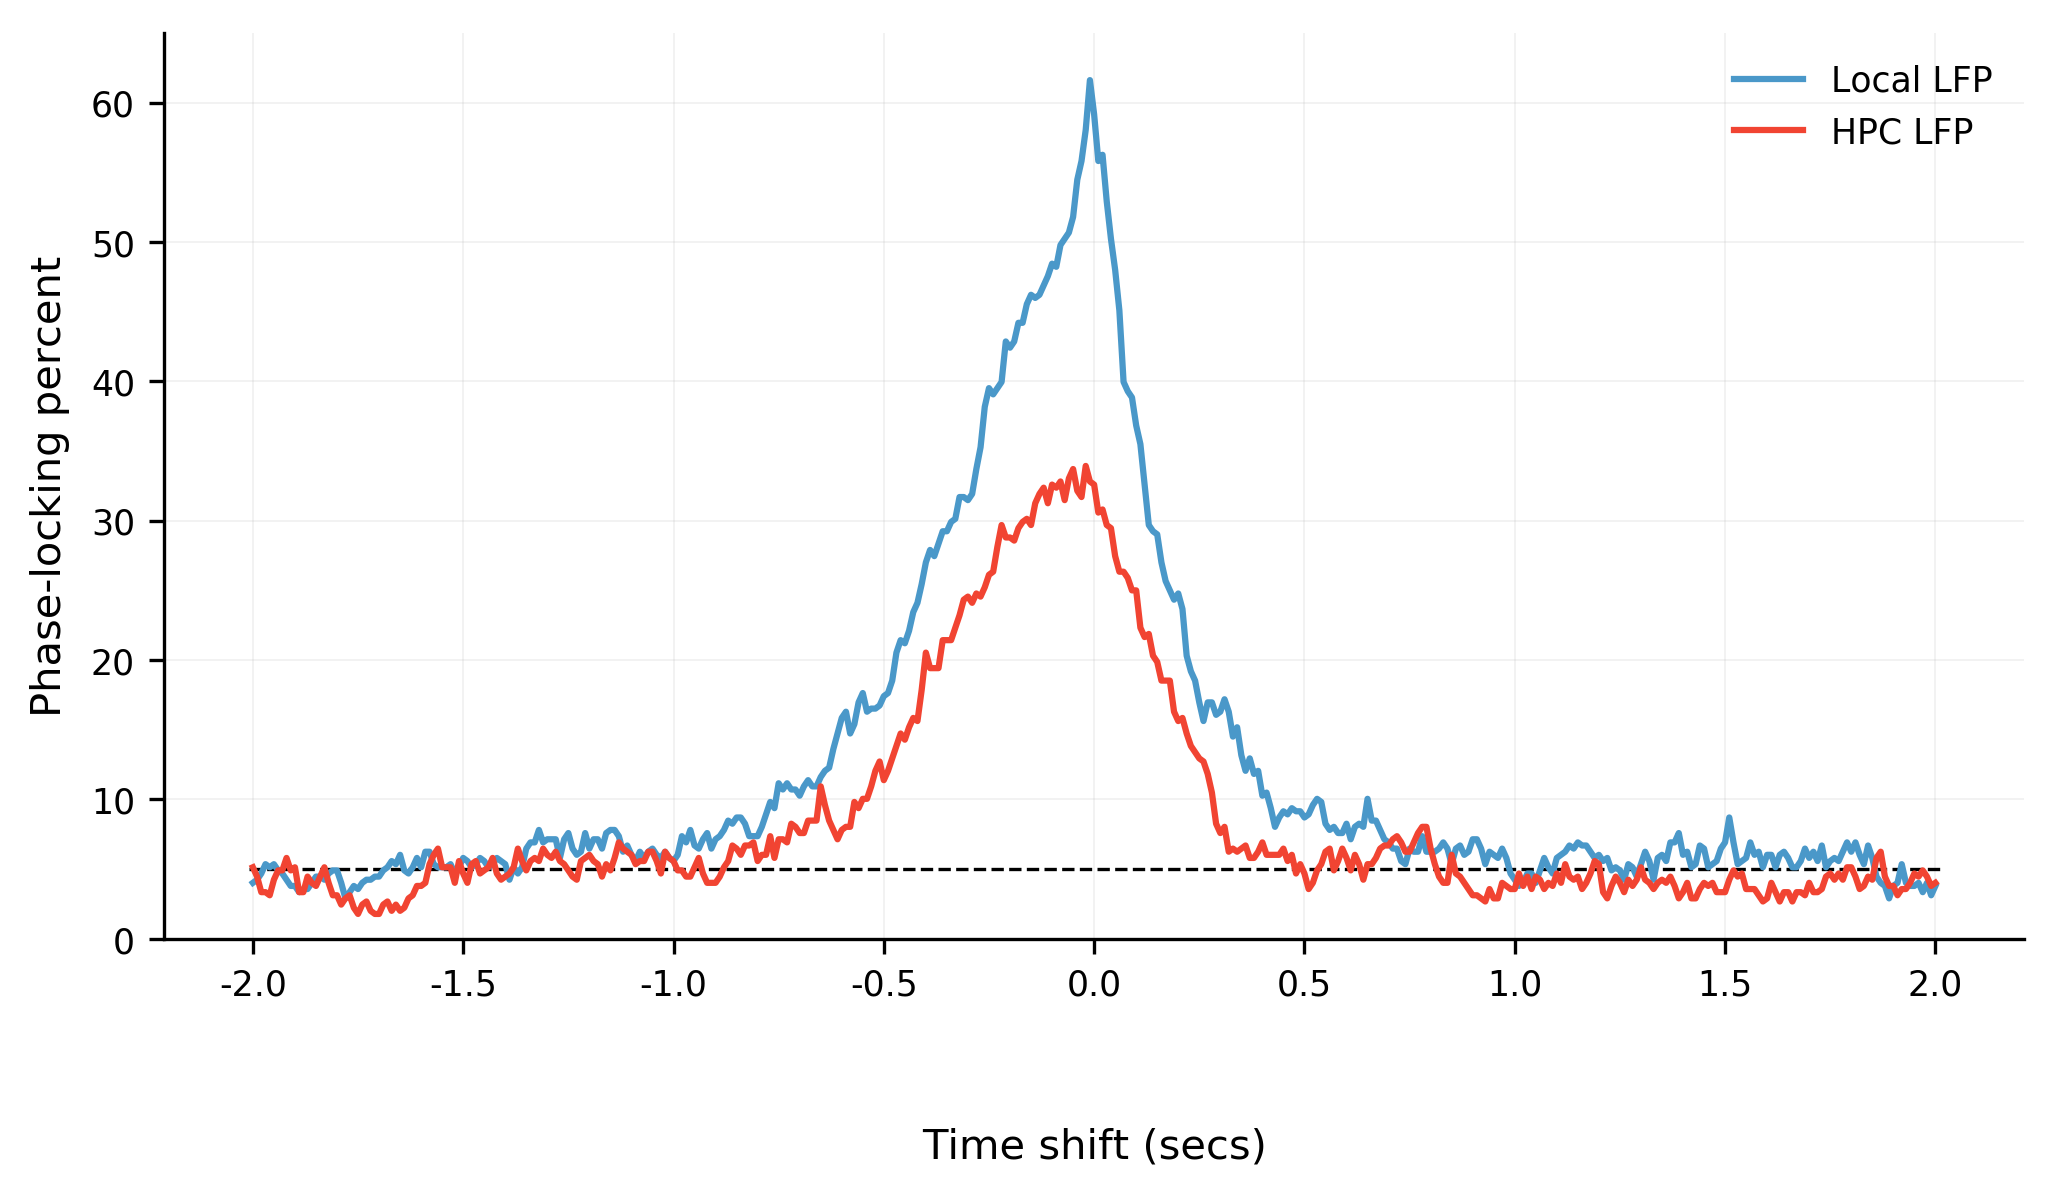

In [946]:
# Plot the percent of phase-locked units at different time lags
fig, ax = plt.subplots(1, 1, figsize=(8, 4), dpi=300)
ax = np.ravel(ax)

ax[0].plot(np.mean(np.flip(upl_df.query("(unit_roi2!='hpc') & (lfp_is_hpc==False)").tl_sig.tolist(), axis=-1), axis=0), 
           label='Local LFP', color=colors[0], linewidth=1.5)
ax[0].plot(np.mean(np.flip(upl_df.query("(unit_roi2!='hpc') & (lfp_is_hpc==True)").tl_sig.tolist(), axis=-1), axis=0), 
           label='HPC LFP', color=colors[1], linewidth=1.5)
ax[0].hlines(y=0.05, xmin=-1, xmax=401, color='k', linestyle='--')
ax[0].set_xticks(np.linspace(0, 400, 9))
ax[0].set_xticklabels(np.linspace(-2, 2, 401)[np.linspace(0, 400, 9, dtype=int)])
ax[0].set_ylim([0, 0.65])
ax[0].set_yticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6])
ax[0].set_yticklabels([0, 10, 20, 30, 40, 50, 60])
ax[0].set_xlabel('Time shift (secs)', fontsize=10, labelpad=30)
ax[0].set_ylabel('Phase-locking percent', fontsize=10, labelpad=5)
ax[0].legend()

In [32]:
print(stats.mannwhitneyu(upl_df.query("(sig==True) & (unit_roi2!='hpc') & (lfp_is_hpc==False)").tl_timemax, 
                         upl_df.query("(sig==True) & (unit_roi2!='hpc') & (lfp_is_hpc==True)").tl_timemax))
print(stats.levene(upl_df.query("(sig==True) & (unit_roi2!='hpc') & (lfp_is_hpc==False)").tl_timemax, 
                   upl_df.query("(sig==True) & (unit_roi2!='hpc') & (lfp_is_hpc==True)").tl_timemax))
print(stats.spearmanr(upl_df.query("(sig==True) & (unit_roi2!='hpc')").tl_timemax, 
                      upl_df.query("(sig==True) & (unit_roi2!='hpc')").mrl_argmax))
upl_df.query("(sig==True) & (unit_roi2!='hpc')").groupby(['locked_band', 'lfp_is_hpc']).tl_timemax.describe()

MannwhitneyuResult(statistic=19206.5, pvalue=0.4521935576616806)
LeveneResult(statistic=2.8556290430666302, pvalue=0.09181662105610473)
SpearmanrResult(correlation=0.33005115020003223, pvalue=6.692246297438198e-12)


count        mean         std     min    25%    50%  \
locked_band lfp_is_hpc                                                        
sub_delta   0            37.0  -95.945946  405.500099 -1110.0 -240.0  -80.0   
            1            34.0  -64.705882  261.779867  -290.0 -140.0 -100.0   
delta       0            26.0  -63.076923   83.846013  -240.0 -100.0  -55.0   
            1            27.0  -27.037037  189.976007  -400.0  -75.0  -10.0   
low_theta   0            62.0  -57.419355  175.918531  -980.0  -60.0  -20.0   
            1            55.0   37.090909  457.406832 -1650.0  -40.0    0.0   
high_theta  0            75.0  -22.133333  230.312909 -1260.0  -20.0  -10.0   
            1            26.0  -47.692308  322.469319 -1400.0  -27.5  -10.0   
alpha_beta  0            65.0   47.076923  359.020904  -750.0  -10.0    0.0   
            1             4.0  377.500000  768.954918   -50.0   -5.0   15.0   

                          75%     max  
locked_band lfp_is_hpc                 
sub_delta   0           -50.0  1810.0  
            1           -62.5  1340.0  
delta       0           -10.0   130.0  
            1            30.0   690.0  
low_theta   0            20.0    90.0  
            1            30.0  1810.0  
high_theta  0            10.0  1120.0  
            1             0.0   700.0  
alpha_beta  0             0.0  1970.0  
            1           397.5  1530.0

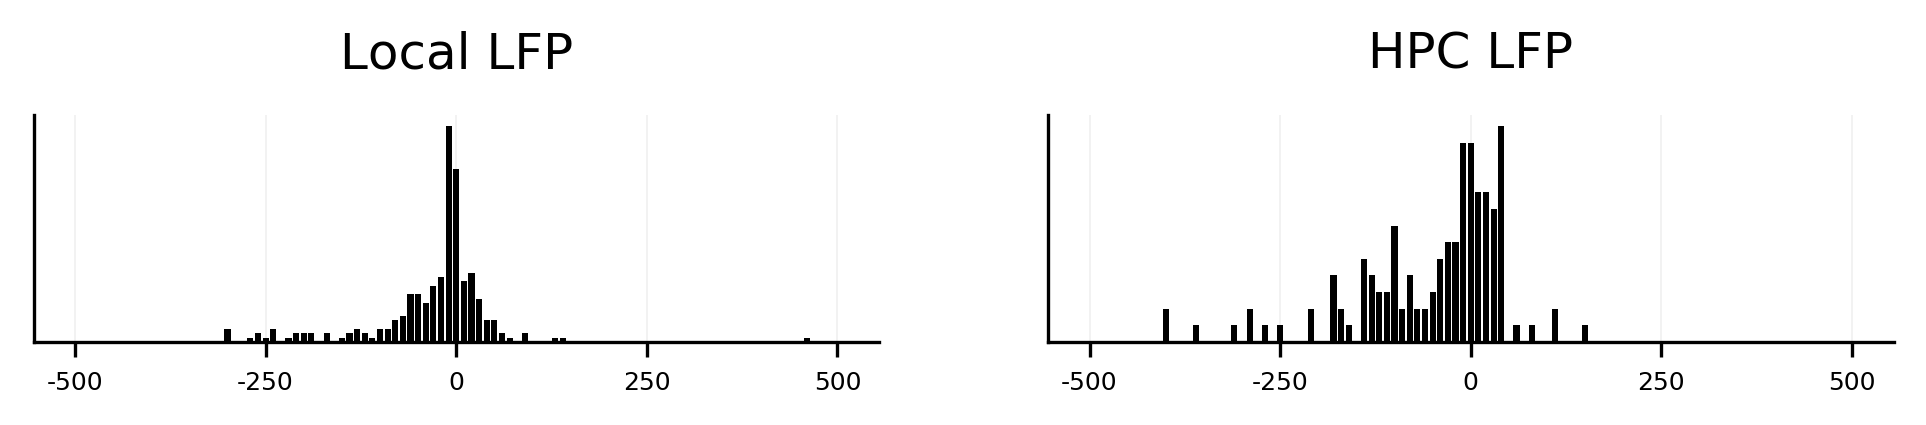

In [962]:
local_d = (upl_df
           .query("(sig==True) & (unit_roi2!='hpc') & (lfp_is_hpc==False)")
           .groupby('tl_timemax')
           .size()
           .to_dict())
hpc_d = (upl_df
         .query("(sig==True) & (unit_roi2!='hpc') & (lfp_is_hpc==True)")
         .groupby('tl_timemax')
         .size()
         .to_dict())
counts = []
for i in np.arange(-500, 501, 10):
    counts.append([local_d.get(i, 0), hpc_d.get(i, 0)])
counts = pd.DataFrame(counts, columns=['local', 'hpc']).reset_index()

fig, ax = plt.subplots(1, 2, figsize=(8, 1), dpi=300)
ax = np.ravel(ax)

ax[0].bar(counts.index, counts.local, color='k')
ax[0].set_title('Local LFP', fontsize=12, y=1.1)

ax[1].bar(counts.index, counts.hpc, color='k')
ax[1].set_yticks(np.arange(0, 15, 3))
ax[1].set_title('HPC LFP', fontsize=12, y=1.1)

for i in range(2):
    ax[i].set_xticks(np.arange(0, 101, 25))
    ax[i].set_xticklabels(np.arange(-500, 501, 250), fontsize=6)
    ax[i].set_yticks([])
    #ax[i].set_xlabel('Time shift (ms)', labelpad=5)
    #ax[i].set_ylabel('Number of neurons', labelpad=5)

In [712]:
cmap = sns.palettes.blend_palette((colors[0], 
                                   sns.palettes.blend_palette((colors[0], 'w', colors[1]), 101)[45],
                                   sns.palettes.blend_palette((colors[0], 'w', colors[1]), 101)[55],
                                   colors[1]), 101)

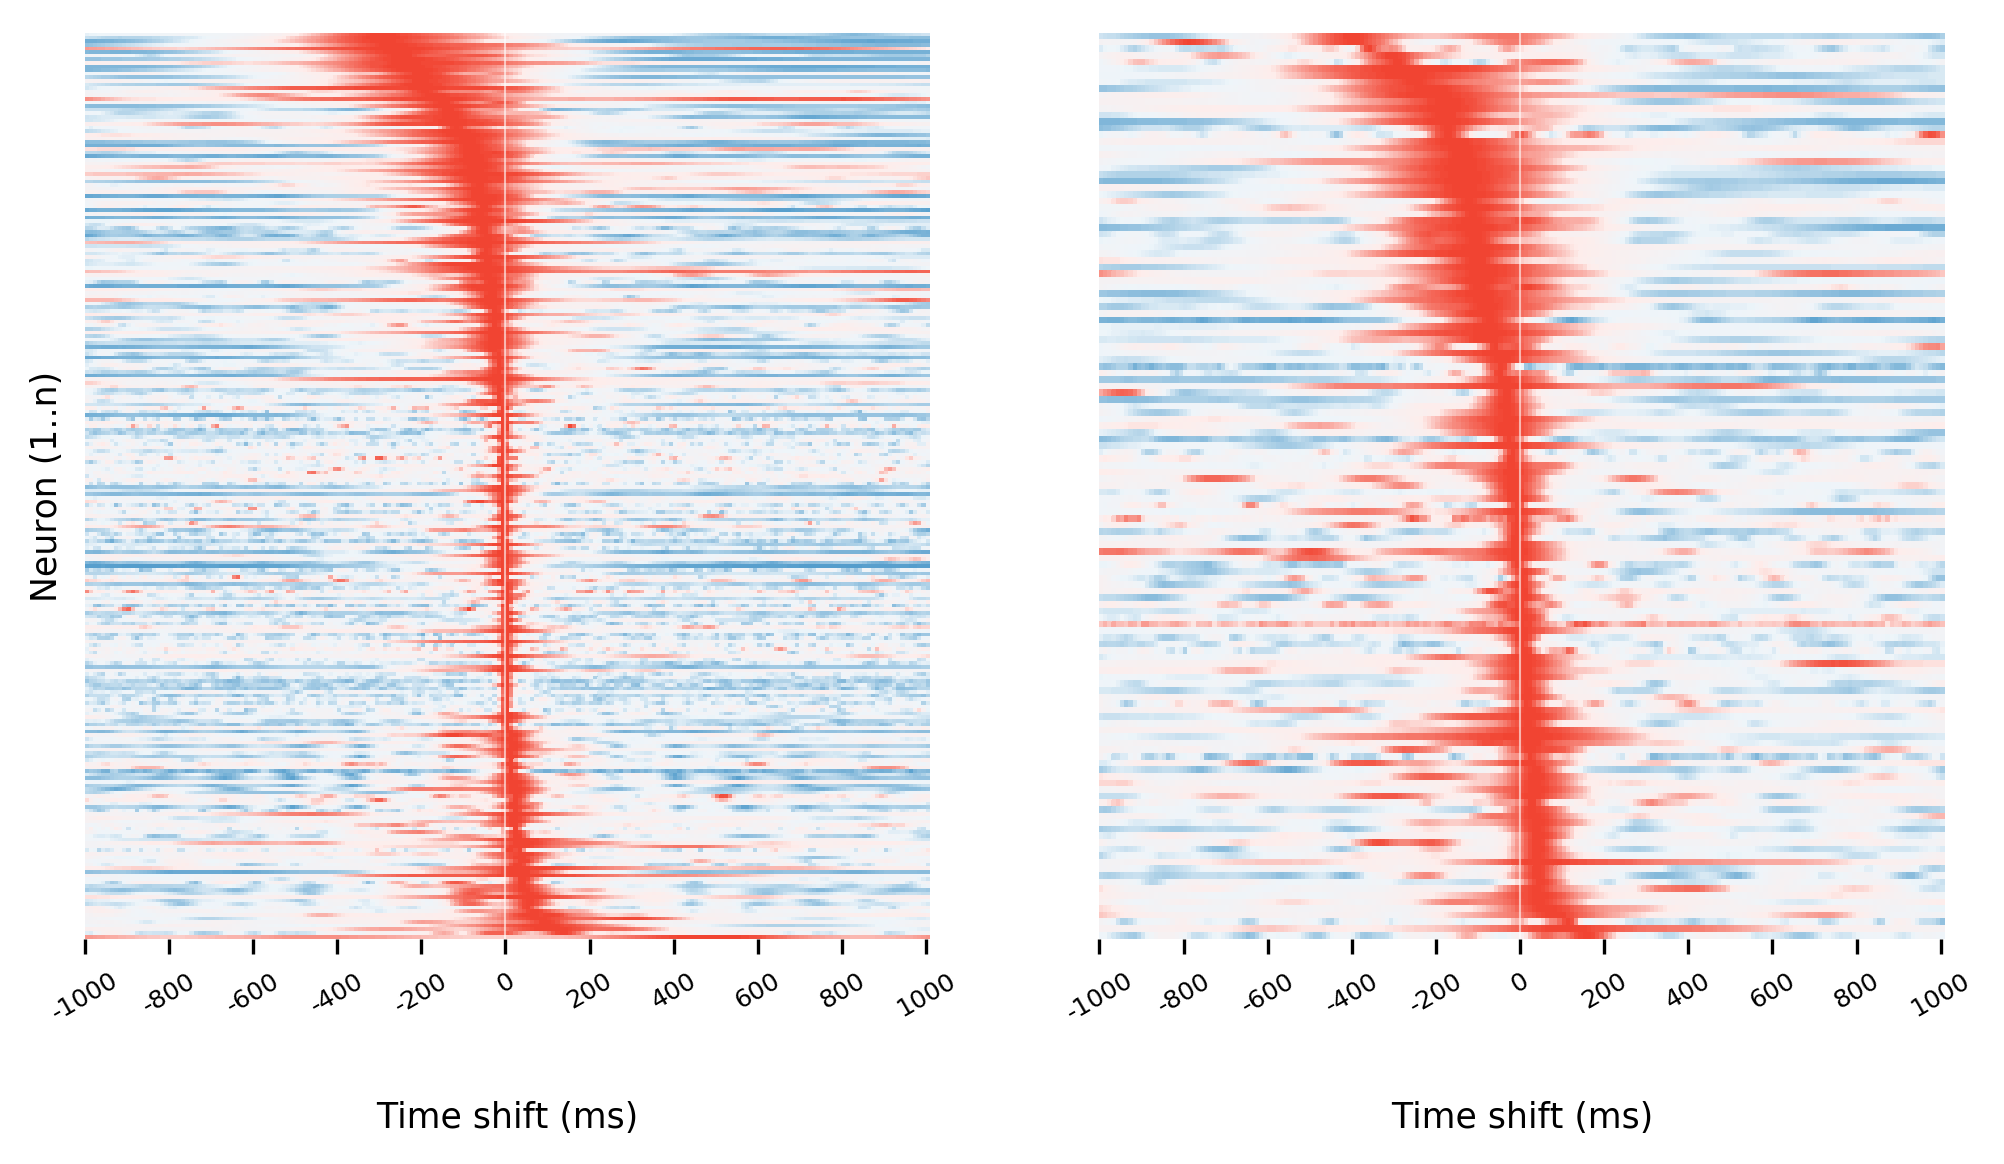

In [961]:
local_tl_mrls = np.array(upl_df.query("(sig==True) & (unit_roi2!='hpc') & (lfp_is_hpc==False)")
                         .sort_values('tl_timemax').tl_mrls_locked_band.tolist())
hpc_tl_mrls = np.array(upl_df.query("(sig==True) & (unit_roi2!='hpc') & (lfp_is_hpc==True)")
                       .sort_values('tl_timemax').tl_mrls_locked_band.tolist())

fig, ax = plt.subplots(1, 2, figsize=(8, 4), dpi=300)
ax = np.ravel(ax)

sns.heatmap((local_tl_mrls[:, 100:301].T / np.max(local_tl_mrls, axis=1)).T, ax=ax[0], 
            vmin=0, vmax=1, cmap=cmap, cbar=False)
sns.heatmap((hpc_tl_mrls[:, 100:301].T / np.max(hpc_tl_mrls, axis=1)).T, ax=ax[1], 
            vmin=0, vmax=1, cmap=cmap, cbar=False)
ax[0].axvline(x=100, color='w', linewidth=0.5, alpha=0.6)
ax[1].axvline(x=100, color='w', linewidth=0.5, alpha=0.6)

for i in range(2):
    ax[i].set_xticks(np.arange(0, 201, 20))
    ax[i].set_xticklabels(np.arange(-1000, 1001, 200), fontsize=6, rotation=30)
    ax[i].set_yticks([])
    ax[i].set_xlabel('Time shift (ms)', labelpad=18)
ax[0].set_ylabel('Neuron (1..n)', labelpad=5)

plt.show()

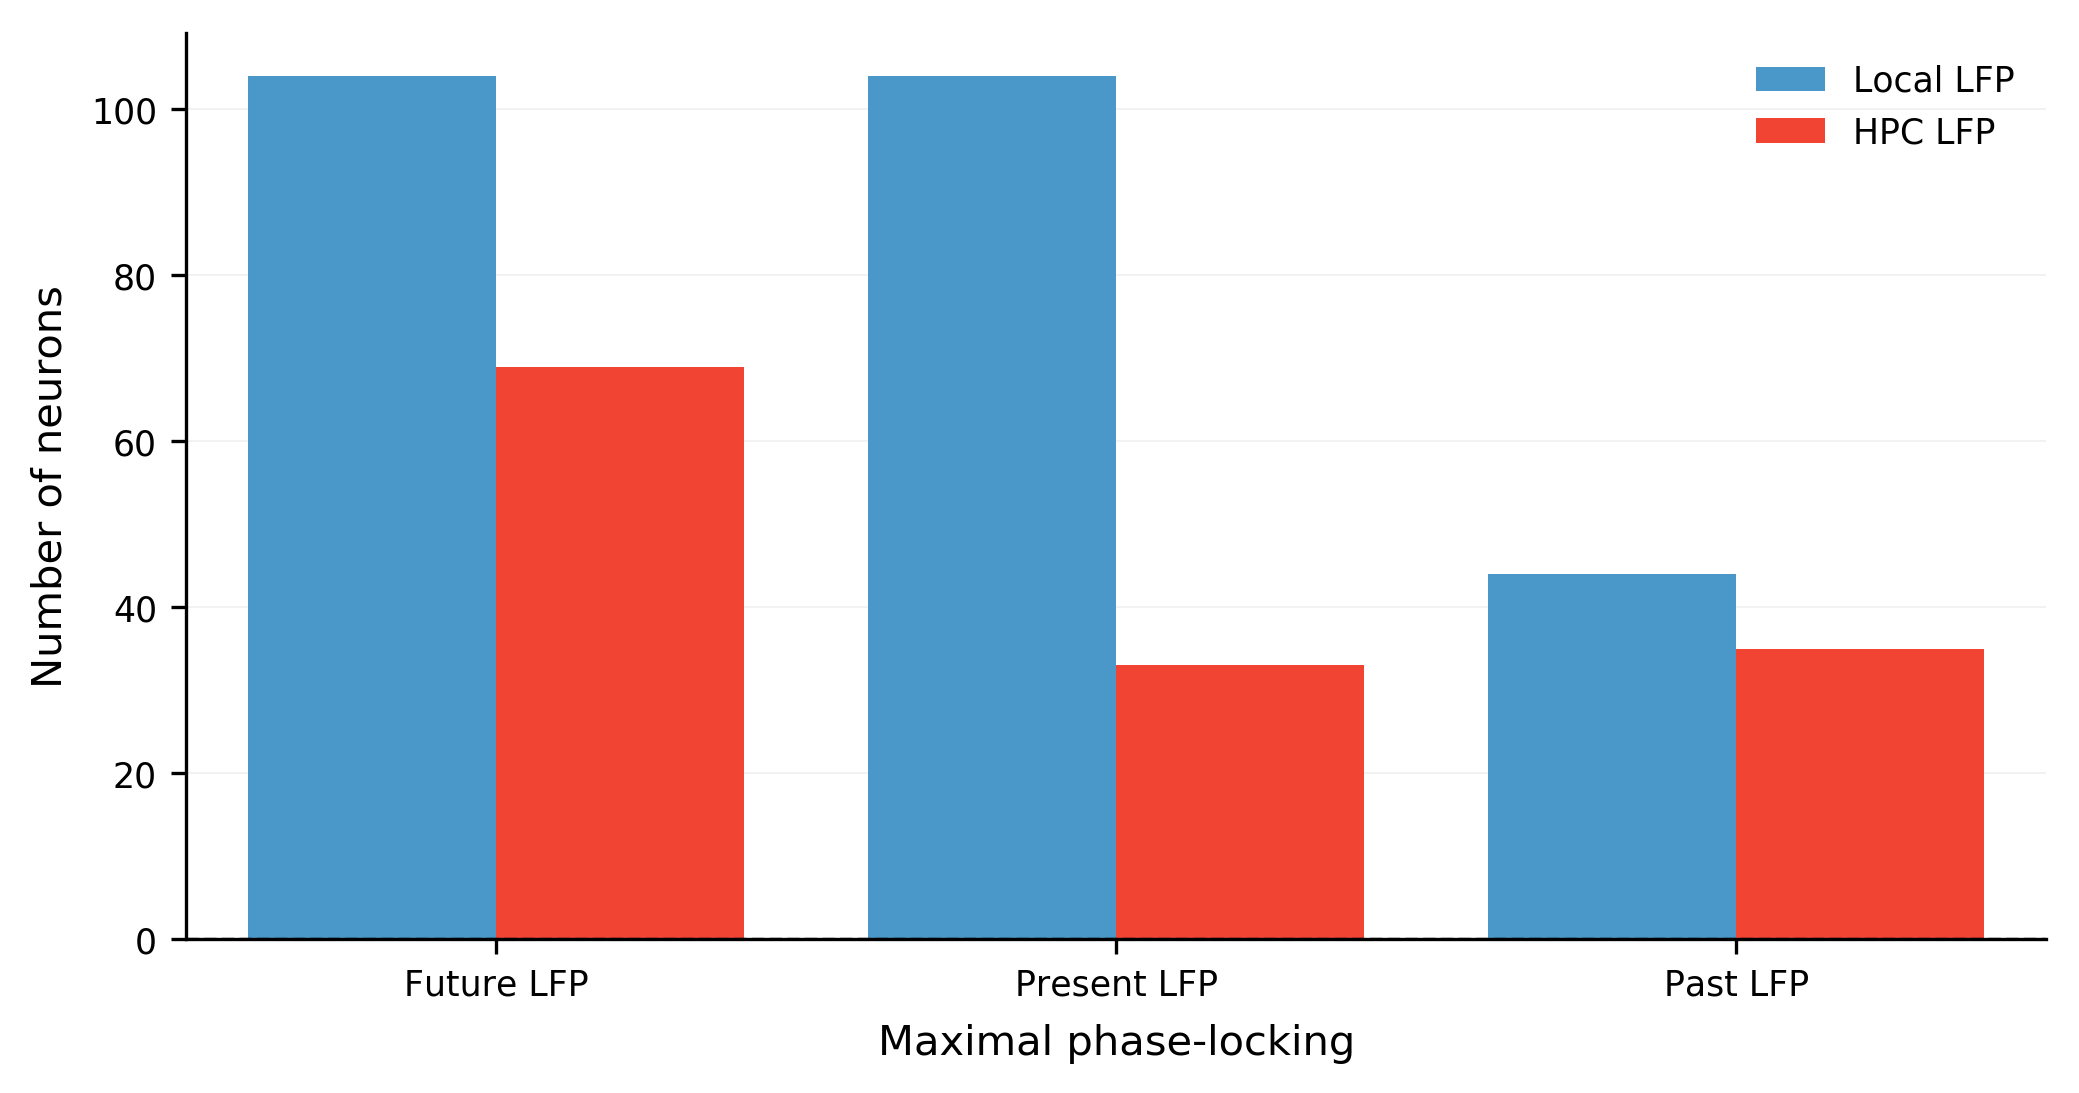

In [732]:
df = (upl_df
      .query("(sig==True) & (unit_roi2!='hpc')")
      .groupby(['lfp_is_hpc', 'tl_timemax_cat'])
      .agg({'subj_sess_unit': len})
      .reset_index())
df['tl_timemax_cat'] = df.tl_timemax_cat.astype('category').cat.reorder_categories(['future LFP', 'present LFP', 'past LFP'], ordered=True)

fig, ax = plt.subplots(1, 1, figsize=(8, 4), dpi=300)
ax = np.ravel(ax)

sns.barplot(x='tl_timemax_cat', y='subj_sess_unit', hue='lfp_is_hpc', data=df.reset_index(), 
            palette=colors, saturation=100, ax=ax[0])
ax[0].axhline(y=0.05, color='k', linestyle='--')
ax[0].set_xticklabels(['Future LFP', 'Present LFP', 'Past LFP'])
#ax[0].set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
#ax[0].set_yticklabels([0, 20, 40, 60, 80, 100])
ax[0].set_xlabel('Maximal phase-locking', fontsize=10, labelpad=5)
ax[0].set_ylabel('Number of neurons', fontsize=10, labelpad=5)
legend = plt.legend()
legend.get_texts()[0].set_text('Local LFP')
legend.get_texts()[1].set_text('HPC LFP')

In [965]:
df = upl_df.query("(sig==True) & (unit_roi2!='hpc')")[['lfp_is_hpc', 'locked_band', 'mrl_argmax', 'tl_timemax']]
#df['tl_timemax_cycles'] = df.apply(lambda x: x['tl_timemax'] / (1000 / np.array([1, 2, 4, 8, 16]))[x['mrl_argmax']], axis=1)
df['tl_timemax_cycles'] = df.apply(lambda x: x['tl_timemax'] / (1000 / np.array([1.45, 2.10, 3.19, 7.34, 16.76]))[x['mrl_argmax']], axis=1)
stats.spearmanr(df.mrl_argmax, df.tl_timemax), stats.spearmanr(df.mrl_argmax, df.tl_timemax_cycles)

(SpearmanrResult(correlation=0.3650261012796172, pvalue=1.0508331968631922e-13),
 SpearmanrResult(correlation=0.16111527193627348, pvalue=0.0014310321260178201))

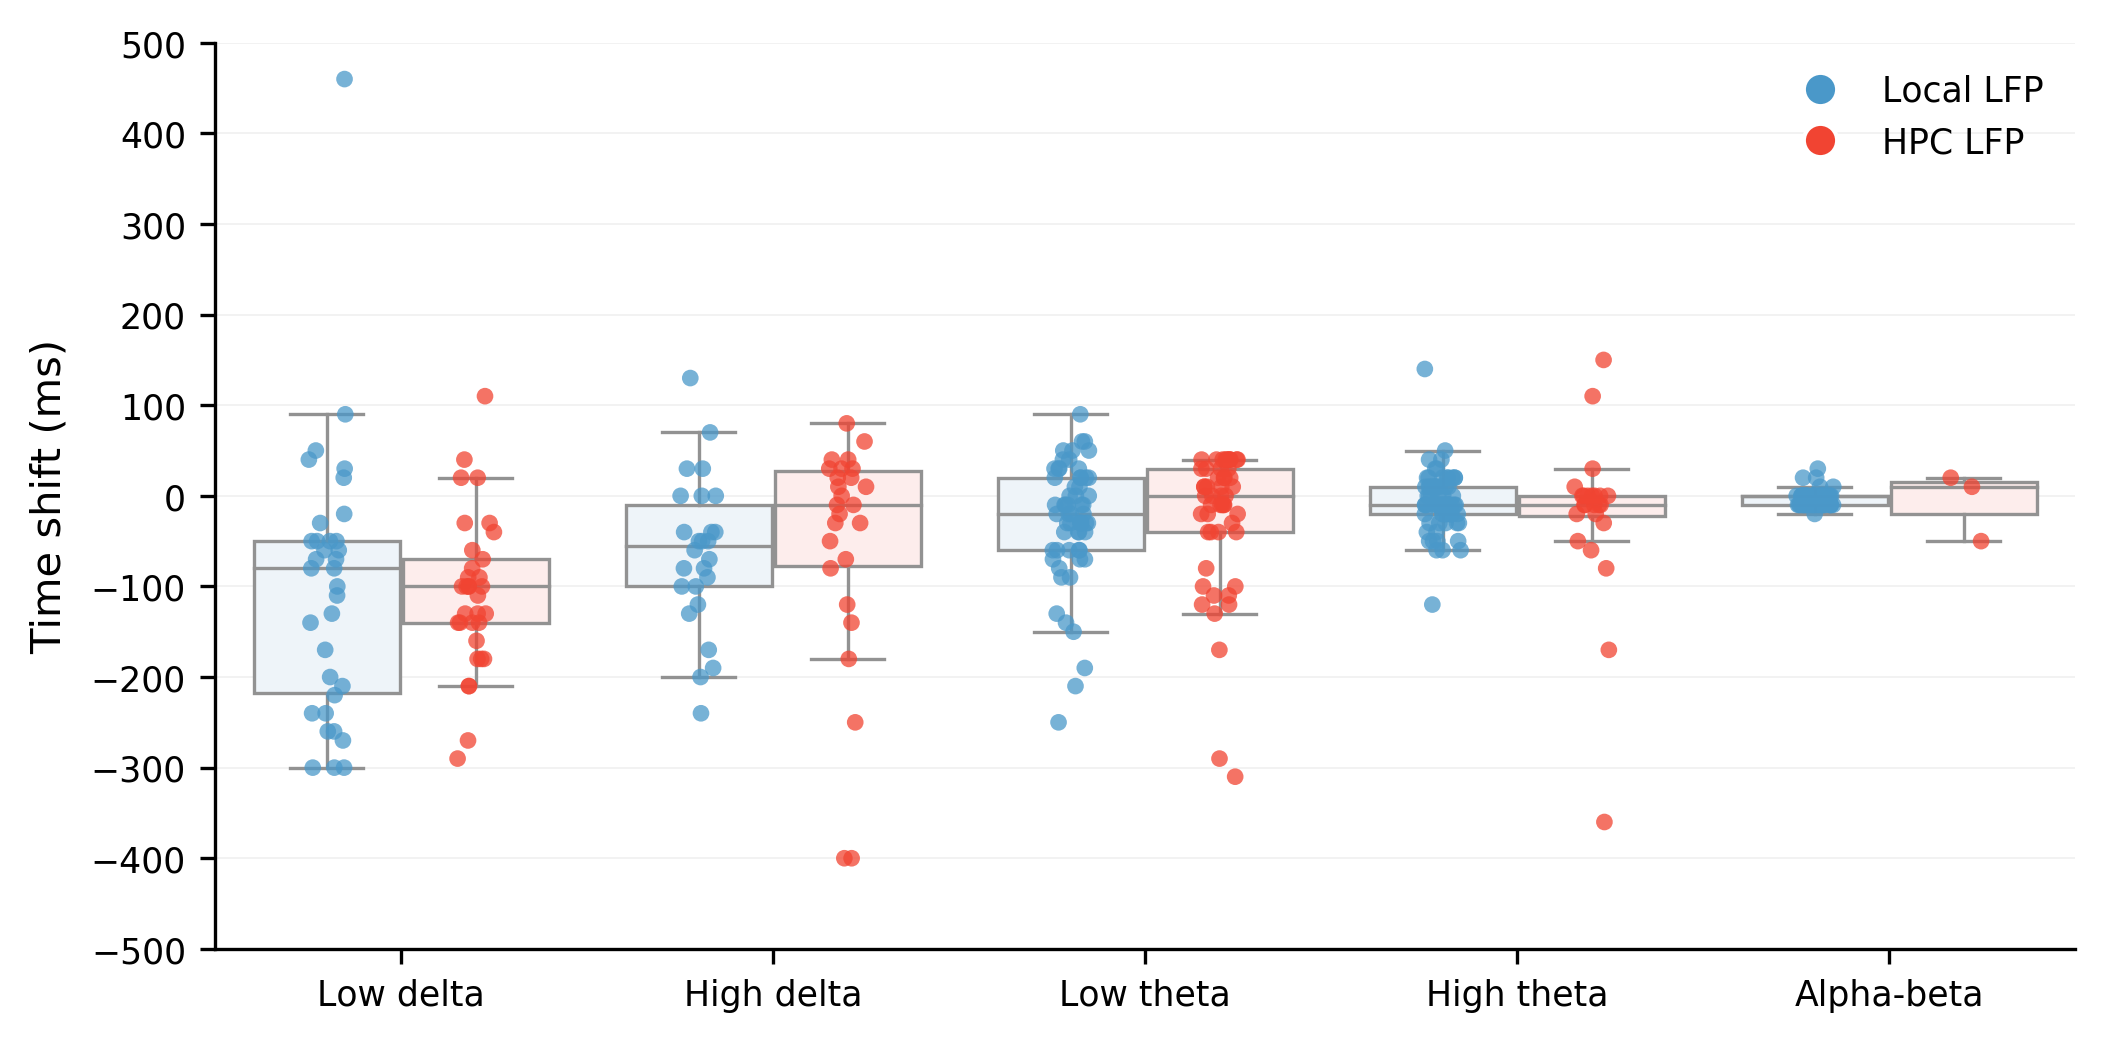

In [788]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4), dpi=300)
ax = np.ravel(ax)

sns.boxplot(x='locked_band', y='tl_timemax', hue='lfp_is_hpc', data=df,
            palette=(cmap[35], cmap[65]), saturation=1, showfliers=False)
sns.stripplot(x='locked_band', y='tl_timemax', hue='lfp_is_hpc', dodge=True, data=df,
              palette=colors, size=4, alpha=0.75)

ax[0].set_xticklabels(bands_fancy2.values())
ax[0].set_ylim([-500, 500])
ax[0].set_yticks(np.arange(-500, 501, 100))
ax[0].set_xlabel('')
ax[0].set_ylabel('Time shift (ms)', fontsize=10, labelpad=5)

custom_lines = [Line2D([0], [0], marker='o', color='w', label='Local LFP', markerfacecolor=colors[0], markersize=8),
                Line2D([0], [0], marker='o', color='w', label='HPC LFP', markerfacecolor=colors[1], markersize=8)]
legend = ax[0].legend(handles=custom_lines, loc=1)

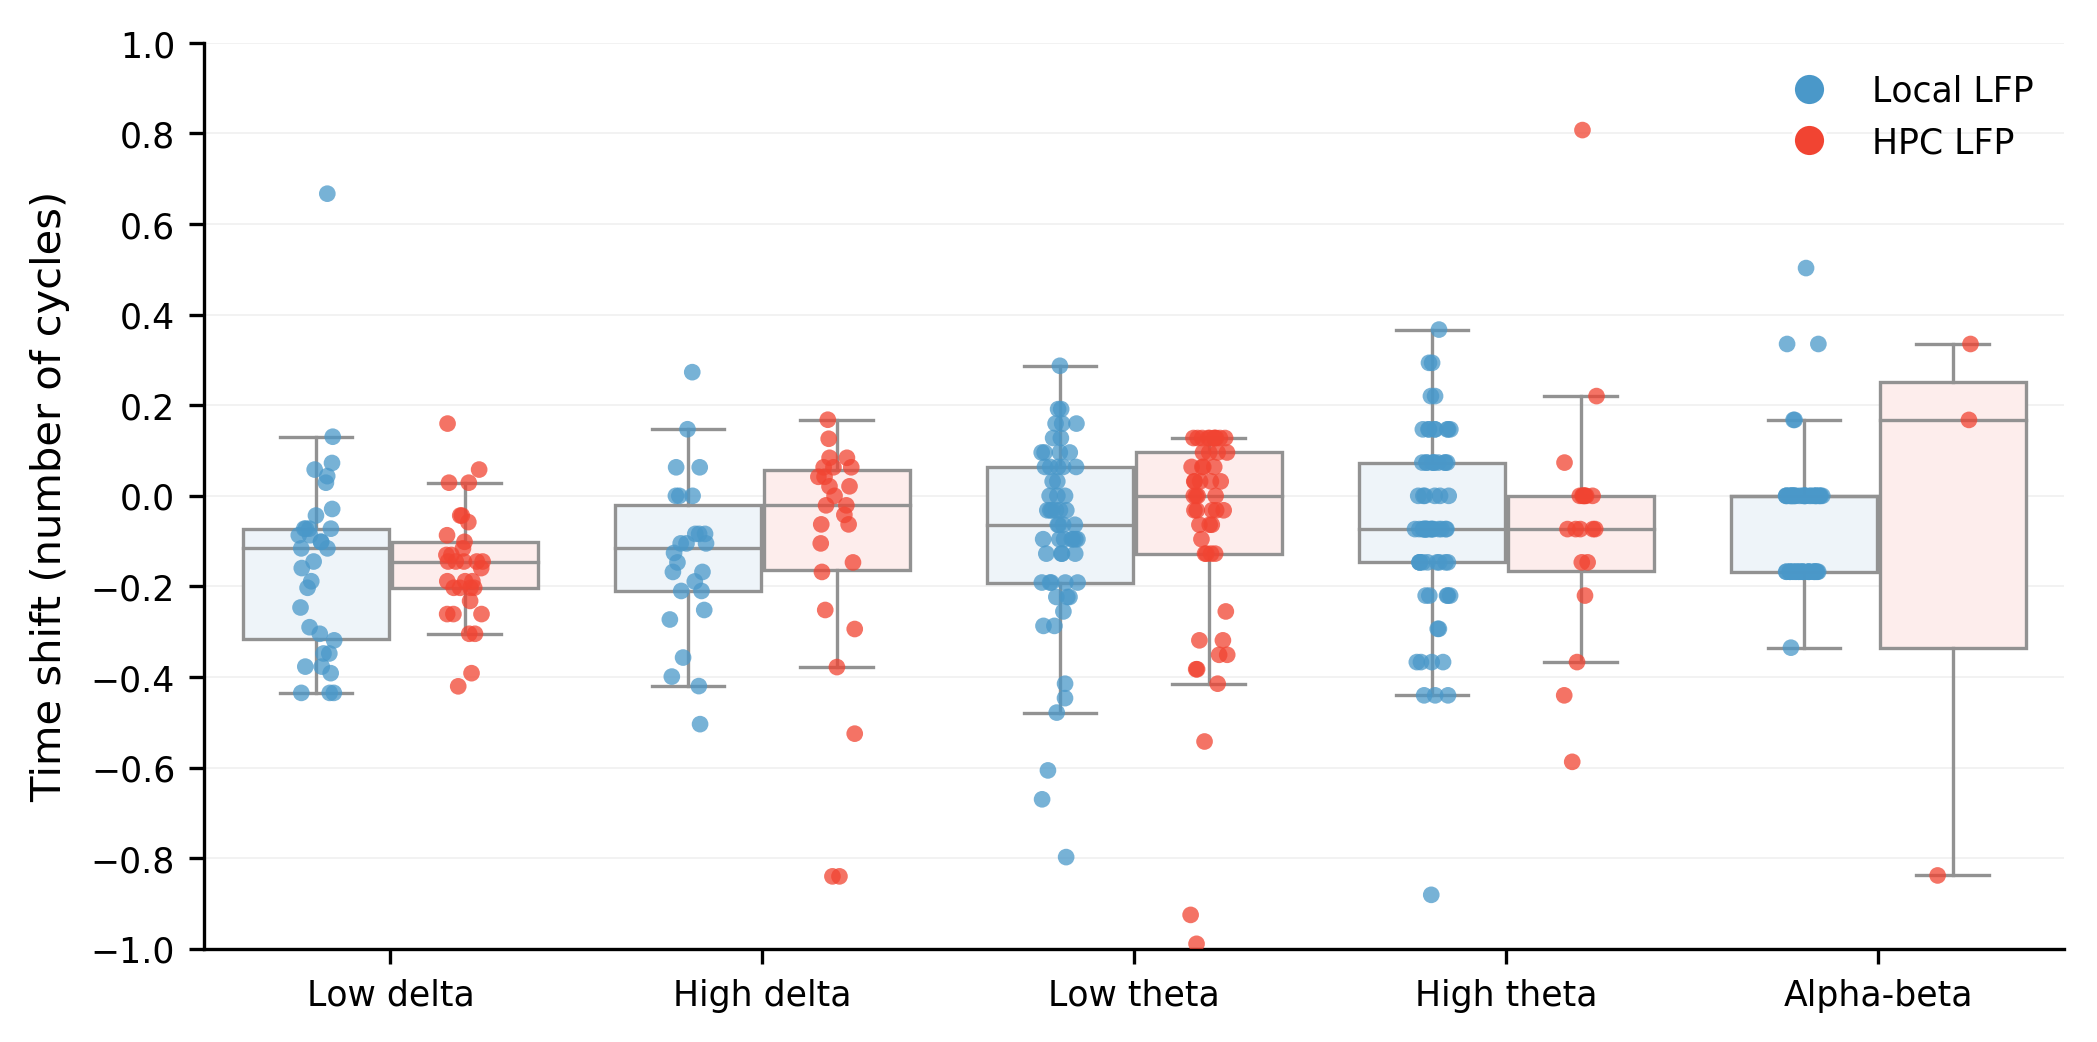

In [966]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4), dpi=300)
ax = np.ravel(ax)

sns.boxplot(x='locked_band', y='tl_timemax_cycles', hue='lfp_is_hpc', data=df,
            palette=(cmap[35], cmap[65]), saturation=1, showfliers=False)
sns.stripplot(x='locked_band', y='tl_timemax_cycles', hue='lfp_is_hpc', dodge=True, data=df,
              palette=colors, size=4, alpha=0.75)

ax[0].set_xticklabels(bands_fancy2.values())
ax[0].set_ylim([-1, 1])
ax[0].set_yticks(np.arange(-1, 1.1, 0.2))
ax[0].set_xlabel('')
ax[0].set_ylabel('Time shift (number of cycles)', fontsize=10, labelpad=5)

custom_lines = [Line2D([0], [0], marker='o', color='w', label='Local LFP', markerfacecolor=colors[0], markersize=8),
                Line2D([0], [0], marker='o', color='w', label='HPC LFP', markerfacecolor=colors[1], markersize=8)]
legend = ax[0].legend(handles=custom_lines, loc=1)

In [ ]:
# probability of being past, present, future based on locked band

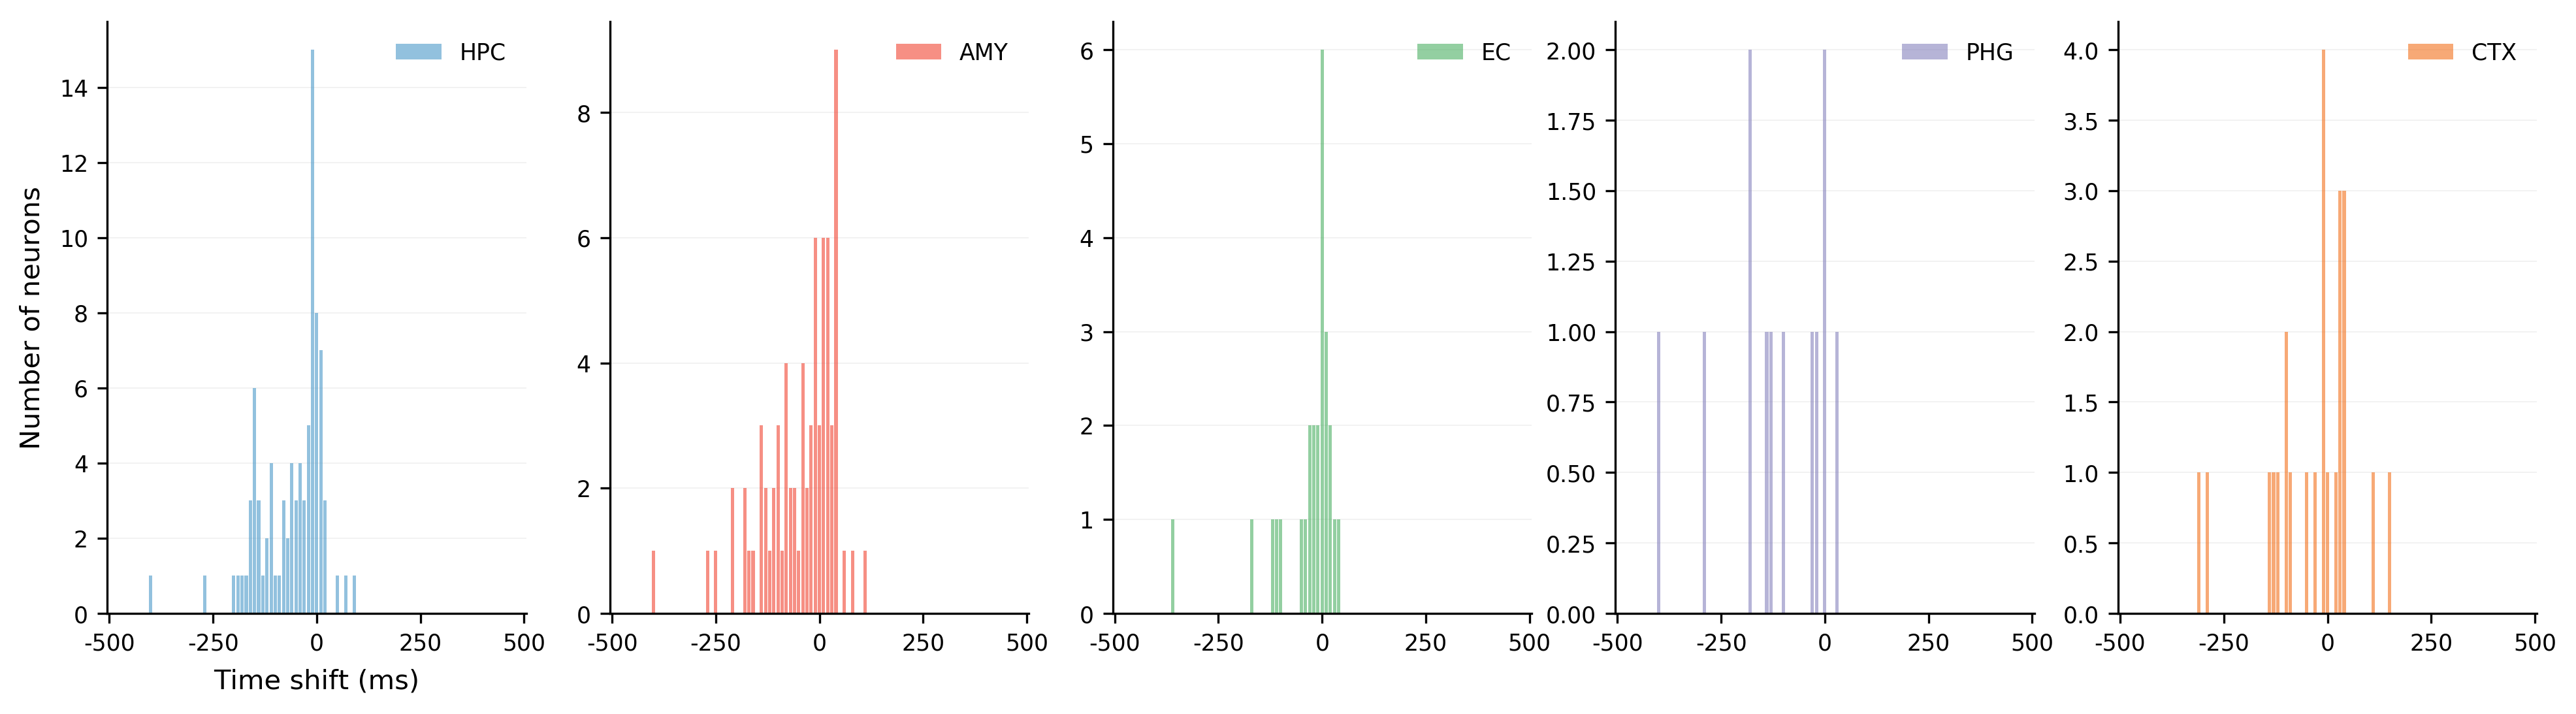

In [906]:
counts = OrderedDict()
for roi in rois:
    d = (upl_df
         .query("(sig==True) & (unit_roi2=='{}') & (lfp_is_hpc==True)".format(roi))
         .groupby('tl_timemax')
         .size()
         .to_dict())
    for i in np.arange(-500, 501, 10):
        counts.setdefault(roi, []).append(d.get(i, 0))
counts = pd.DataFrame(counts).reset_index()

fig, ax = plt.subplots(1, 5, figsize=(16, 4), dpi=300)
ax = np.ravel(ax)
for i in range(len(rois)):
    sns.barplot(x='index', y=rois[i], data=counts, saturation=100, color=colors[i], alpha=0.6, ax=ax[i], label=rois[i].upper())
    ax[i].set_xticks(np.arange(0, 101, 25))
    ax[i].set_xticklabels(np.arange(-500, 501, 250))
    ax[i].set_xlabel('Phase-locking frequency', fontsize=10, labelpad=10)
    if i == 0:
        ax[i].set_xlabel('Time shift (ms)', fontsize=10, labelpad=5)
        ax[i].set_ylabel('Number of neurons', fontsize=10, labelpad=5)
    else:
        ax[i].set_xlabel('')
        ax[i].set_ylabel('')
    ax[i].legend()

## Other stuff

In [289]:
# Phase-locking strength by band
upl_df.query("(sig==True) & (unit_roi2!='hpc')").groupby(['lfp_is_hpc', 'locked_band']).locked_mrl.describe()

count      mean       std       min       25%  \
lfp_is_hpc locked_band                                                  
0          sub_delta     34.0  0.078312  0.053914  0.024660  0.042912   
           delta         26.0  0.041077  0.026017  0.014112  0.022360   
           low_theta     60.0  0.082604  0.071913  0.015068  0.036090   
           high_theta    72.0  0.064343  0.048534  0.011151  0.029243   
           alpha_beta    60.0  0.051432  0.033830  0.013872  0.031343   
1          sub_delta     33.0  0.054916  0.029834  0.016077  0.032915   
           delta         26.0  0.056127  0.031564  0.012922  0.034849   
           low_theta     51.0  0.053739  0.024167  0.016516  0.037991   
           high_theta    24.0  0.056778  0.035993  0.012005  0.031912   
           alpha_beta     3.0  0.037707  0.011820  0.026765  0.031438   

                             50%       75%       max  
lfp_is_hpc locked_band                                
0          sub_delta    0.051687  0.108305  0.223492  
           delta        0.030621  0.057548  0.099987  
           low_theta    0.050870  0.096653  0.330607  
           high_theta   0.049665  0.084834  0.265150  
           alpha_beta   0.041279  0.056360  0.171114  
1          sub_delta    0.049733  0.070974  0.132344  
           delta        0.049395  0.061469  0.139355  
           low_theta    0.050978  0.065297  0.144065  
           high_theta   0.044104  0.070829  0.143280  
           alpha_beta   0.036111  0.043177  0.050244

lfp_is_hpc      local        hpc         vs      delta
count       98.000000  98.000000  98.000000  98.000000
mean         0.068714   0.052069  -0.016644  -0.163265
std          0.051008   0.027251   0.050891   0.991655
min          0.014112   0.012005  -0.295471  -1.000000
25%          0.036029   0.034402  -0.031295  -1.000000
50%          0.048233   0.045531  -0.003755  -1.000000
75%          0.090330   0.063787   0.011206   1.000000
max          0.330607   0.143280   0.096371   1.000000
WilcoxonResult(statistic=1688.0, pvalue=0.00896494543645137)
SpearmanrResult(correlation=0.3370694107071132, pvalue=0.0006890623934254829)


Text(0,0.5,'Hippocampal phase-locking strength')

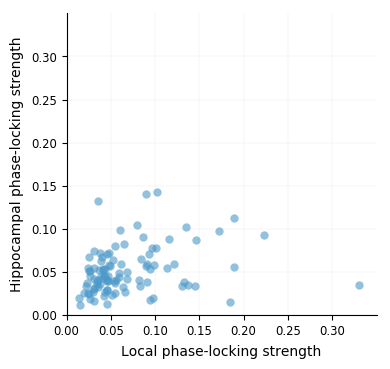

In [797]:
# Among doubly phase-locked neurons, phase-locking
# is stronger to local than to hippocampal LFPs.
df = (upl_df
      .query("(subj_sess_unit=={})".format(pl2_units))
      .groupby(['subj_sess_unit', 'lfp_is_hpc'])
      .locked_mrl
      .apply(lambda x: np.float64(x))
      .unstack()
      .rename(columns={0: 'local', 1: 'hpc'}))
df['vs'] = df.hpc - df.local
df['delta'] = df.vs.apply(lambda x: np.sign(x))
print(df.describe())
print(stats.wilcoxon(df.hpc, df.local))
print(stats.spearmanr(df.local, df.hpc))

fig, ax = plt.subplots(1, 1, figsize=(4, 4), dpi=100)
ax = np.ravel(ax)

#ax[0].scatter(df.local, df.hpc, alpha=0.6, color=sns.color_palette('viridis', 2)[0], linewidth=0)
sns.scatterplot(x=df.local, y=df.hpc, linewidth=0, alpha=0.6, color=colors[0])
ax[0].set_xlim([0, 0.35])
ax[0].set_xticks(np.arange(0, .35, .05))
ax[0].set_ylim([0, 0.35])
ax[0].set_yticks(np.arange(0, .35, .05))

ax[0].set_xlabel('Local phase-locking strength', fontsize=10, labelpad=5)
ax[0].set_ylabel('Hippocampal phase-locking strength', fontsize=10, labelpad=5)

In [288]:
# Phase-locking to hippocampus is not weaker than local LFPs
# for neurons locked to the same band
pl2_units_ = OrderedDict()
df = (upl_df
      .query("(subj_sess_unit=={})".format(pl2_units))
      .groupby(['subj_sess_unit', 'lfp_is_hpc'])
      .mrl_argmax
      .apply(int)
      .unstack()
      .rename(columns={0: 'local', 1: 'hpc'}))
pl2_units_['hpc<local'] = list(df[df.hpc < df.local].index)
pl2_units_['hpc=local'] = list(df[df.hpc == df.local].index)
pl2_units_['hpc>local'] = list(df[df.hpc > df.local].index)

df = (upl_df
      .query("(subj_sess_unit=={})".format(pl2_units_['hpc<local']))
      .groupby(['subj_sess_unit', 'lfp_is_hpc'])
      .locked_mrl
      .apply(float)
      .unstack()
      .rename(columns={0: 'local', 1: 'hpc'}))
df['vs'] = df.local - df.hpc
print('HPC < Local LFP band')
print(df.hpc.mean(), df.local.mean(), df.vs.mean(), df.shape)
print(stats.wilcoxon(df.hpc, df.local))

# ----------------------
df = (upl_df
      .query("(subj_sess_unit=={})".format(pl2_units_['hpc=local']))
      .groupby(['subj_sess_unit', 'lfp_is_hpc'])
      .locked_mrl
      .apply(float)
      .unstack()
      .rename(columns={0: 'local', 1: 'hpc'}))
df['vs'] = df.local - df.hpc
print('\nHPC = Local LFP band')
print(df.hpc.mean(), df.local.mean(), df.vs.mean(), df.shape)
print(stats.wilcoxon(df.hpc, df.local))

# ----------------------
df = (upl_df
      .query("(subj_sess_unit=={})".format(pl2_units_['hpc>local']))
      .groupby(['subj_sess_unit', 'lfp_is_hpc'])
      .locked_mrl
      .apply(float)
      .unstack()
      .rename(columns={0: 'local', 1: 'hpc'}))
df['vs'] = df.local - df.hpc
print('\nHPC > Local LFP band')
print(df.hpc.mean(), df.local.mean(), df.vs.mean(), df.shape)
print(stats.wilcoxon(df.hpc, df.local))

HPC < Local LFP band
0.04951368211619202 0.06504363746336454 0.015529955347172523 (47, 3)
WilcoxonResult(statistic=422.0, pvalue=0.13292505619274184)

HPC = Local LFP band
0.0533601709585524 0.06146664082076283 0.008106469862210424 (29, 3)
WilcoxonResult(statistic=210.0, pvalue=0.8711688268414225)

HPC > Local LFP band
0.05582648228311733 0.0861065277267968 0.03028004544367947 (22, 3)
WilcoxonResult(statistic=29.0, pvalue=0.0015486940788951365)


In [303]:
# Phase-locking leads hippocampal LFPs earlier than local LFPs?
df = (upl_df
      .query("(subj_sess_unit=={})".format(pl2_units))
      .groupby(['subj_sess_unit', 'lfp_is_hpc'])
      .tl_timemax
      .apply(lambda x: np.float64(x))
      .unstack()
      .rename(columns={0: 'local', 1: 'hpc'}))
df['vs'] = np.sign(df['hpc'] - df['local'])
print(df.hpc.mean(), df.local.mean(), df.vs.mean(), df.shape)
stats.wilcoxon(df.hpc, df.local)

-54.08163265306123 -56.734693877551024 0.08163265306122448 (98, 3)


WilcoxonResult(statistic=1935.5, pvalue=0.42784649740107306)

In [370]:
sig_units = [unit for unit in list(upl_df.query("(sig==True) & (unit_roi2!='hpc')").subj_sess_unit.unique())
             if unit not in pl2_units_['hpc=local']]
print(len(sig_units), len(pl2_units_['hpc=local']))

262 29


In [327]:
pl2_units_diffband = pl2_units_['hpc<local'] + pl2_units_['hpc>local']

In [406]:
for key, val in units.items():
    print(key, len(val))

neither 157
local 154
hpc 39
both 98
all 448


In [431]:
(upl_df
 .query("(subj_sess_unit=={}) & (lfp_is_hpc==False)".format(units['local'] + units['both']))
 .groupby('locked_band')
 .agg({'subj_sess_unit': len, 'tl_timemax': [np.mean, np.median], 'tl_timemax_cat': lambda x: np.unique(x, return_counts=True)}))

subj_sess_unit  tl_timemax         \
                       len        mean median   
locked_band                                     
sub_delta               34 -100.882353    -80   
delta                   26  -63.076923    -55   
low_theta               60  -27.833333    -20   
high_theta              72   -6.944444    -10   
alpha_beta              60   -3.166667      0   

                                                tl_timemax_cat  
                                                      <lambda>  
locked_band                                                     
sub_delta                    ([future LFP, past LFP], [28, 6])  
delta        ([future LFP, past LFP, present LFP], [19, 4, 3])  
low_theta    ([future LFP, past LFP, present LFP], [32, 17,...  
high_theta   ([future LFP, past LFP, present LFP], [24, 14,...  
alpha_beta   ([future LFP, past LFP, present LFP], [1, 3, 56])

In [430]:
(upl_df
 .query("(subj_sess_unit=={}) & (lfp_is_hpc==True)".format(units['hpc'] + units['both']))
 .groupby('locked_band')
 .agg({'subj_sess_unit': len, 'tl_timemax': [np.mean, np.median], 'tl_timemax_cat': lambda x: np.unique(x, return_counts=True)}))

subj_sess_unit  tl_timemax         \
                       len        mean median   
locked_band                                     
sub_delta               33 -107.272727   -100   
delta                   26  -54.615385    -10   
low_theta               51  -25.294118      0   
high_theta              24  -22.500000    -10   
alpha_beta               3   -6.666667     10   

                                                tl_timemax_cat  
                                                      <lambda>  
locked_band                                                     
sub_delta                    ([future LFP, past LFP], [29, 4])  
delta        ([future LFP, past LFP, present LFP], [12, 9, 5])  
low_theta    ([future LFP, past LFP, present LFP], [19, 18,...  
high_theta   ([future LFP, past LFP, present LFP], [8, 3, 13])  
alpha_beta    ([future LFP, past LFP, present LFP], [1, 1, 1])

In [432]:
upl_df.columns

Index(['subj_sess_unit', 'subj_sess', 'unit_roi2', 'lfp_roi2', 'unit_hem',
       'lfp_hem', 'unit_is_hpc', 'lfp_is_hpc', 'unit_fr', 'unit_nspikes',
       'mrls', 'tl_mrls', 'bs_mrls', 'mrl_argmax', 'locked_band', 'locked_mrl',
       'bs_ind', 'bs_pval', 'sig', 'tl_mrl_argmax', 'tl_locked_mrl',
       'tl_bs_ind', 'tl_bs_pval', 'tl_sig', 'tl_mrls_locked_band',
       'tl_timemax', 'tl_timemax_cat'],
      dtype='object')

In [790]:
df = (upl_df
      .query("(unit_roi2!='hpc')")
      #.query("(subj_sess_unit=={})".format(units['both']))
      .groupby(['subj_sess_unit', 'lfp_is_hpc'])
      .agg({'mrl_argmax': lambda x: 1 * x,
            'mrls': lambda x: tuple(x),
            'tl_mrls': lambda x: tuple(x)})
      .unstack())
df.columns = df.columns.map(lambda x: ''.join([*map(str, x)]))
df = df.reset_index().rename(columns={'mrl_argmax0': 'local_mrl_argmax', 
                                      'mrl_argmax1': 'hpc_mrl_argmax', 
                                      'mrls0': 'local_mrls', 
                                      'mrls1': 'hpc_mrls',
                                      'tl_mrls0': 'local_tl_mrls',
                                      'tl_mrls1': 'hpc_tl_mrls'})
df['local_mrls'] = df.local_mrls.apply(lambda x: np.array(x[0]))
df['hpc_mrls'] = df.hpc_mrls.apply(lambda x: np.array(x[0]))
df['local_tl_mrls'] = df.local_tl_mrls.apply(lambda x: np.array(x[0]))
df['hpc_tl_mrls'] = df.hpc_tl_mrls.apply(lambda x: np.array(x[0]))

df['localmrls_localband'] = df.apply(lambda x: x['local_mrls'][x['local_mrl_argmax']], axis=1)
df['localmrls_hpcband'] = df.apply(lambda x: x['local_mrls'][x['hpc_mrl_argmax']], axis=1)
df['hpcmrls_localband'] = df.apply(lambda x: x['hpc_mrls'][x['local_mrl_argmax']], axis=1)
df['hpcmrls_hpcband'] = df.apply(lambda x: x['hpc_mrls'][x['hpc_mrl_argmax']], axis=1)

df['local_timemax_localband'] = df.apply(lambda x: (x['local_tl_mrls'][x['local_mrl_argmax'], :].argmax() - 200) * -10, axis=1)
df['local_timemax_hpcband'] = df.apply(lambda x: (x['local_tl_mrls'][x['hpc_mrl_argmax'], :].argmax() - 200) * -10, axis=1)
df['hpc_timemax_localband'] = df.apply(lambda x: (x['hpc_tl_mrls'][x['local_mrl_argmax'], :].argmax() - 200) * -10, axis=1)
df['hpc_timemax_hpcband'] = df.apply(lambda x: (x['hpc_tl_mrls'][x['hpc_mrl_argmax'], :].argmax() - 200) * -10, axis=1)
df['same_locked_band'] = False
df.loc[df.local_mrl_argmax==df.hpc_mrl_argmax, 'same_locked_band'] = True
df['sig'] = ''
for sig_type in ['neither', 'local', 'hpc', 'both']:
    df.loc[np.isin(df.subj_sess_unit, units[sig_type]), 'sig'] = sig_type
df['hpc_to_local'] = df.local_timemax_hpcband < df.hpc_timemax_hpcband

unit_df = df.copy()

print(unit_df.shape)
unit_df.head()

(448, 18)


,subj_sess_unit,local_mrl_argmax,hpc_mrl_argmax,local_mrls,hpc_mrls,local_tl_mrls,hpc_tl_mrls,localmrls_localband,localmrls_hpcband,hpcmrls_localband,hpcmrls_hpcband,local_timemax_localband,local_timemax_hpcband,hpc_timemax_localband,hpc_timemax_hpcband,same_locked_band,sig,hpc_to_local
0,U369_env1_0,3,3,"[0.052972006976430404, 0.03484987945999925, 0....","[0.024571594003438238, 0.02927006922697464, 0....","[[0.02361774226288652, 0.024058338311990713, 0...","[[0.02990469590057907, 0.02958694135630864, 0....",0.062038,0.062038,0.059007,0.059007,-20,-20,0,0,True,both,True
1,U369_env1_1,2,2,"[0.013499525630114898, 0.02336092402793561, 0....","[0.014154718020010056, 0.02279962316787592, 0....","[[0.011141516834725562, 0.011248736169785873, ...","[[0.013821269532918455, 0.013973026963536767, ...",0.034169,0.034169,0.039357,0.039357,20,20,0,0,True,both,False
2,U369_env1_10,3,3,"[0.04375201201969662, 0.046072844707838276, 0....","[0.032618505896888736, 0.0364432218128335, 0.0...","[[0.05733134819630233, 0.05698147575193541, 0....","[[0.04573524553902335, 0.04627786569241439, 0....",0.047087,0.047087,0.055235,0.055235,950,950,10,10,True,neither,False
3,U369_env1_14,3,3,"[0.0075062709186553365, 0.01810513659065523, 0...","[0.005562213445182356, 0.008870744541555307, 0...","[[0.012569701826067719, 0.012519869206028822, ...","[[0.004320596772466316, 0.004324319264859989, ...",0.184533,0.184533,0.015151,0.015151,10,10,150,150,True,both,True
4,U369_env1_15,4,0,"[0.009858444666818447, 0.01024488027908965, 0....","[0.00712138400535174, 0.006528244726710422, 0....","[[0.011891344042634701, 0.011889094162838523, ...","[[0.007186498559214697, 0.0071660524572832555,...",0.027953,0.009858,0.004459,0.007121,20,-480,1370,-1240,False,local,False


In [791]:
unit_df.query("(sig==['both'])").groupby('hpc_to_local').size() / len(unit_df.query("(sig==['both'])"))

hpc_to_local
False    0.397959
True     0.602041
dtype: float64

In [792]:
stats.binom_test(39, 448, p=0.05)

0.001008200652660685

In [793]:
stats.spearmanr(unit_df.query("(sig==['both'])").local_timemax_hpcband, unit_df.query("(sig==['both'])").hpc_timemax_hpcband)

SpearmanrResult(correlation=0.20381403245766025, pvalue=0.044119885715725234)

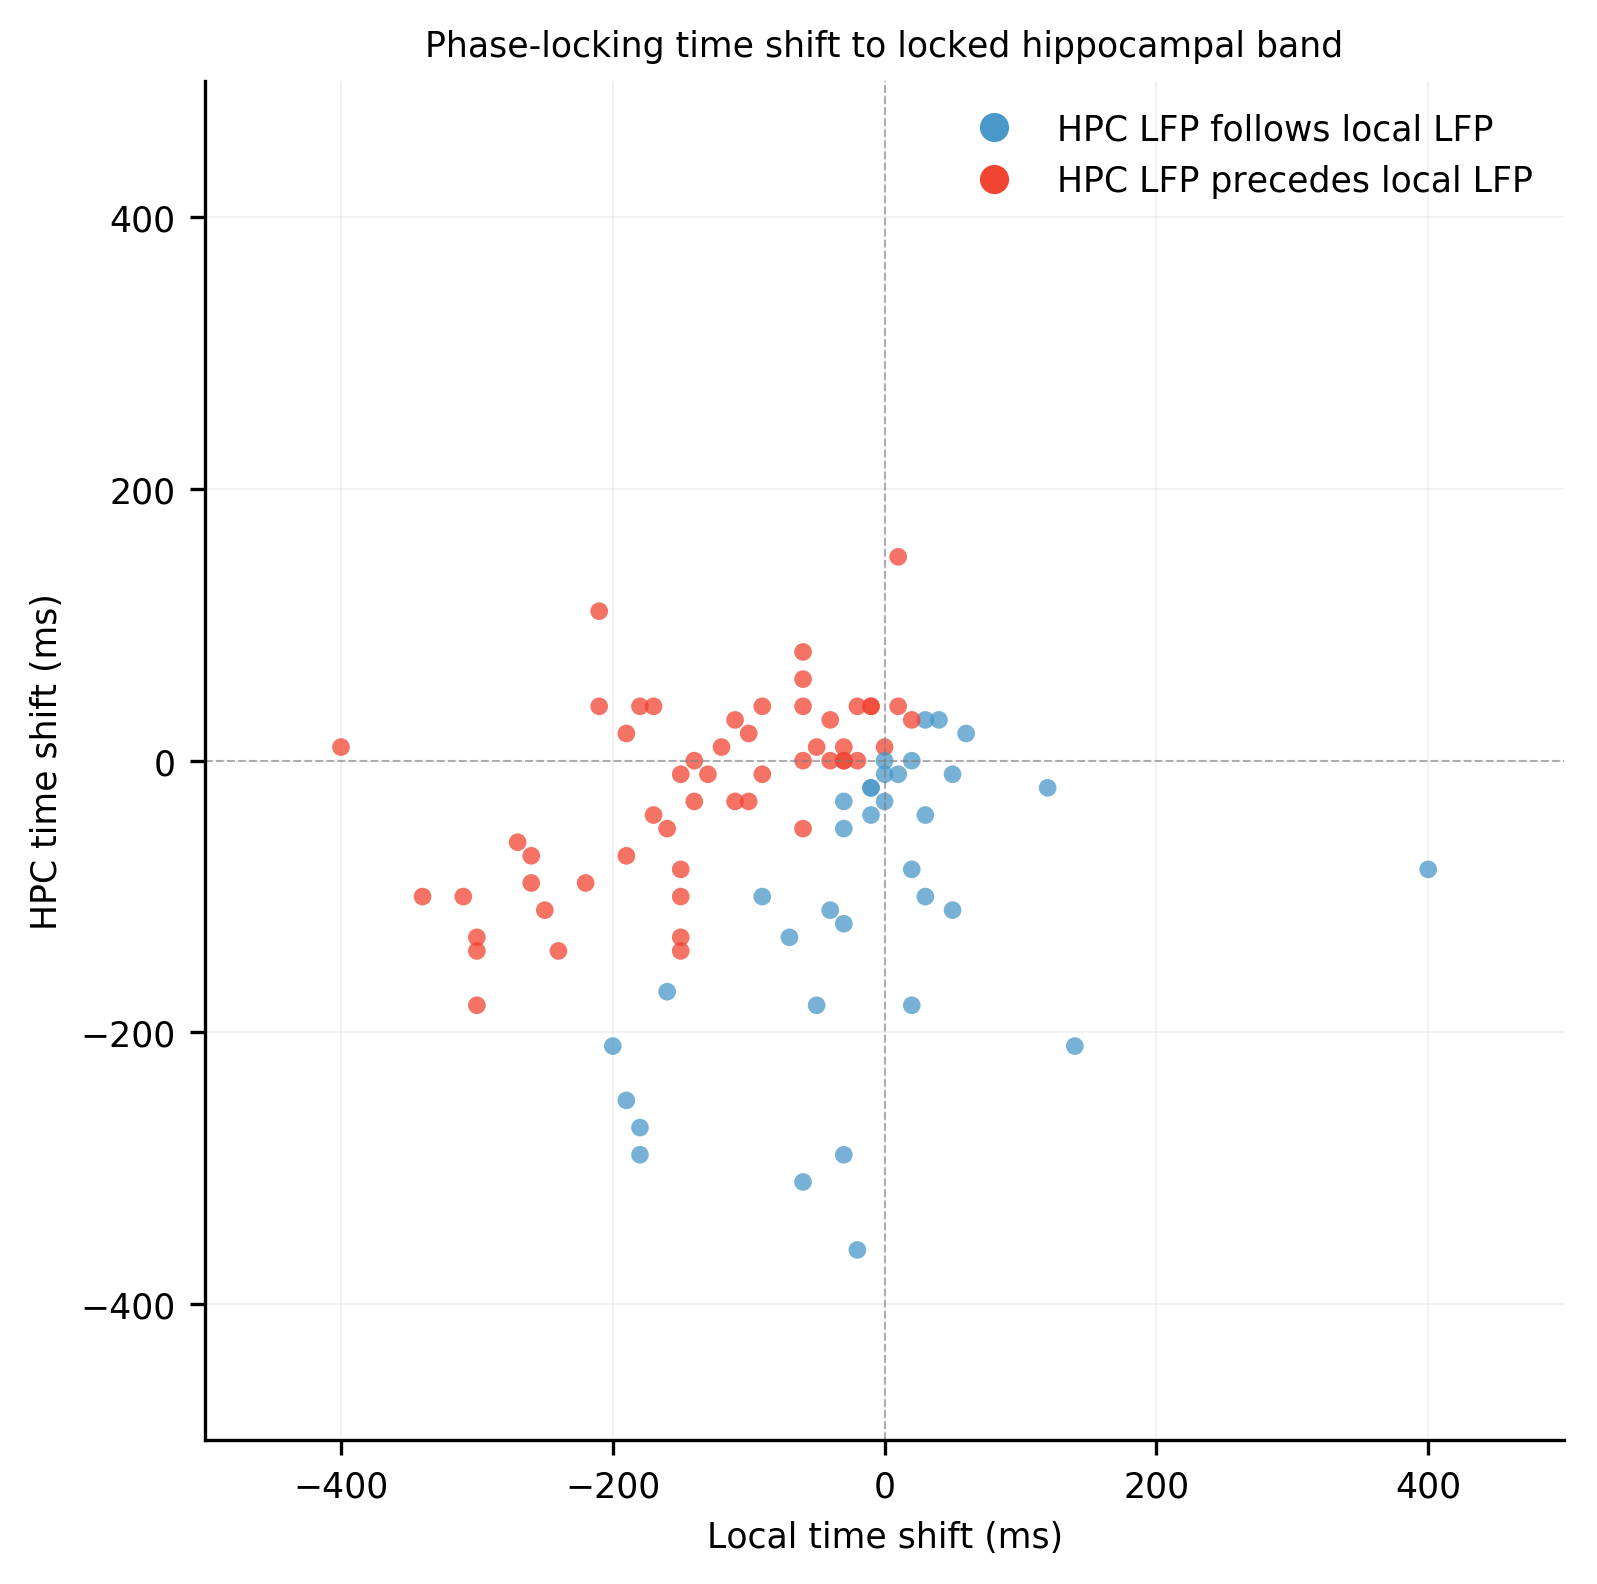

In [948]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6), dpi=300)
ax = np.ravel(ax)

ax[0].axhline(y=0, linewidth=0.5, alpha=0.6, linestyle='--', color='C7')
ax[0].axvline(x=0, linewidth=0.5, alpha=0.6, linestyle='--', color='C7')
sns.scatterplot(x='local_timemax_hpcband', y='hpc_timemax_hpcband', hue='hpc_to_local', data=unit_df.query("(sig==['both'])"),
                linewidth=0, size=12, alpha=0.75, ax=ax[0], legend=False, palette=colors[:2])
ax[0].set_xlim([-500, 500])
ax[0].set_ylim([-500, 500])
ax[0].set_aspect('equal')
ax[0].set_xlabel('Local time shift (ms)')
ax[0].set_ylabel('HPC time shift (ms)')
ax[0].set_title('Phase-locking time shift to locked hippocampal band')

custom_lines = [Line2D([0], [0], marker='o', color='w', label='HPC LFP follows local LFP', markerfacecolor=colors[0], markersize=8),
                Line2D([0], [0], marker='o', color='w', label='HPC LFP precedes local LFP', markerfacecolor=colors[1], markersize=8)]
legend = ax[0].legend(handles=custom_lines, loc=1)

In [411]:
print('HPC band:', np.mean(df.hpcmrls_hpcband - df.localmrls_hpcband), stats.wilcoxon(df.hpcmrls_hpcband, df.localmrls_hpcband)) 
print('Local band:', np.mean(df.localmrls_localband - df.hpcmrls_localband), stats.wilcoxon(df.localmrls_localband, df.hpcmrls_localband))

HPC band: -0.0037787063545336084 WilcoxonResult(statistic=2170.0, pvalue=0.36526203136510815)
Local band: 0.027288497266754478 WilcoxonResult(statistic=895.0, pvalue=5.84613468066545e-08)


In [378]:
np.mean(df.hpcmrls_hpcband - df.localmrls_hpcband)

-0.0017012592766453873

In [353]:
df.describe()

,local_mrl_argmax,hpc_mrl_argmax,localmrls_localband,localmrls_hpcband,hpcmrls_localband,hpcmrls_hpcband
count,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000
mean,2.115942,1.478261,0.071759,0.053486,0.036409,0.051526
std,1.419779,1.158202,0.053678,0.047455,0.024578,0.027407
min,0.000000,0.000000,0.014112,0.009884,0.003275,0.012005
25%,1.000000,0.000000,0.040233,0.023764,0.019287,0.033145
50%,2.000000,2.000000,0.052432,0.037303,0.029544,0.044019
75%,3.000000,2.000000,0.090454,0.064526,0.043871,0.063963
max,4.000000,4.000000,0.330607,0.290328,0.115786,0.140935


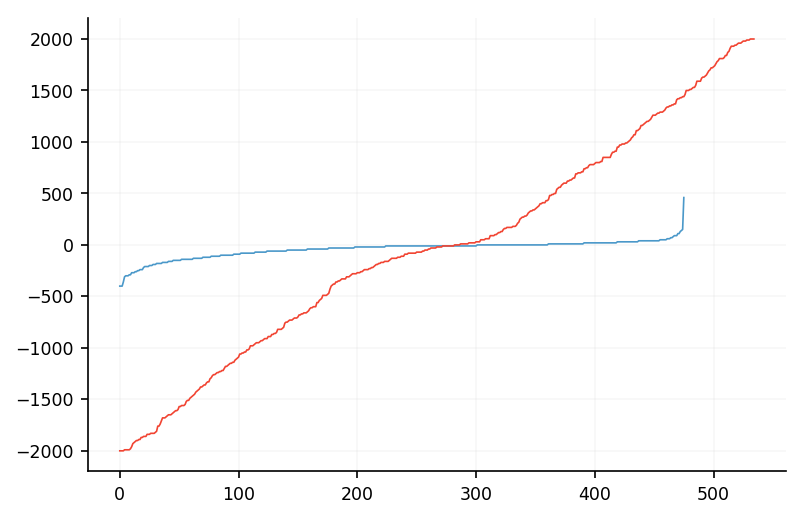

In [907]:
plt.plot(np.sort(upl_df.query("sig==True").tl_timemax), color=colors[0])
plt.plot(np.sort(upl_df.query("sig==False").tl_timemax), color=colors[1])